In [2]:
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy.constants as const
import jax.numpy as jnp
import jax
import jax.random as random
from copy import deepcopy
import time

#Some lenstronomy imports
import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
# import the lens equation solver class (finding image plane positions of a source position)
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
# # import lens model solver with 4 image positions constrains
# from lenstronomy.LensModel.Solver.solver4point import Solver4Point

# from helens import LensEquationSolver
import pandas as pd
from collections import OrderedDict
from functools import partial
from herculens.Util import param_util, plot_util
# from herculens.Util import param_util
import functools
import herculens as hcl
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
import jax
jax.config.update("jax_enable_x64", True)

#use cuda if available
try:
    import jaxlib
    if jaxlib.version < (0, 4, 0):
        # For older versions of JAX
        if jax.cuda.is_available():
            jax.config.update("jax_platform_name", "cuda")
        else:
            jax.config.update("jax_platform_name", "cpu")
    else:
        # For newer versions of JAX
        jax.config.update("jax_platform_name", "gpu" if jax.devices()[0].platform == "gpu" else "cpu")
except:
    # Fallback for any issues
    jax.config.update("jax_platform_name", "cpu")

#Finally what is it using
print(f"JAX is using: {jax.devices()[0].platform}")


# probabilistic model and variational inference
import numpyro
import numpyro.distributions as dist
from numpyro import infer
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.handlers import seed
from numpyro.infer.autoguide import AutoNormal, AutoDelta, AutoMultivariateNormal
from numpyro.infer.reparam import LocScaleReparam
from numpyro.infer import MCMC, NUTS
from numpyro.infer import init_to_median, init_to_feasible, init_to_value
from numpyro.distributions import constraints
from numpyro.distributions import transforms
# NUTS Hamiltonian MC sampling
import blackjax
# import numpyro.constraints as constraints


#Helens
from helens import LensEquationSolver as LensEquationSolver_helens

import dynesty
from dynesty import plotting as dyplot
import corner 
import matplotlib.pyplot as plt

# Load JAX cosmology functions from the separate module
import sys
sys.path.append('/Users/souvik/Documents/herculens_project')  # Add full path to project root
from jaxcosmo import JAXCosmology 
from astropy.cosmology import FlatLambdaCDM

import lensimage_gw
from fisher import FisherMatrix
import corner_plot

import scienceplots
plt.style.use(['science','ieee','high-vis'])


JAX is using: cpu


In [3]:
# Create JAX cosmology instance with the same parameters
jax_cosmo = JAXCosmology(H0=67.3, Om0=0.316)
astropy_cosmo = FlatLambdaCDM(H0=67.3, Om0=0.316)
print("JAX Cosmology Functions Loaded!")
print(f"Parameters: H0 = {jax_cosmo.H0} km/s/Mpc, Om0 = {jax_cosmo.Om0}, Ode0 = {jax_cosmo.Ode0}")
print(f"Hubble distance: {jax_cosmo.hubble_distance:.2f} Mpc")
print(f"Astropy Cosmology: H0 = {astropy_cosmo.H0} km/s/Mpc, Om0 = {astropy_cosmo.Om0}, Ode0 = {astropy_cosmo.Ode0}")
print(f"Hubble distance: {astropy_cosmo.hubble_distance:.2f} Mpc")


JAX Cosmology Functions Loaded!
Parameters: H0 = 67.3 km/s/Mpc, Om0 = 0.316, Ode0 = 0.6839999999999999
Hubble distance: 4454.57 Mpc
Astropy Cosmology: H0 = 67.3 km / (Mpc s) km/s/Mpc, Om0 = 0.316, Ode0 = 0.6839999999999999
Hubble distance: 4454.57 Mpc Mpc


In [4]:
#Setup the lens
zs_true = 2.0; zl_true = 0.5
phi_true = 8.0 # position angle, here in degree
q_true = 0.75 # axis ratio, b/a
e1_true, e2_true = param_util.phi_q2_ellipticity(phi_true * jnp.pi / 180, q_true) # conversion to ellipticities
print(e1_true, e2_true)
theta_E_true = 5.0 # Einstein radius
y0true = 0.3
y1true = 0.2
# y_true = jnp.array([y0true, y1true])
cx0_true, cy0_true = 0.0, 0.0 # position of the lens

lens_mass_model  = MassModel(["SIE", 'SHEAR'])
# lens_mass_model_input = hcl.MassModel([hcl.SIE(), hcl.Shear()])


#SIS for validation and first pass
# kwargs_lens_true_sis = [
#     {'theta_E': theta_E_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIS
# ]
kwargs_lens_true_sie = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true}  # SIE
]

# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.0001
# conversion to polar coordinates
gamma1_true, gamma2_true = param_util.shear_polar2cartesian(phi_ext * jnp.pi / 180, gamma_ext)
print(gamma1_true, gamma2_true)
kwargs_lens_true_sie_shear = [
    {'theta_E': theta_E_true, 'e1': e1_true, 'e2': e2_true, 'center_x': cx0_true, 'center_y': cy0_true},  # SIE
    {'gamma1': gamma1_true, 'gamma2': gamma2_true, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]


0.13732309941975984 0.03937676511671417
-3.090169943749473e-05 9.510565162951537e-05


In [5]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver


# Define classes for lenstronomy
lensModel = LensModel(lens_model_list=['SIE','SHEAR'],z_lens = zl_true, z_source=zs_true)
solver_lenstronomy = LensEquationSolver(lensModel)

# Convert JAX arrays to regular Python floats for lenstronomy compatibility
kwargs_lens_true_sie_shear_fixed = [
    {
        'theta_E': float(theta_E_true), 
        'e1': float(e1_true), 
        'e2': float(e2_true), 
        'center_x': float(cx0_true), 
        'center_y': float(cy0_true)
    },
    {
        'gamma1': float(gamma1_true),
        'gamma2': float(gamma2_true),
        'ra_0': float(0.0),
        'dec_0': float(0.0)
    }
]

# Convert source positions to regular Python floats
y0true_float = float(y0true)
y1true_float = float(y1true)

print("Fixed lens parameters for lenstronomy:")
print(f"  theta_E: {kwargs_lens_true_sie_shear_fixed[0]['theta_E']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['theta_E'])})")
print(f"  e1: {kwargs_lens_true_sie_shear_fixed[0]['e1']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['e1'])})")
print(f"  e2: {kwargs_lens_true_sie_shear_fixed[0]['e2']} (type: {type(kwargs_lens_true_sie_shear_fixed[0]['e2'])})")
print(f"  source position: ({y0true_float}, {y1true_float})")

# compute image position of full model (with numerical options attached)
x_image_true, y_image_true = solver_lenstronomy.image_position_from_source(
    kwargs_lens=kwargs_lens_true_sie_shear_fixed,
    sourcePos_x=y0true_float, 
    sourcePos_y=y1true_float,
    min_distance=0.01, 
    search_window=15, 
    precision_limit=10**(-10), 
    num_iter_max=1200,
    solver='lenstronomy'
)
print('image positions (x coordinates): ', x_image_true)
print('image positions (y coordinates): ', y_image_true)

# check solver precision by ray-tracing the image positions back into the source plane
x_source_new, y_source_new = lensModel.ray_shooting(x_image_true, y_image_true, kwargs_lens_true_sie_shear_fixed)
print('x_source_new:',x_source_new)
print('y_source_new:',y_source_new)
print("the relative precision of the image positions are: ", x_source_new - y0true_float)


Fixed lens parameters for lenstronomy:
  theta_E: 5.0 (type: <class 'float'>)
  e1: 0.13732309941975984 (type: <class 'float'>)
  e2: 0.03937676511671417 (type: <class 'float'>)
  source position: (0.3, 0.2)
image positions (x coordinates):  [ 0.93983855  2.90057564  5.01972316 -4.25658029]
image positions (y coordinates):  [ 5.33193565 -4.22283481 -0.4382769  -1.10487159]
x_source_new: [0.3 0.3 0.3 0.3]
y_source_new: [0.2 0.2 0.2 0.2]
the relative precision of the image positions are:  [ 2.89895330e-11 -2.20640173e-12 -3.99619782e-11 -2.19929630e-12]


In [6]:
#Set up pixel grid
npix = 200  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * jnp.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")



image size : (200, 200) pixels
pixel size : 0.08 arcsec
x range    : (Array(-7.96, dtype=float64), Array(7.96, dtype=float64)) arcsec
y range    : (Array(-7.96, dtype=float64), Array(7.96, dtype=float64)) arcsec


In [7]:
# Setting up the solver grid
solver_pixel_grid = pixel_grid.create_model_grid(pixel_scale_factor=0.4)

#pixel scale factor is 0.5, so the solver grid is 2x coarser
print(pixel_grid.num_pixel, solver_pixel_grid.num_pixel)    

40000 250000


In [8]:
lens_gw = lensimage_gw.LensImageGW(lens_mass_model)
# For ray shooting function for the solver, use lens_gw.ray_shooting
# Test the ray shooting function
x_source_true, y_source_true = lens_gw.ray_shoot(x_image_true, y_image_true, kwargs_lens_true_sie_shear_fixed)
print(x_source_true, y_source_true) # Perfectly matches the source position


[0.3 0.3 0.3 0.3] [0.2 0.2 0.2 0.2]


In [9]:
solver_pixel_grid.pixel_coordinates

(Array([[-7.984, -7.952, -7.92 , ...,  7.92 ,  7.952,  7.984],
        [-7.984, -7.952, -7.92 , ...,  7.92 ,  7.952,  7.984],
        [-7.984, -7.952, -7.92 , ...,  7.92 ,  7.952,  7.984],
        ...,
        [-7.984, -7.952, -7.92 , ...,  7.92 ,  7.952,  7.984],
        [-7.984, -7.952, -7.92 , ...,  7.92 ,  7.952,  7.984],
        [-7.984, -7.952, -7.92 , ...,  7.92 ,  7.952,  7.984]],      dtype=float64),
 Array([[-7.984, -7.984, -7.984, ..., -7.984, -7.984, -7.984],
        [-7.952, -7.952, -7.952, ..., -7.952, -7.952, -7.952],
        [-7.92 , -7.92 , -7.92 , ..., -7.92 , -7.92 , -7.92 ],
        ...,
        [ 7.92 ,  7.92 ,  7.92 , ...,  7.92 ,  7.92 ,  7.92 ],
        [ 7.952,  7.952,  7.952, ...,  7.952,  7.952,  7.952],
        [ 7.984,  7.984,  7.984, ...,  7.984,  7.984,  7.984]],      dtype=float64))

In [10]:
solver_grid_x = solver_pixel_grid.pixel_coordinates[0]
solver_grid_y = solver_pixel_grid.pixel_coordinates[1]
solver = LensEquationSolver_helens(solver_grid_x, solver_grid_y, lens_gw.ray_shoot)

# Hyperparameters of the solver
solver_params = {
    # You have to specify the number of predicted images in advance
    'nsolutions': 5,

    # Hyperparameters (see docstring above)
    'niter': 6, 
    'scale_factor': 2, 
    'nsubdivisions': 3,
}

# Meanings of the hyperparameters
"""
nsolutions: int, optional
    Number of expected solutions (e.g. 5 for a quad including the
    central image)
niter : int
    Number of iterations of the solver.
scale_factor : float, optional
    Factor by which to scale the selected triangle areas at each iteration.
nsubdivisions : int, optional
    Number of times to subdivide (into 4) the selected triangles at
    each iteration.

Returns
-------
theta, beta : tuple of 2D jax arrays
    Image plane positions and their source plane counterparts are
    returned as arrays of shape (N, 2).
"""


estim_acc = solver.estimate_accuracy(
    solver_params['niter'], 
    solver_params['scale_factor'], 
    solver_params['nsubdivisions']
)
print(f"Estimated accuracy in image plane (arcsec): {estim_acc:.2e}")

Estimated accuracy in image plane (arcsec): 9.77e-07


In [11]:
some_beta_x, some_beta_y = y0true, y1true
some_beta = jnp.array([some_beta_x, some_beta_y])  # jnp.array is not absolutely necessary in this notebook

In [12]:
%%time
_ = solver.solve(
    some_beta, kwargs_lens_true_sie_shear, 
    **solver_params
)  # takes some time to JIT-compile


CPU times: user 8.71 s, sys: 557 ms, total: 9.27 s
Wall time: 9.15 s


In [13]:
%%time
result_thetas, result_betas = solver.solve(
    some_beta, kwargs_lens_true_sie_shear,
    **solver_params
)  # this is now very fast and differentiable!

CPU times: user 618 ms, sys: 220 ms, total: 838 ms
Wall time: 597 ms


In [14]:
result_thetas, result_betas 

(Array([[ 9.39838478e-01,  5.33193598e+00],
        [-1.31349942e-07, -1.31349942e-07],
        [ 5.01972329e+00, -4.38276950e-01],
        [ 2.90057514e+00, -4.22283461e+00],
        [-4.25658048e+00, -1.10487140e+00]], dtype=float64),
 Array([[ 0.30000003,  0.20000032],
        [ 0.0893602 , -0.07651083],
        [ 0.30000013,  0.19999999],
        [ 0.29999972,  0.20000035],
        [ 0.29999989,  0.1999999 ]], dtype=float64))

In [15]:
# # unpack the results
# result_theta_x, result_theta_y = result_thetas.T  # image plane positions
# result_beta_x, result_beta_y = result_betas.T # corresponding source plane positions

In [16]:
# n = 5
# order = jnp.arange(n)
# print('order: ',order)
# idx= 2
# # Move idx to the last position; keep others in order with a compact remap
# # order2 = jnp.concatenate([jnp.arange(idx), jnp.arange(idx + 1, n), jnp.array([idx])])
# # Correct version:
# # order2 = jnp.where(order > idx, order - 1, jnp.where(order == idx, n-1, order))
# # order2 = jnp.where(order > idx, order - 1, jnp.where(order == idx, n-1, order))
# # order2 = jnp.concatenate([order[:idx], order[idx+1:], jnp.array([idx])])
# # before_idx = jax.lax.dynamic_slice(order, (0,), (idx,))
# # after_idx = jax.lax.dynamic_slice(order, (idx + 1,), (n - idx - 1,))
# # idx_itself = jnp.array([idx])
# # order2 = jnp.concatenate([before_idx, after_idx, idx_itself])

# # Move central image to end, shift others left
# # Create a mask: True for all indices except idx
# mask = jnp.arange(n) != idx

# # Reorder: all masked elements first, then the idx element
# # Use argsort on ~mask to put False (idx) at the end
# order2 = jnp.argsort(~mask,stable=True)


# print('order2: ',order2)

In [17]:
def remove_central_image(thetas, betas, cx0, cy0):
    # thetas, betas: shape (N, 2)
    theta_x, theta_y = thetas.T
    beta_x, beta_y = betas.T

    idx = jnp.argmin(jnp.hypot(theta_x - cx0, theta_y - cy0))  # int index
    # print('idx: ',idx)
    n = theta_x.shape[0]  # static

    # Create a mask: True for all indices except idx
    mask = jnp.arange(n) != idx
    
    # Reorder: all masked elements first, then the idx element
    # Use argsort on ~mask to put False (idx) at the end
    order = jnp.argsort(~mask, stable=True)
    # print('order: ',order)
    
    theta_x2 = theta_x[order]
    theta_y2 = theta_y[order]
    beta_x2  = beta_x[order]
    beta_y2  = beta_y[order]

    # Static-size outputs: drop last element (the central image)
    return theta_x2[:-1], theta_y2[:-1], beta_x2[:-1], beta_y2[:-1]

In [18]:
result_theta_x_no_central, result_theta_y_no_central, result_beta_x_no_central, result_beta_y_no_central = remove_central_image(result_thetas, result_betas, cx0_true, cy0_true)
print(result_theta_x_no_central)
print(result_theta_y_no_central)
print(result_beta_x_no_central)
print(result_beta_y_no_central)


[ 0.93983848  5.01972329  2.90057514 -4.25658048]
[ 5.33193598 -0.43827695 -4.22283461 -1.1048714 ]
[0.30000003 0.30000013 0.29999972 0.29999989]
[0.20000032 0.19999999 0.20000035 0.1999999 ]


In [19]:
result_beta_x_no_central, result_beta_y_no_central

(Array([0.30000003, 0.30000013, 0.29999972, 0.29999989], dtype=float64),
 Array([0.20000032, 0.19999999, 0.20000035, 0.1999999 ], dtype=float64))

In [20]:
lens_gw.ray_shoot(result_theta_x_no_central, result_theta_y_no_central, kwargs_lens_true_sie_shear)

(Array([0.30000003, 0.30000013, 0.29999972, 0.29999989], dtype=float64),
 Array([0.20000032, 0.19999999, 0.20000035, 0.1999999 ], dtype=float64))

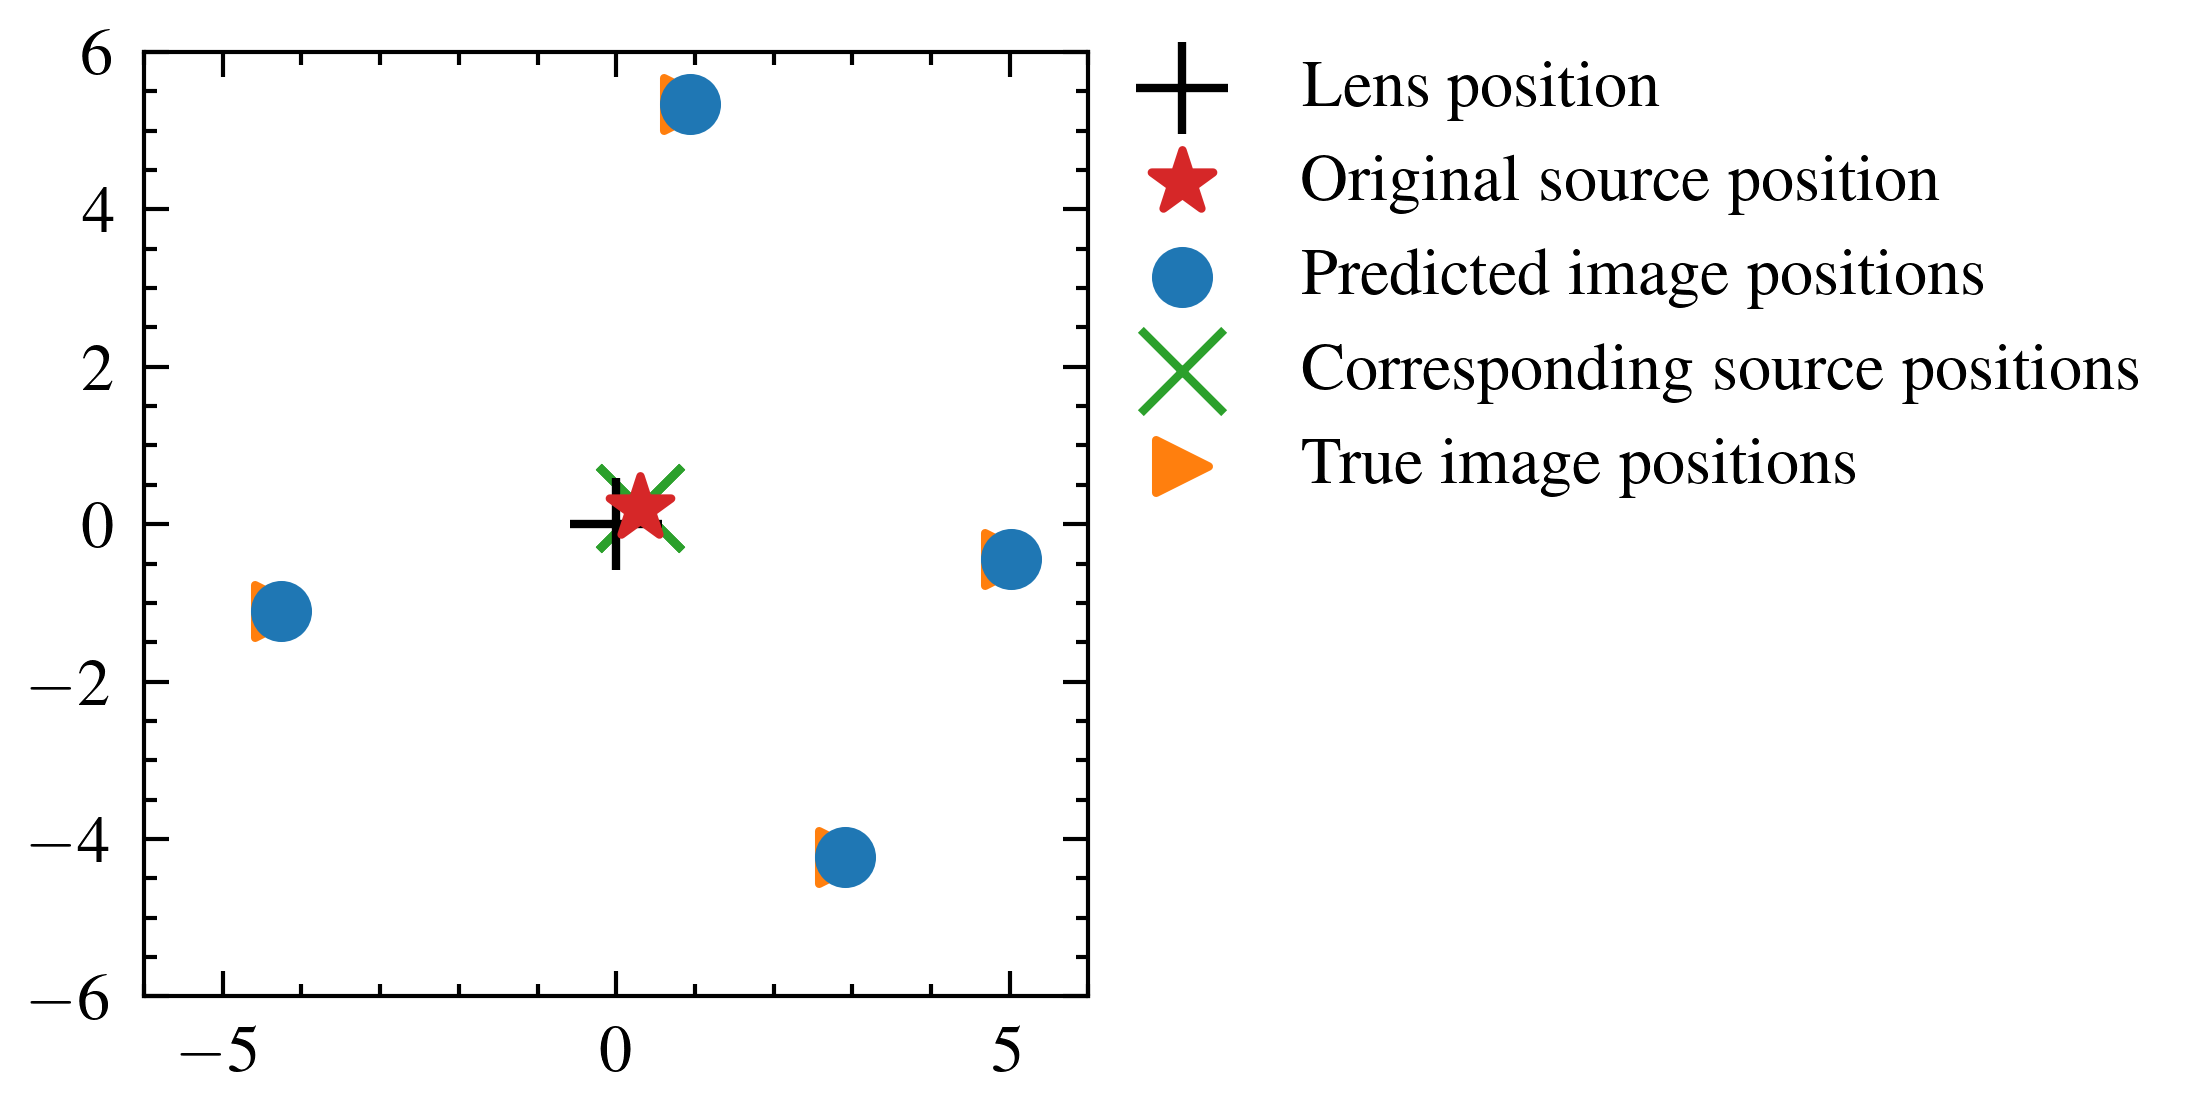

In [21]:
fig, axes = plt.subplots(1, 1)
ax = axes
ax.scatter(kwargs_lens_true_sie_shear[0]['center_x'], kwargs_lens_true_sie_shear[0]['center_y'], 
           c='black', s=120, marker='+', label="Lens position")
ax.scatter(some_beta_x, some_beta_y, c='tab:red', 
           s=60, marker='*', label="Original source position")
ax.scatter(result_theta_x_no_central, result_theta_y_no_central, c='tab:blue', 
           s=40, marker='o', label="Predicted image positions")
ax.scatter(result_beta_x_no_central, result_beta_y_no_central, c='tab:green',
           s=100, marker='x', label="Corresponding source positions", zorder=-1)
ax.scatter(x_image_true, y_image_true, c='tab:orange',
           s=40, marker='>', label="True image positions", zorder=-1)
ax.set_aspect('equal')
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.legend(loc=(1,0.5))
fig.tight_layout()
plt.show()

[{'theta_E': Array([1.04725367], dtype=float64), 'e1': Array([0.04451733], dtype=float64), 'e2': Array([0.04451733], dtype=float64), 'center_x': Array(0., dtype=float64, weak_type=True), 'center_y': Array(0., dtype=float64, weak_type=True)}, {'gamma1': Array([-0.21096535], dtype=float64), 'gamma2': Array([-0.21096535], dtype=float64), 'ra_0': Array(0., dtype=float64, weak_type=True), 'dec_0': Array(0., dtype=float64, weak_type=True)}]
----------------------------------------------------------------------------------------------------
[{'theta_E': 1.0472536738488079, 'e1': 0.044517325057888746, 'e2': 0.044517325057888746, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': -0.2109653498842225, 'gamma2': -0.2109653498842225, 'ra_0': 0.0, 'dec_0': 0.0}]
Helens-images:  [ 0.98333063 -0.00365183  1.07328252  0.98332509] [ 0.43718965  1.51671643 -1.11063874  0.43719193]
Lenstronomy-images:  [ 1.07328275 -0.00365162  0.98333031 -0.46547358] [-1.11063907  1.51671652  0.43719012 -0.18623725]


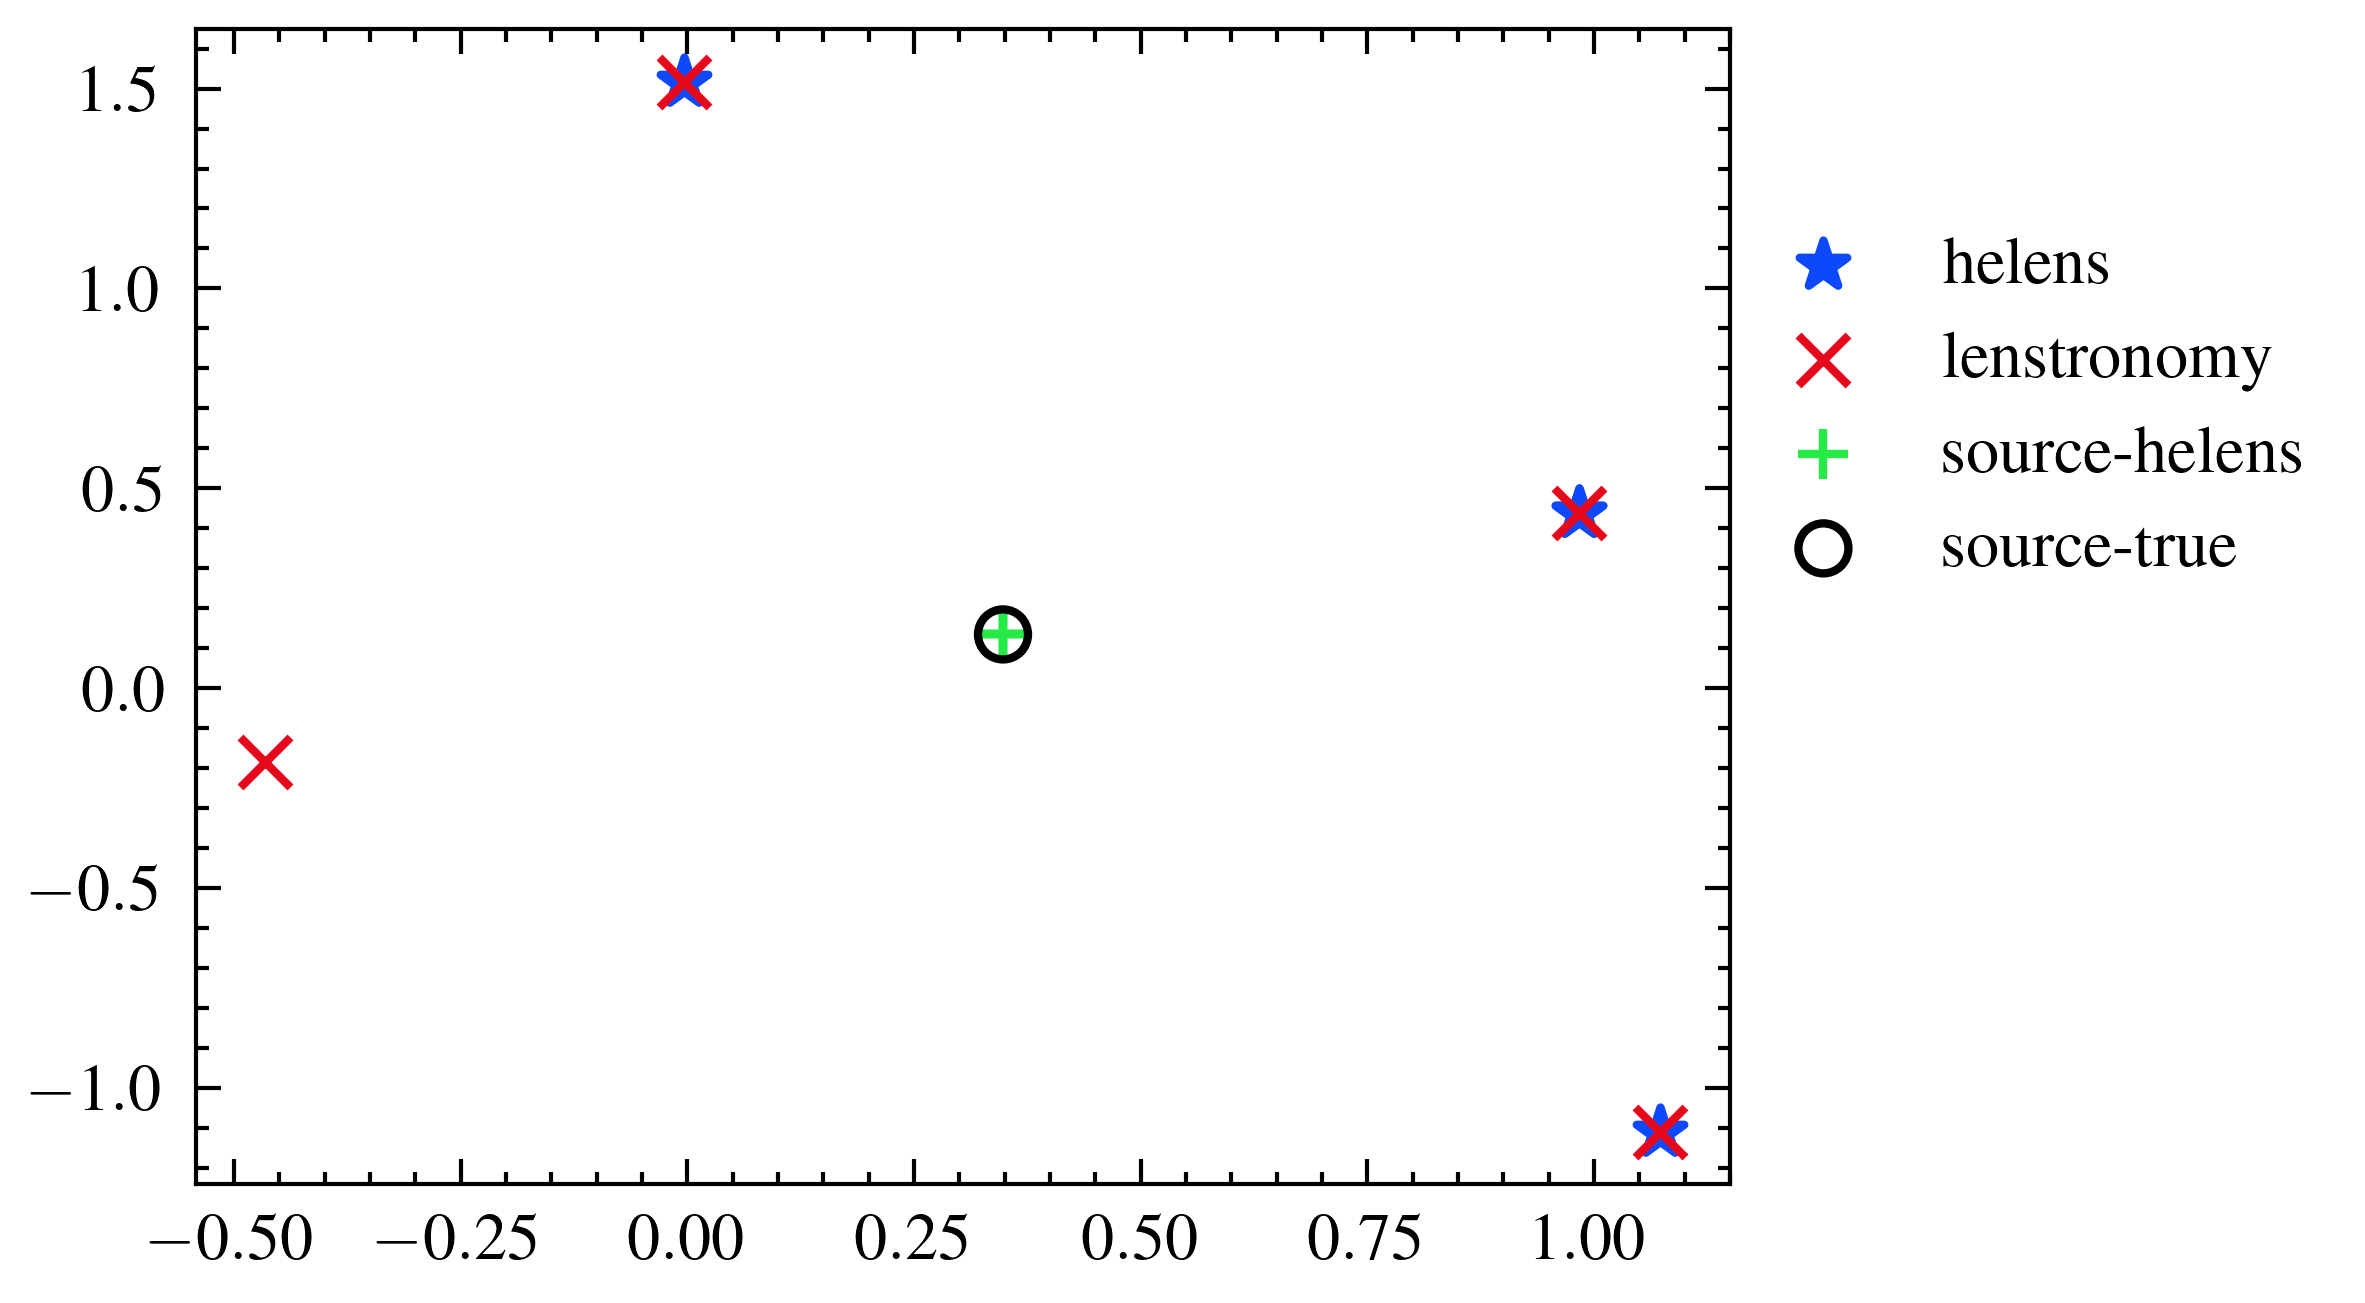

helens-source:  [0.34821441 0.34821423 0.34821412 0.34821001] [0.13423106 0.13423072 0.13423102 0.13422759]
True-source:  0.3482143618675453 0.13423083652573742
No. of images from helens:  4
No. of images from lenstronomy:  4
----------------------------------------------------------------------------------------------------
Helens-images:  [1.14874055 1.14874543 1.14874543 1.14874543] [-1.51780485 -1.51781071 -1.51781071 -1.51781071]
Lenstronomy-images:  [ 1.14874055 -0.47804827] [-1.51780508 -0.02632884]


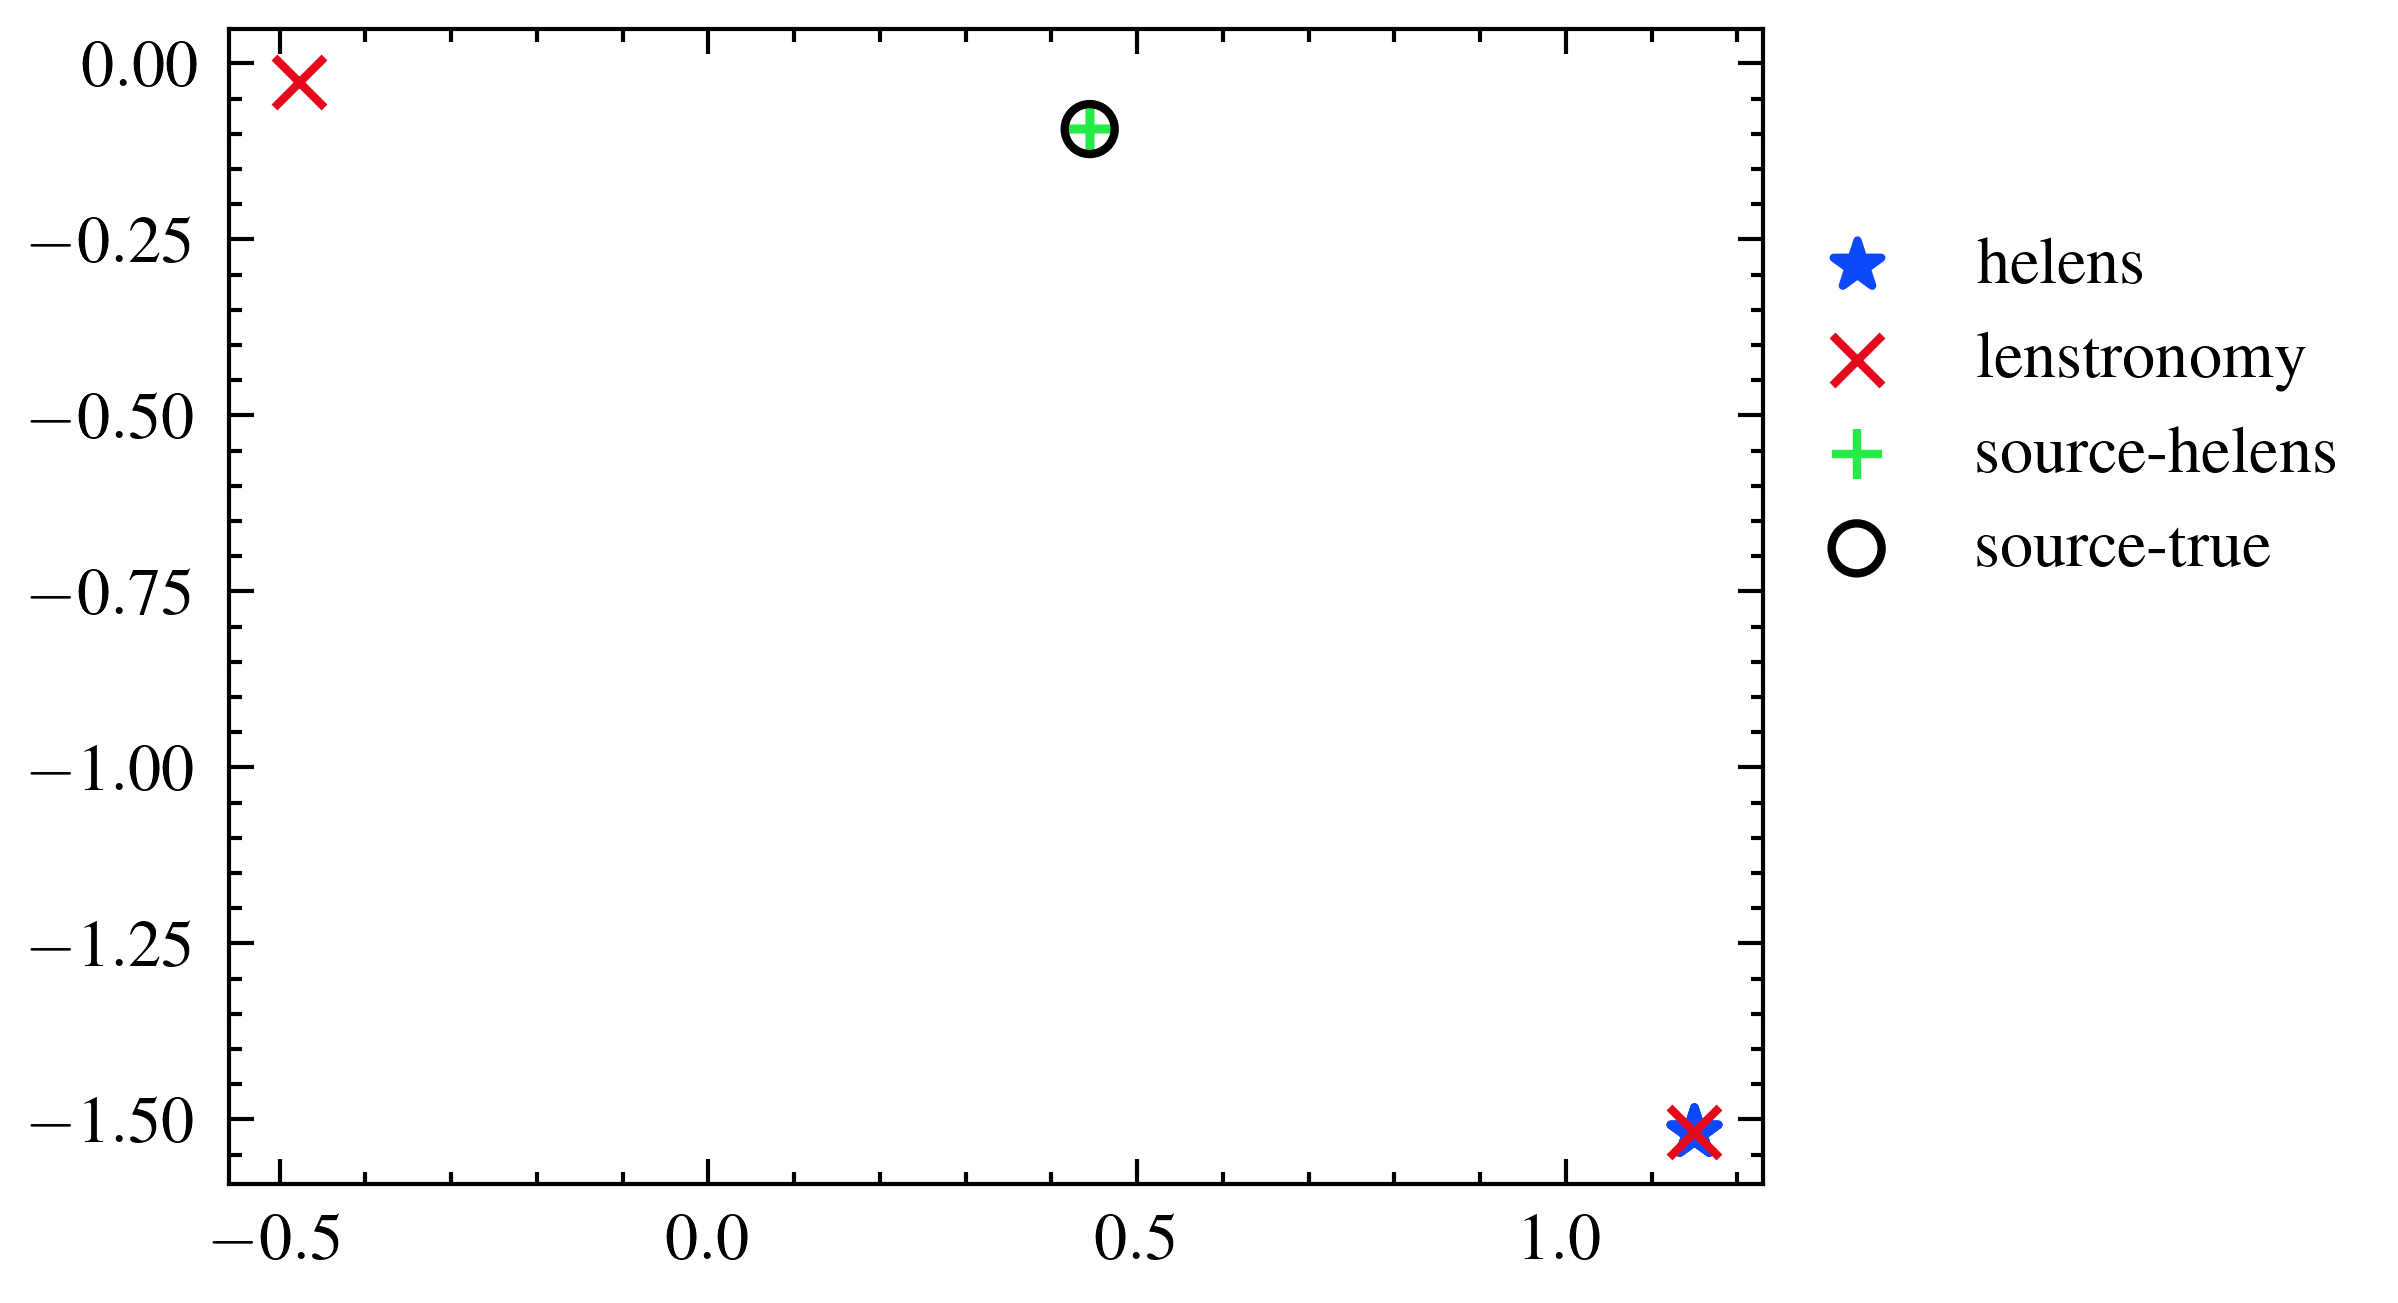

helens-source:  [0.44457146 0.44457599 0.44457599 0.44457599] [-0.0932957  -0.09329941 -0.09329941 -0.09329941]
True-source:  0.44457147627002525 -0.09329583787807194
No. of images from helens:  4
No. of images from lenstronomy:  2
----------------------------------------------------------------------------------------------------
Helens-images:  [-0.17805163  0.29237569  0.29237179  0.29237179] [-1.69699527  0.16443462  0.1644356   0.1644356 ]
Lenstronomy-images:  [-0.17805132  0.29237596] [-1.69699589  0.16443437]


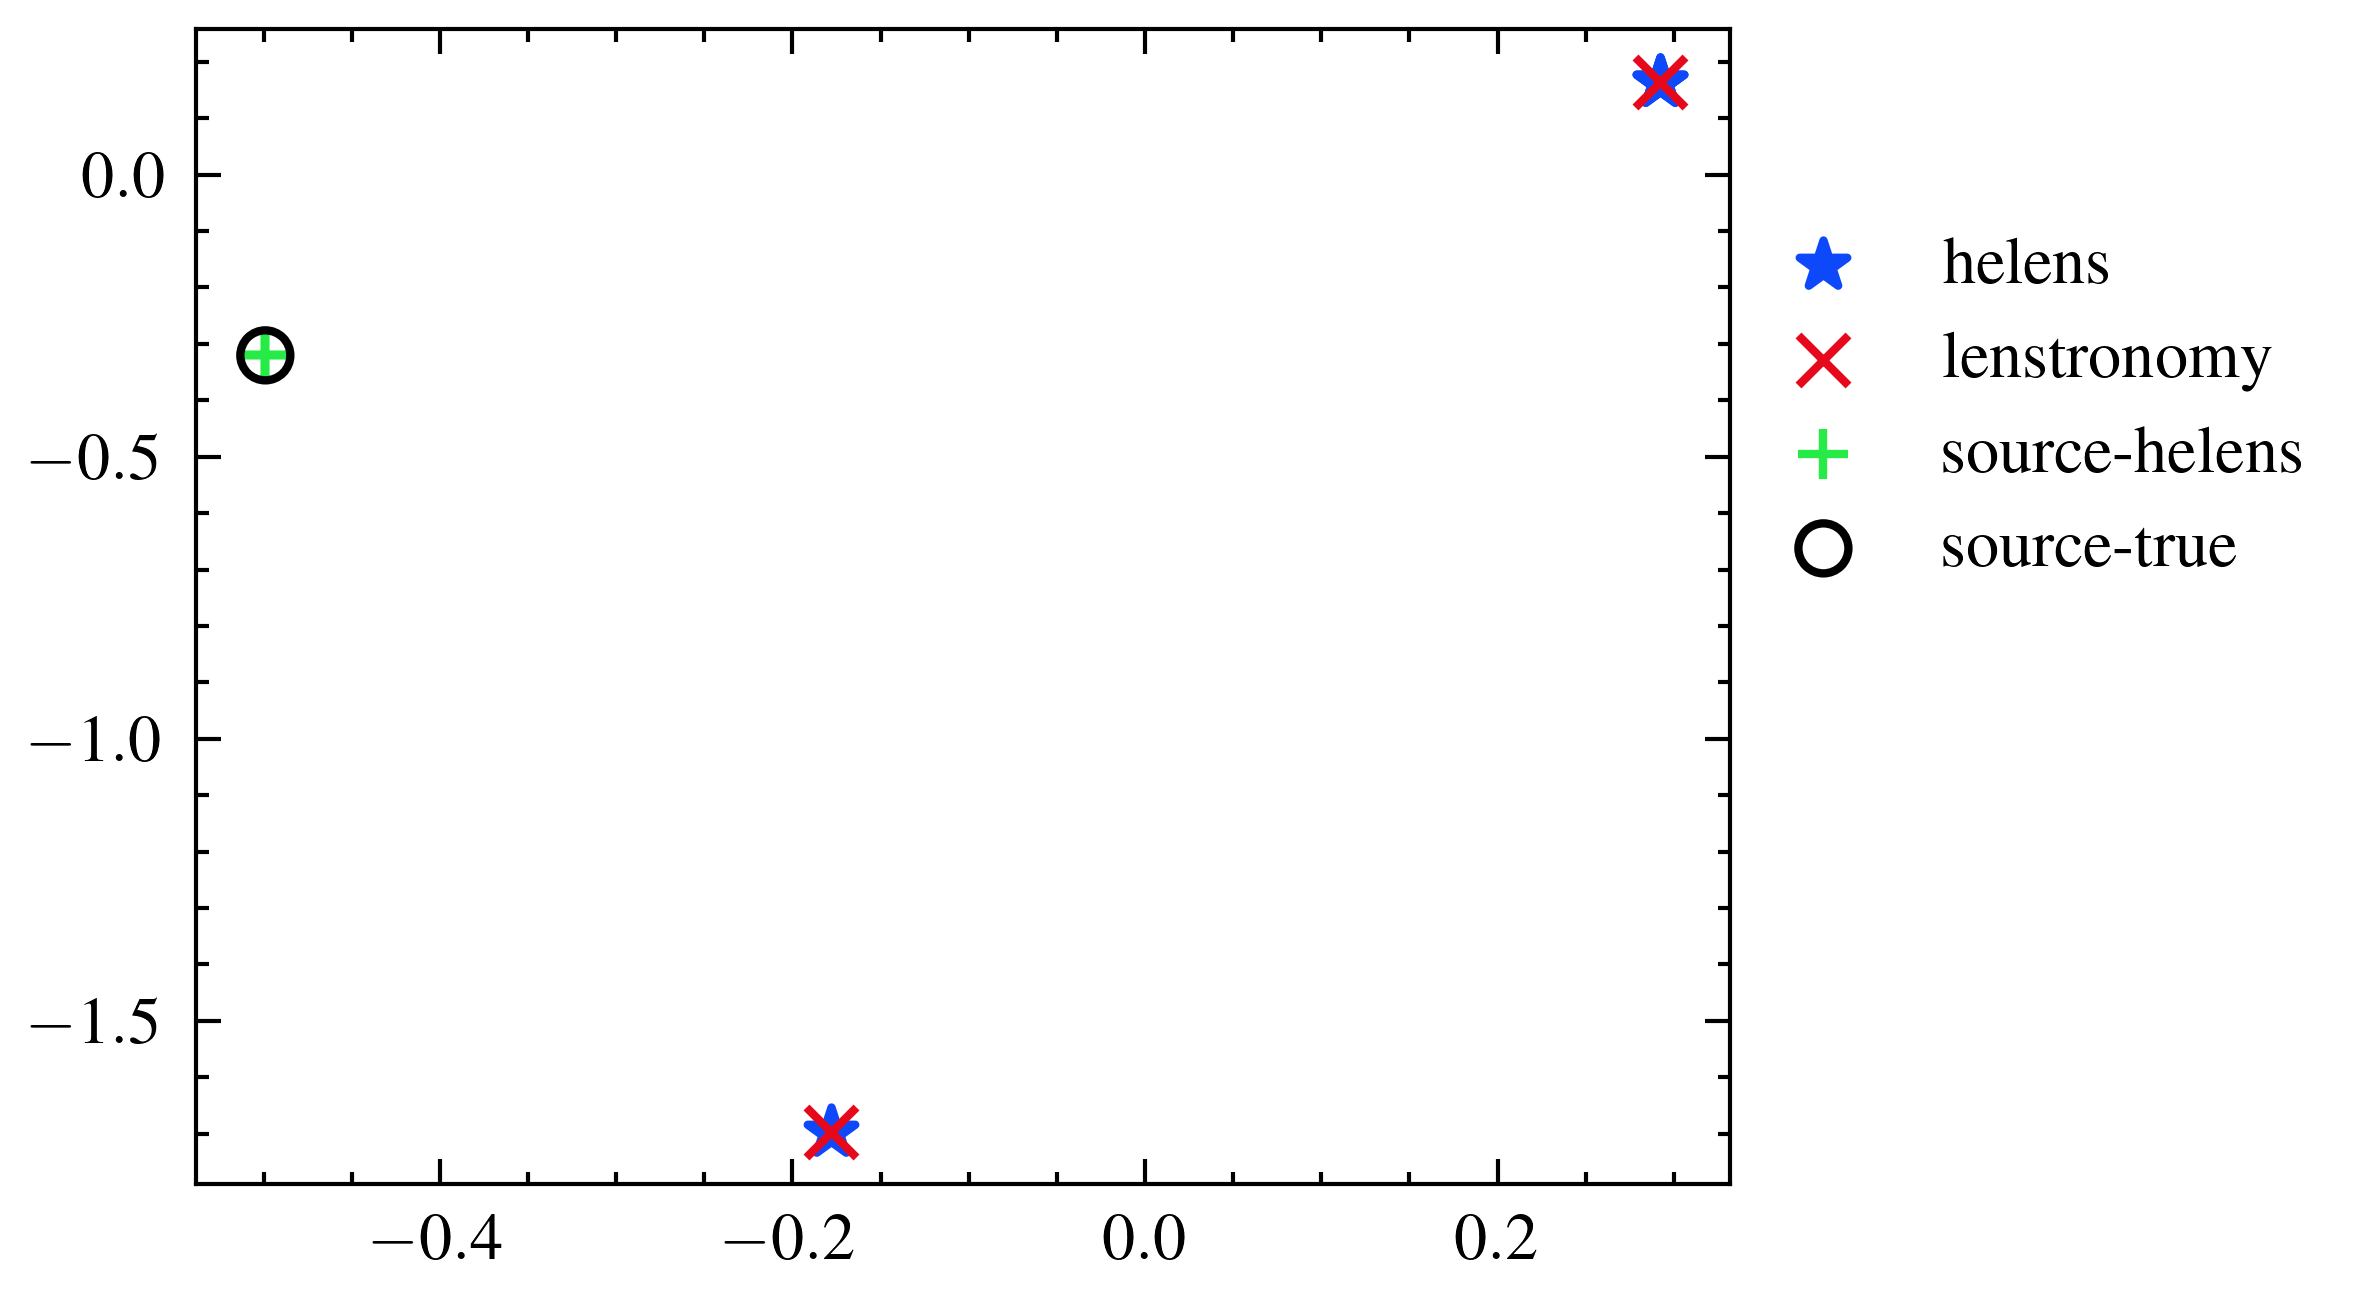

helens-source:  [-0.49907916 -0.49907883 -0.49907886 -0.49907886] [-0.32029856 -0.32029985 -0.3203079  -0.3203079 ]
True-source:  -0.499079142191871 -0.32029896811303815
No. of images from helens:  4
No. of images from lenstronomy:  2
----------------------------------------------------------------------------------------------------
Helens-images:  [ 0.80592293 -0.70366533  0.61339474 -0.2942599 ] [-1.60351497 -0.05487009  0.61066743  1.21357242]
Lenstronomy-images:  [ 0.80592249 -0.29425963  0.61339516 -0.70366507] [-1.60351469  1.2135723   0.61066727 -0.05486984]


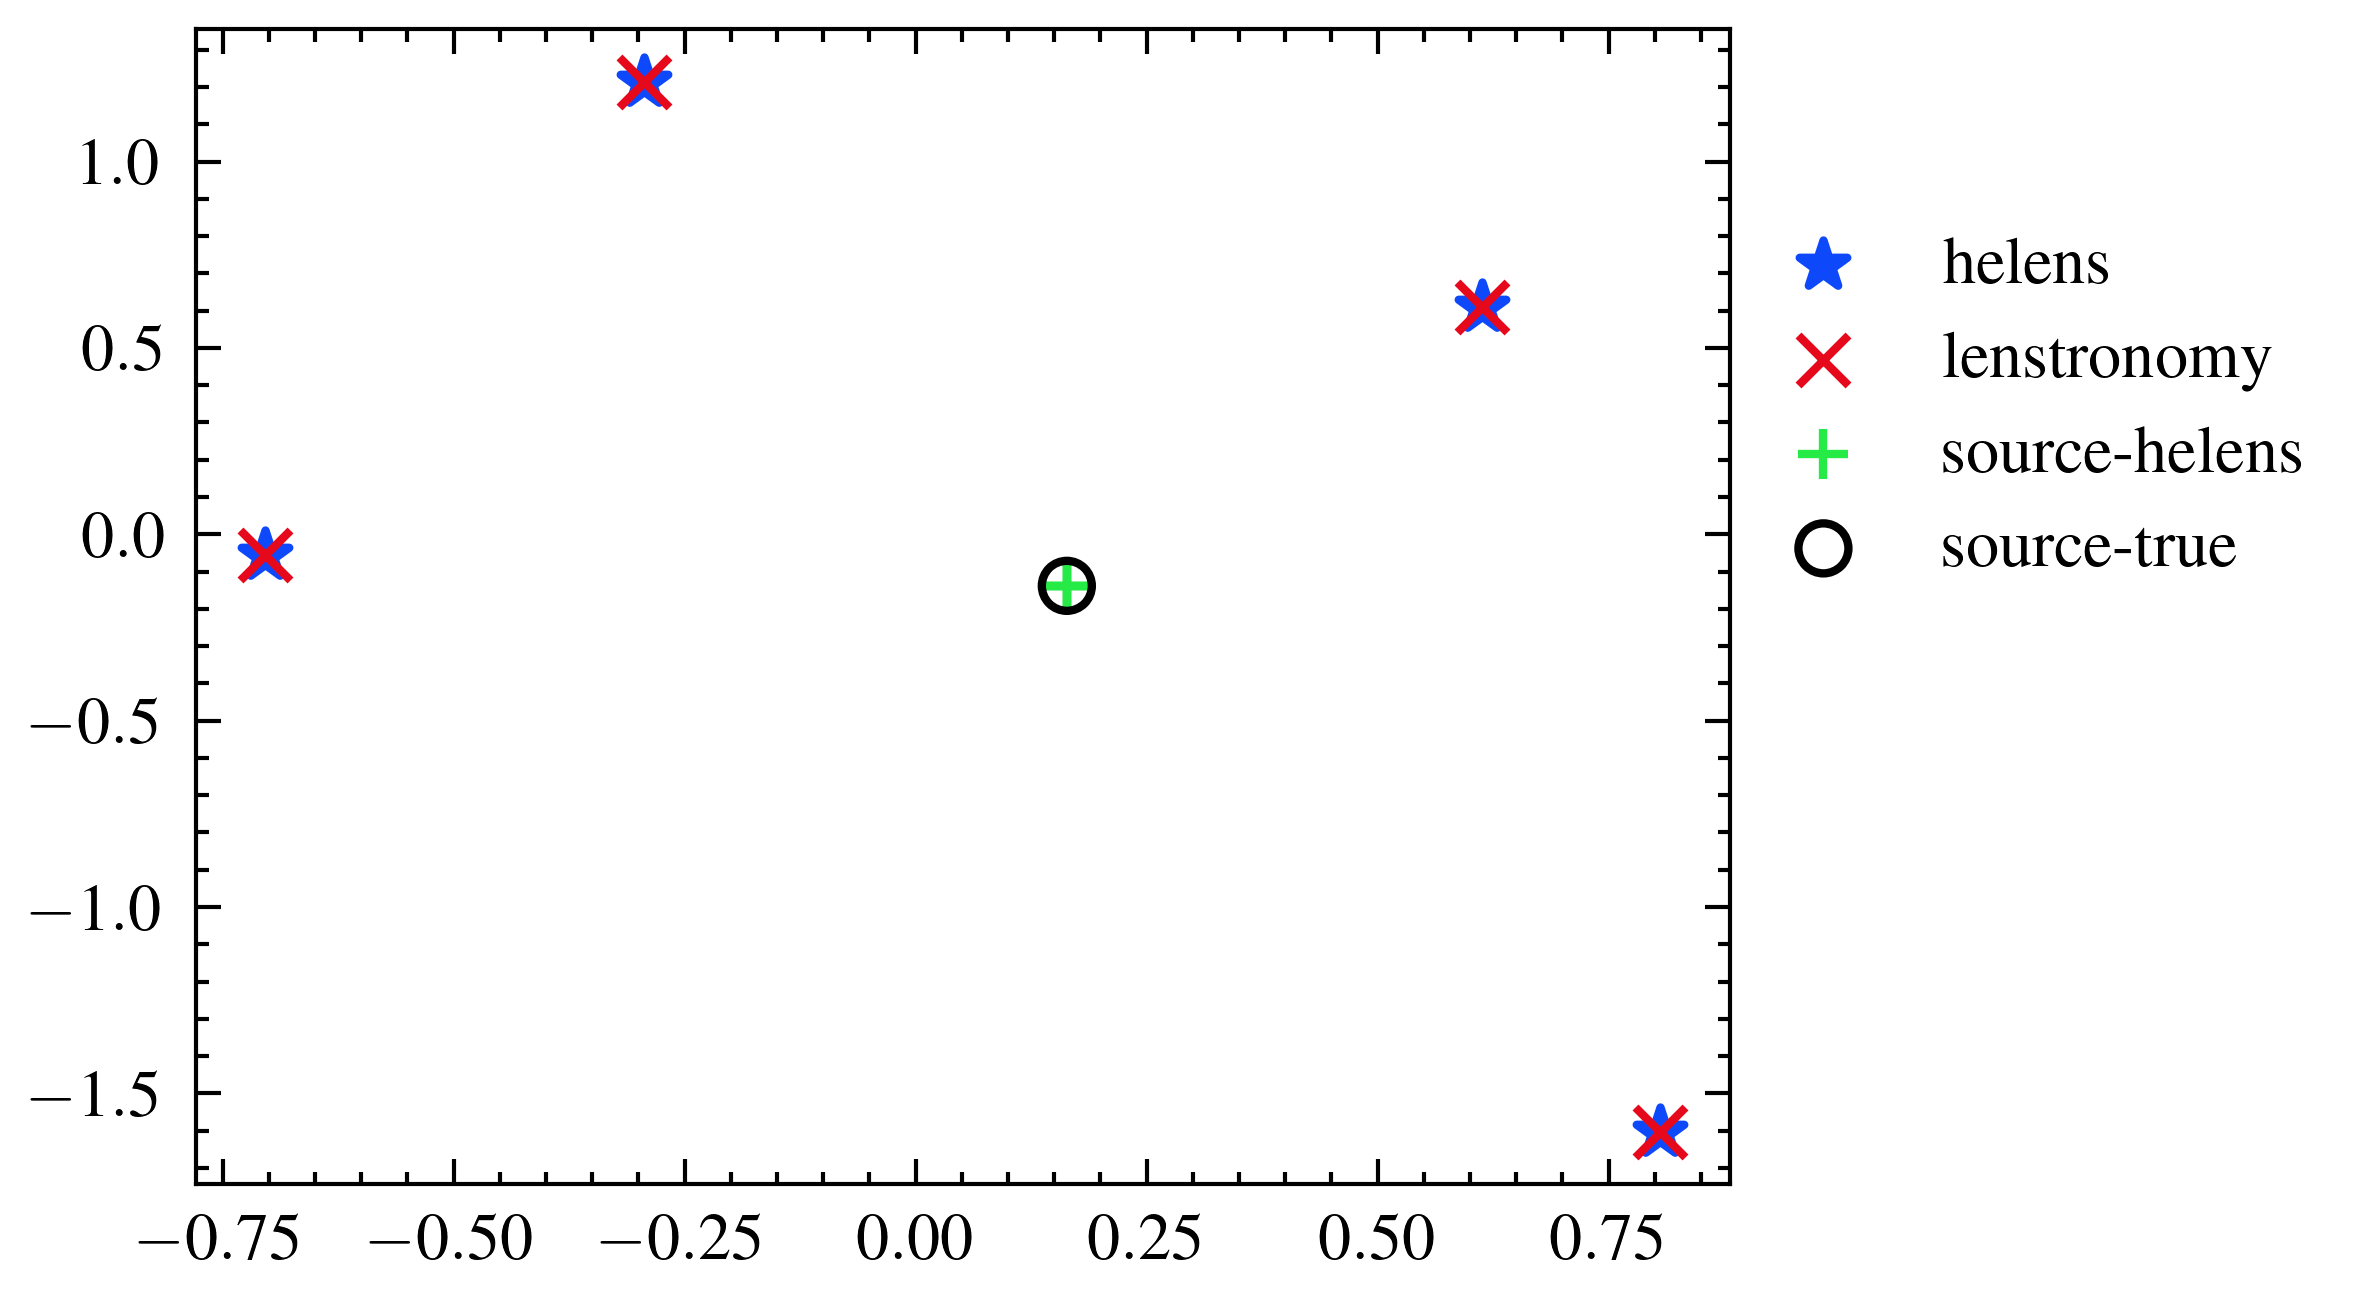

helens-source:  [0.16367295 0.16367221 0.1636725  0.16367249] [-0.13840501 -0.13840471 -0.13840514 -0.13840474]
True-source:  0.16367260954832763 -0.13840481320526288
No. of images from helens:  4
No. of images from lenstronomy:  4
----------------------------------------------------------------------------------------------------
Helens-images:  [0.63853276 0.63853048 0.63853048 0.63853048] [-2.09499748 -2.09500073 -2.09500073 -2.09500073]
Lenstronomy-images:  [0.63853294 0.24124371] [-2.09499788  0.53132808]


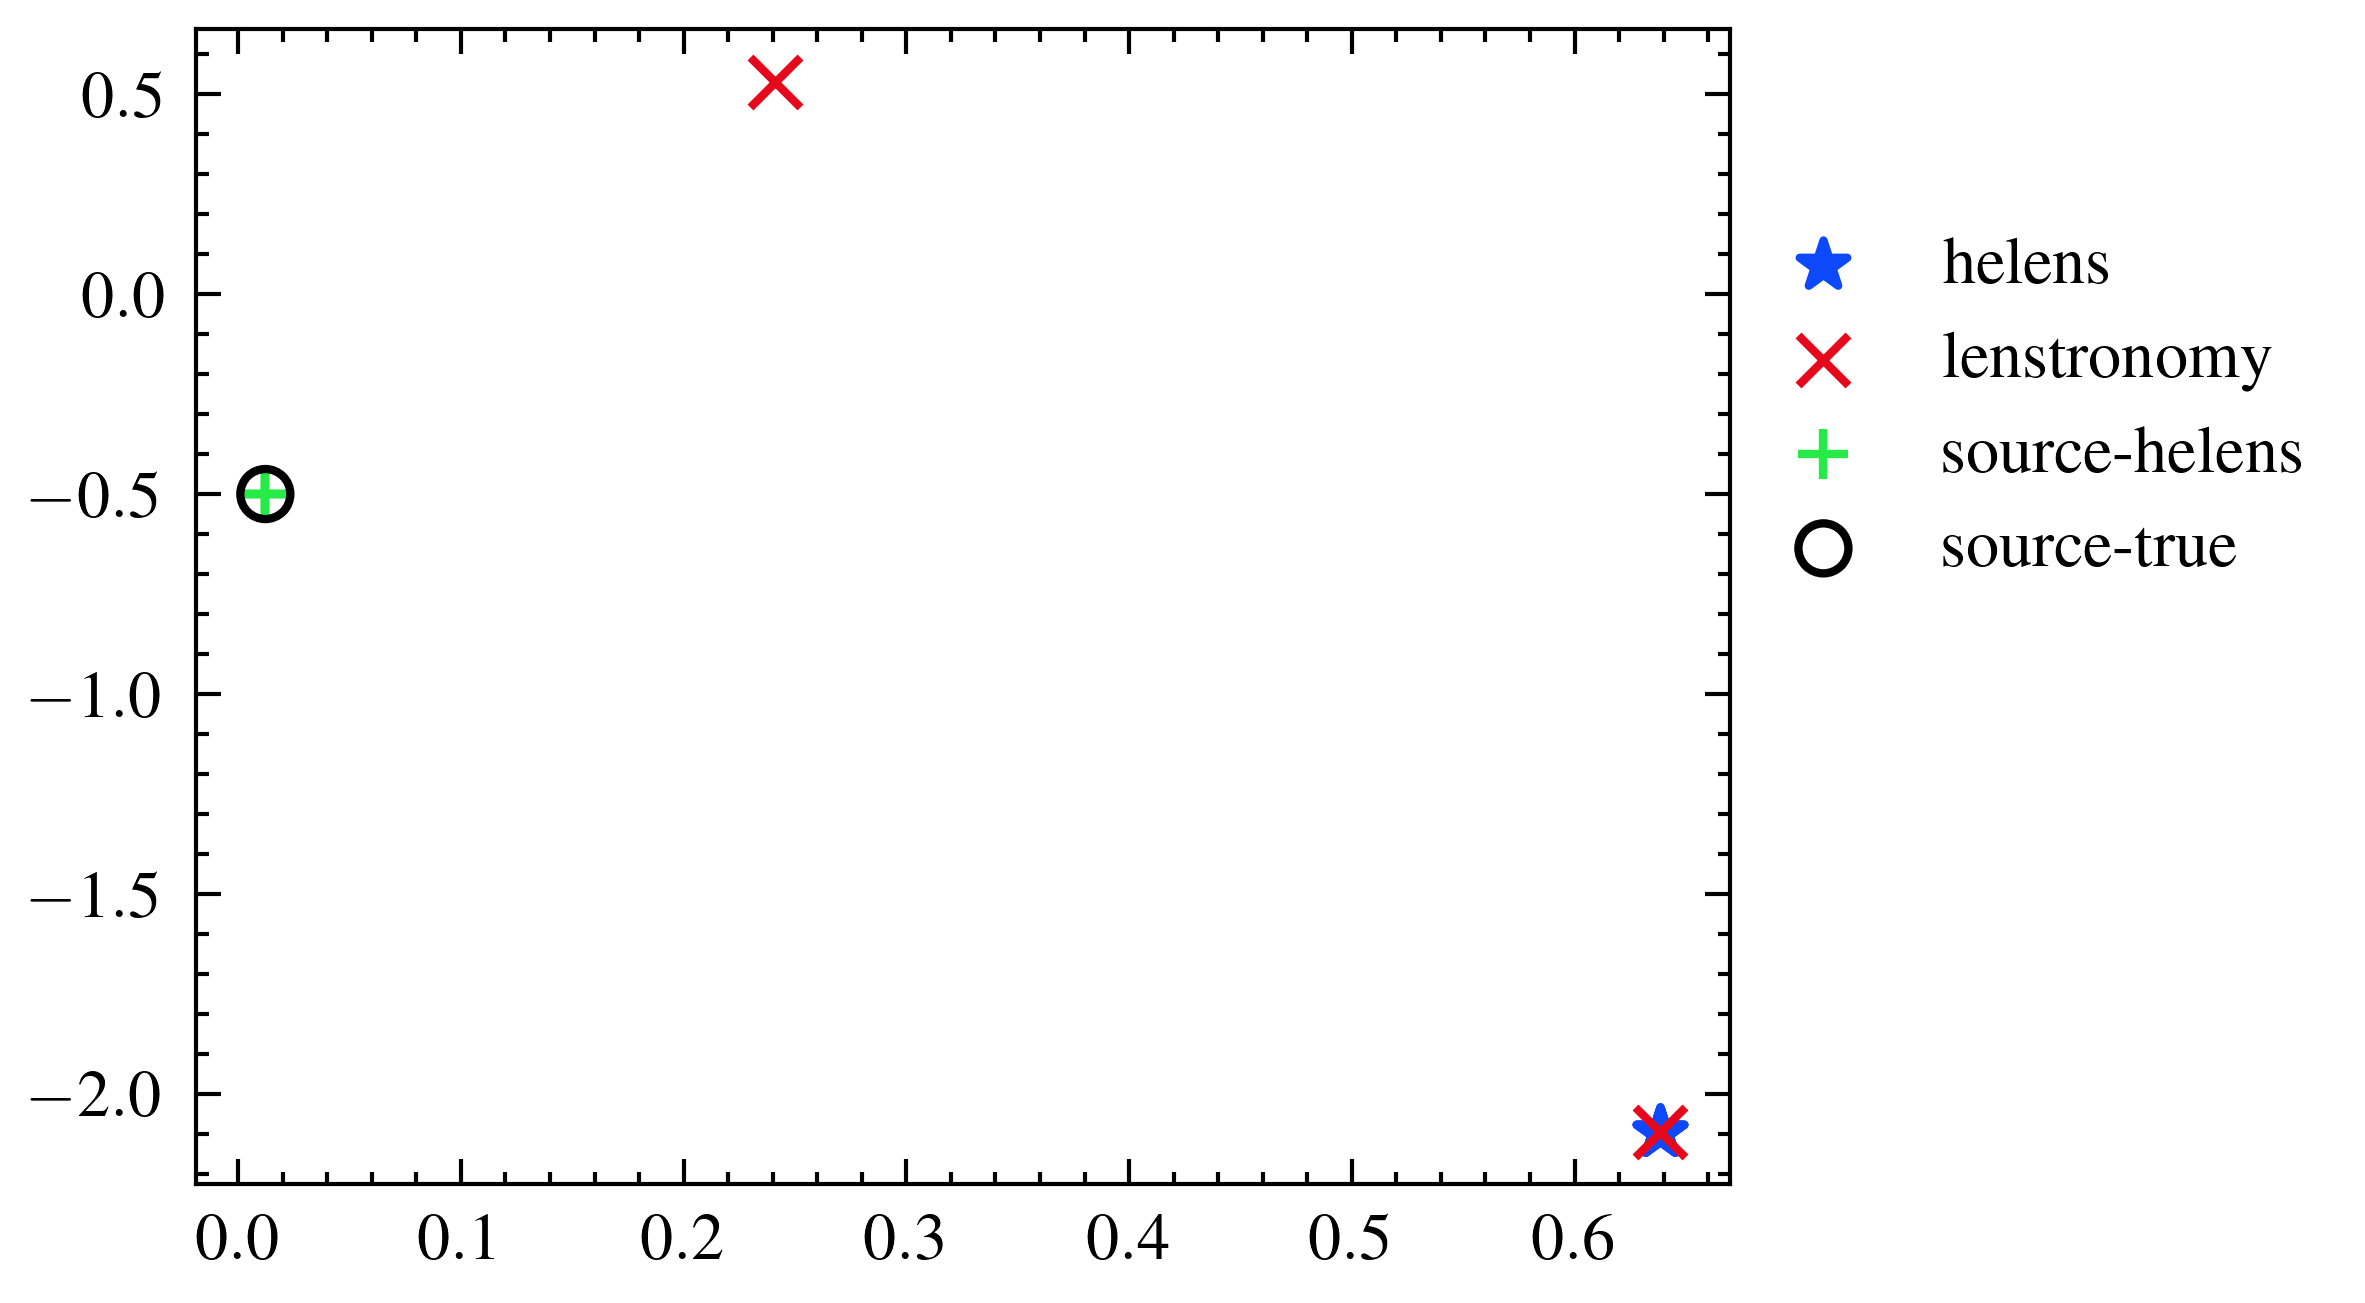

helens-source:  [0.01221418 0.01221208 0.01221208 0.01221208] [-0.49949419 -0.49949683 -0.49949683 -0.49949683]
True-source:  0.012214292841763452 -0.49949448131774643
No. of images from helens:  4
No. of images from lenstronomy:  2
----------------------------------------------------------------------------------------------------
Helens-images:  [-0.39038644  0.62401894 -0.07763156 -0.95052933] [-0.888687   -0.02902683 -1.079124    1.68042019]
Lenstronomy-images:  [-0.95052941 -0.07763171 -0.39038644  0.62401874] [ 1.68041997 -1.0791236  -0.88868707 -0.02902655]


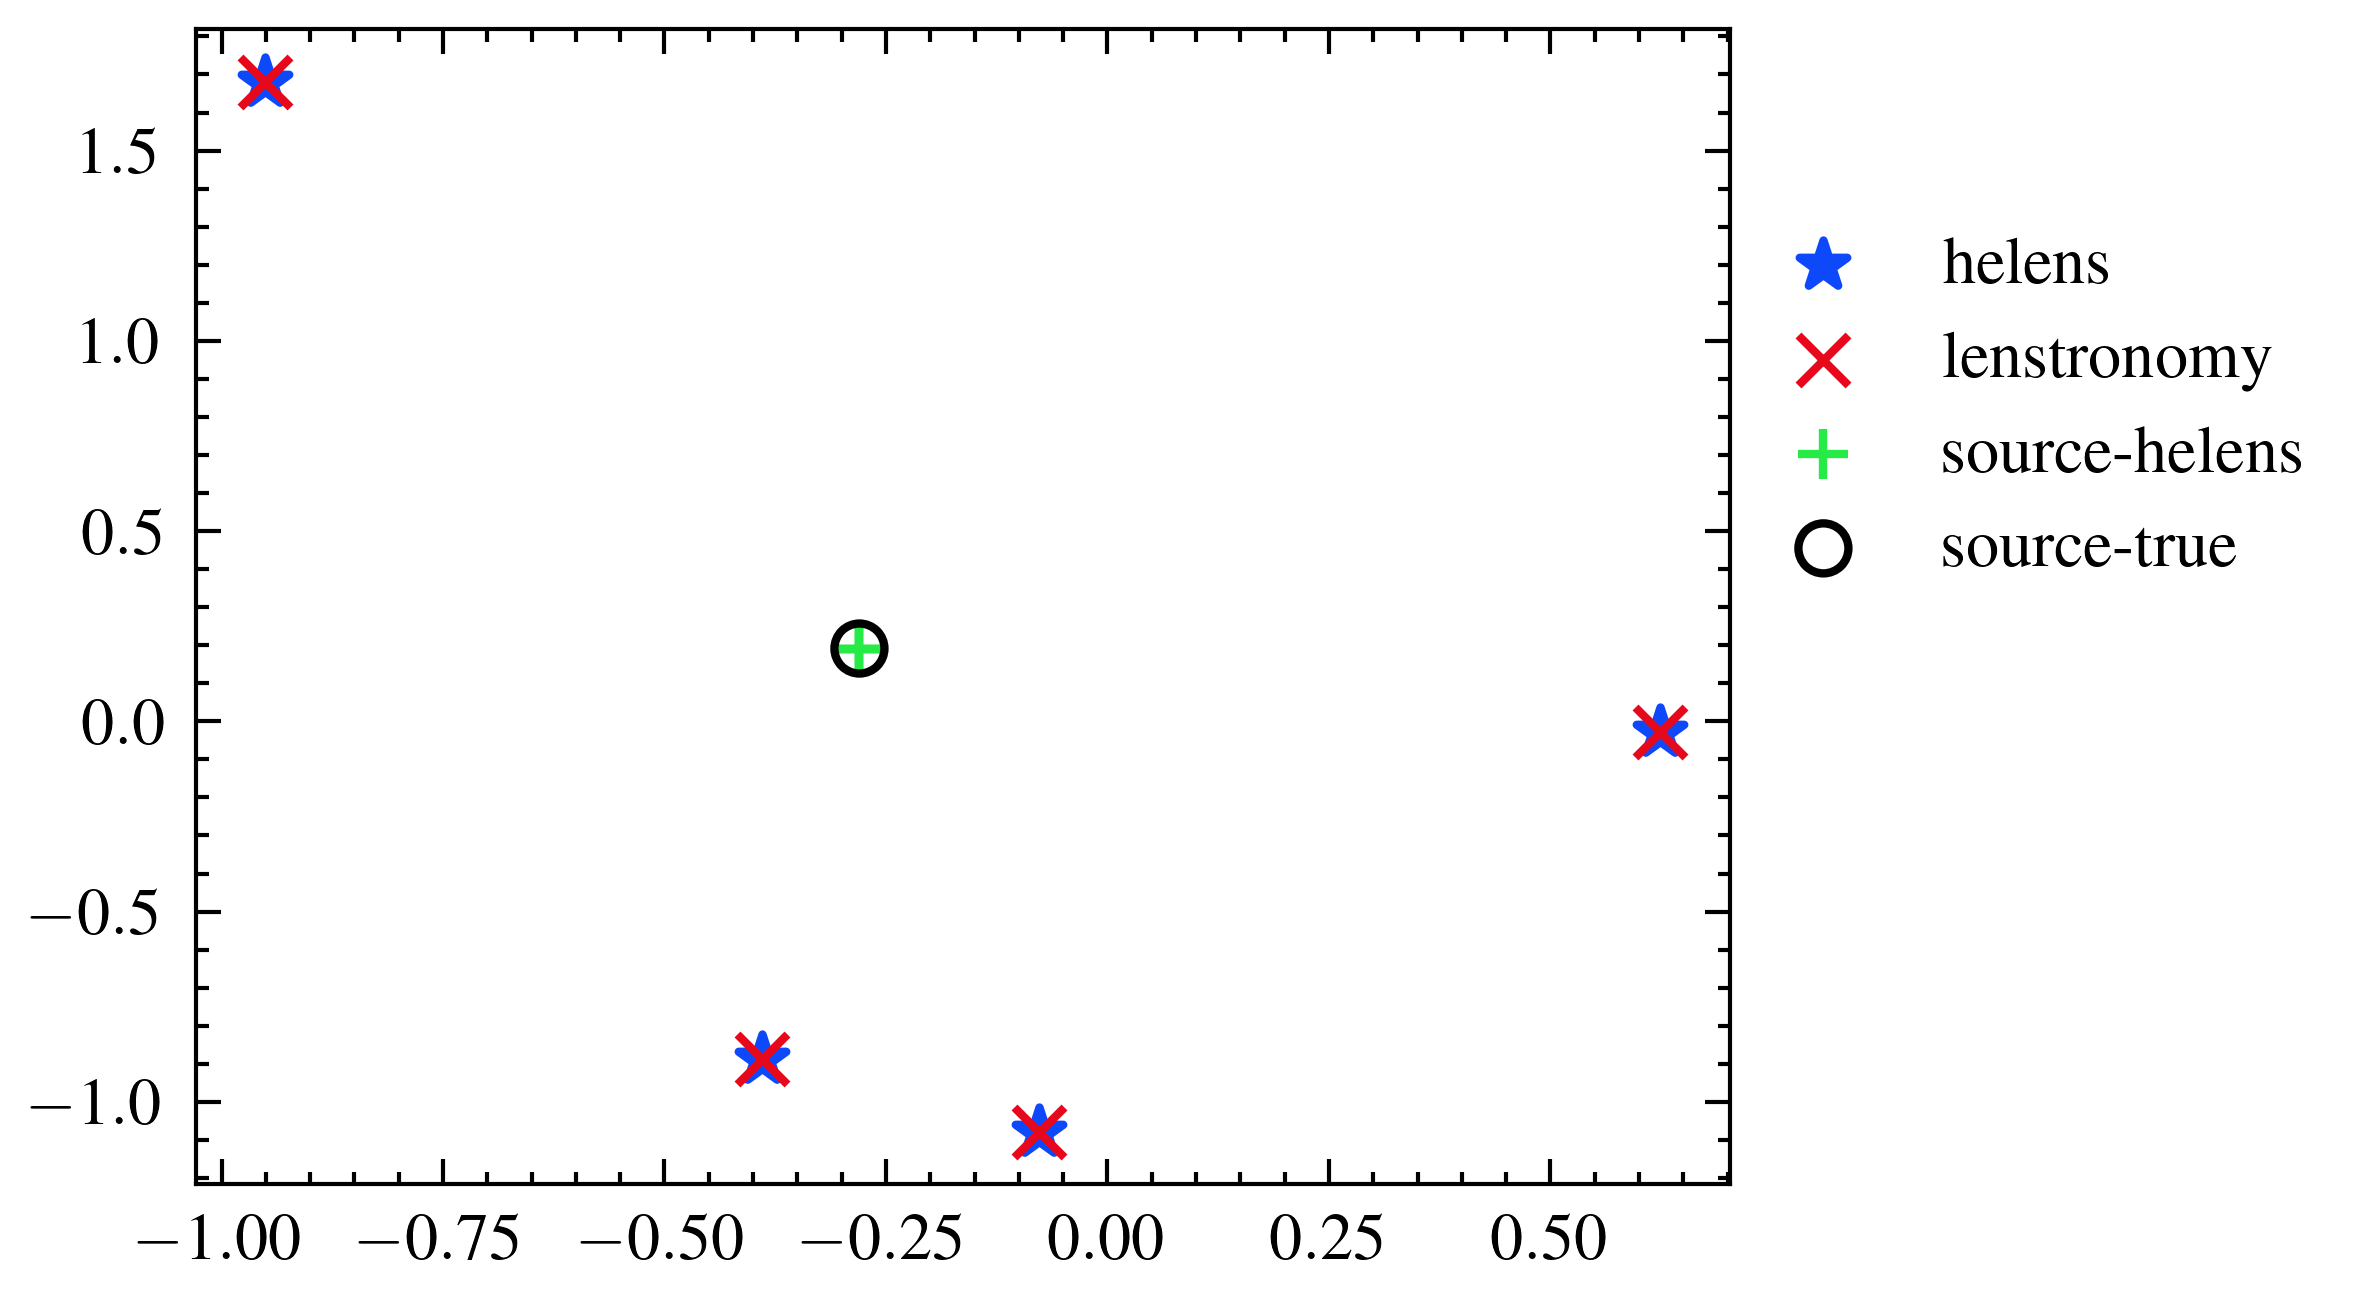

helens-source:  [-0.27996694 -0.27996678 -0.27996704 -0.27996691] [0.19131253 0.19131279 0.19131222 0.19131264]
True-source:  -0.27996697886706867 0.19131248566857328
No. of images from helens:  4
No. of images from lenstronomy:  4
----------------------------------------------------------------------------------------------------
Helens-images:  [0.48965409 0.48965312 0.48965312 0.48965312] [-2.00254417 -2.00254319 -2.00254319 -2.00254319]
Lenstronomy-images:  [0.48965429 0.32289913] [-2.00254392  0.44165774]


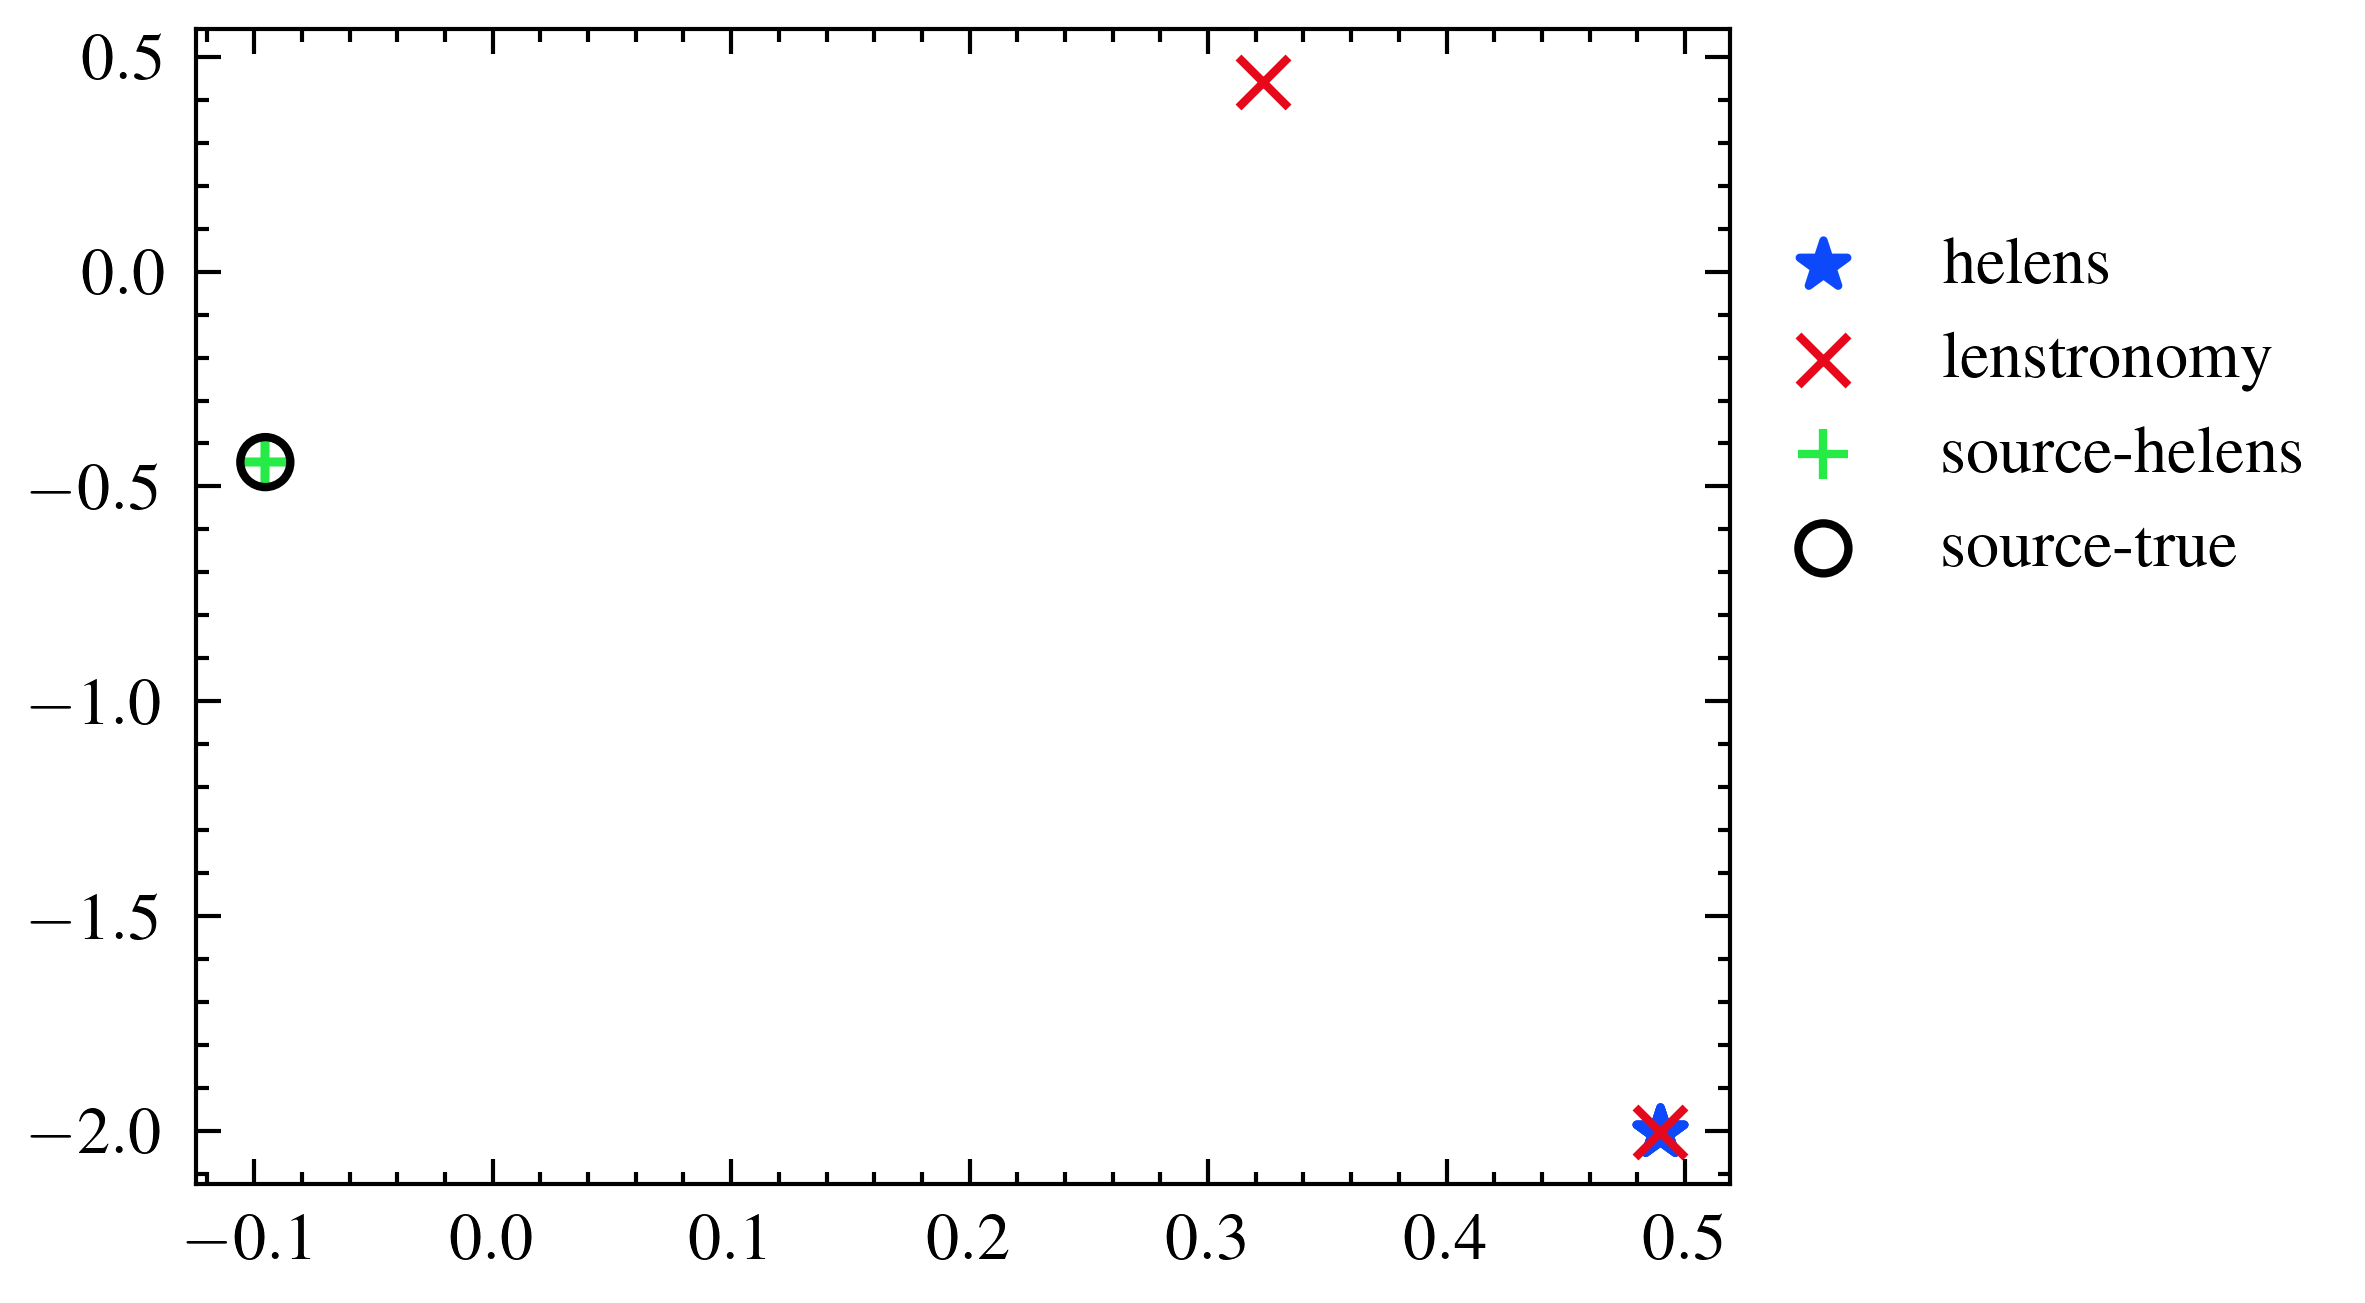

helens-source:  [-0.09534898 -0.09534962 -0.09534962 -0.09534962] [-0.44334949 -0.44334885 -0.44334885 -0.44334885]
True-source:  -0.09534880193994999 -0.4433492813657096
No. of images from helens:  4
No. of images from lenstronomy:  2
----------------------------------------------------------------------------------------------------
Helens-images:  [-0.88136801  0.16591498 -0.62782735  0.65269104] [ 1.56590595 -1.23361279 -0.67168082  0.06226548]
Lenstronomy-images:  [-0.88136773  0.16591483 -0.62782765  0.65269132] [ 1.56590548 -1.23361253 -0.67168092  0.06226524]


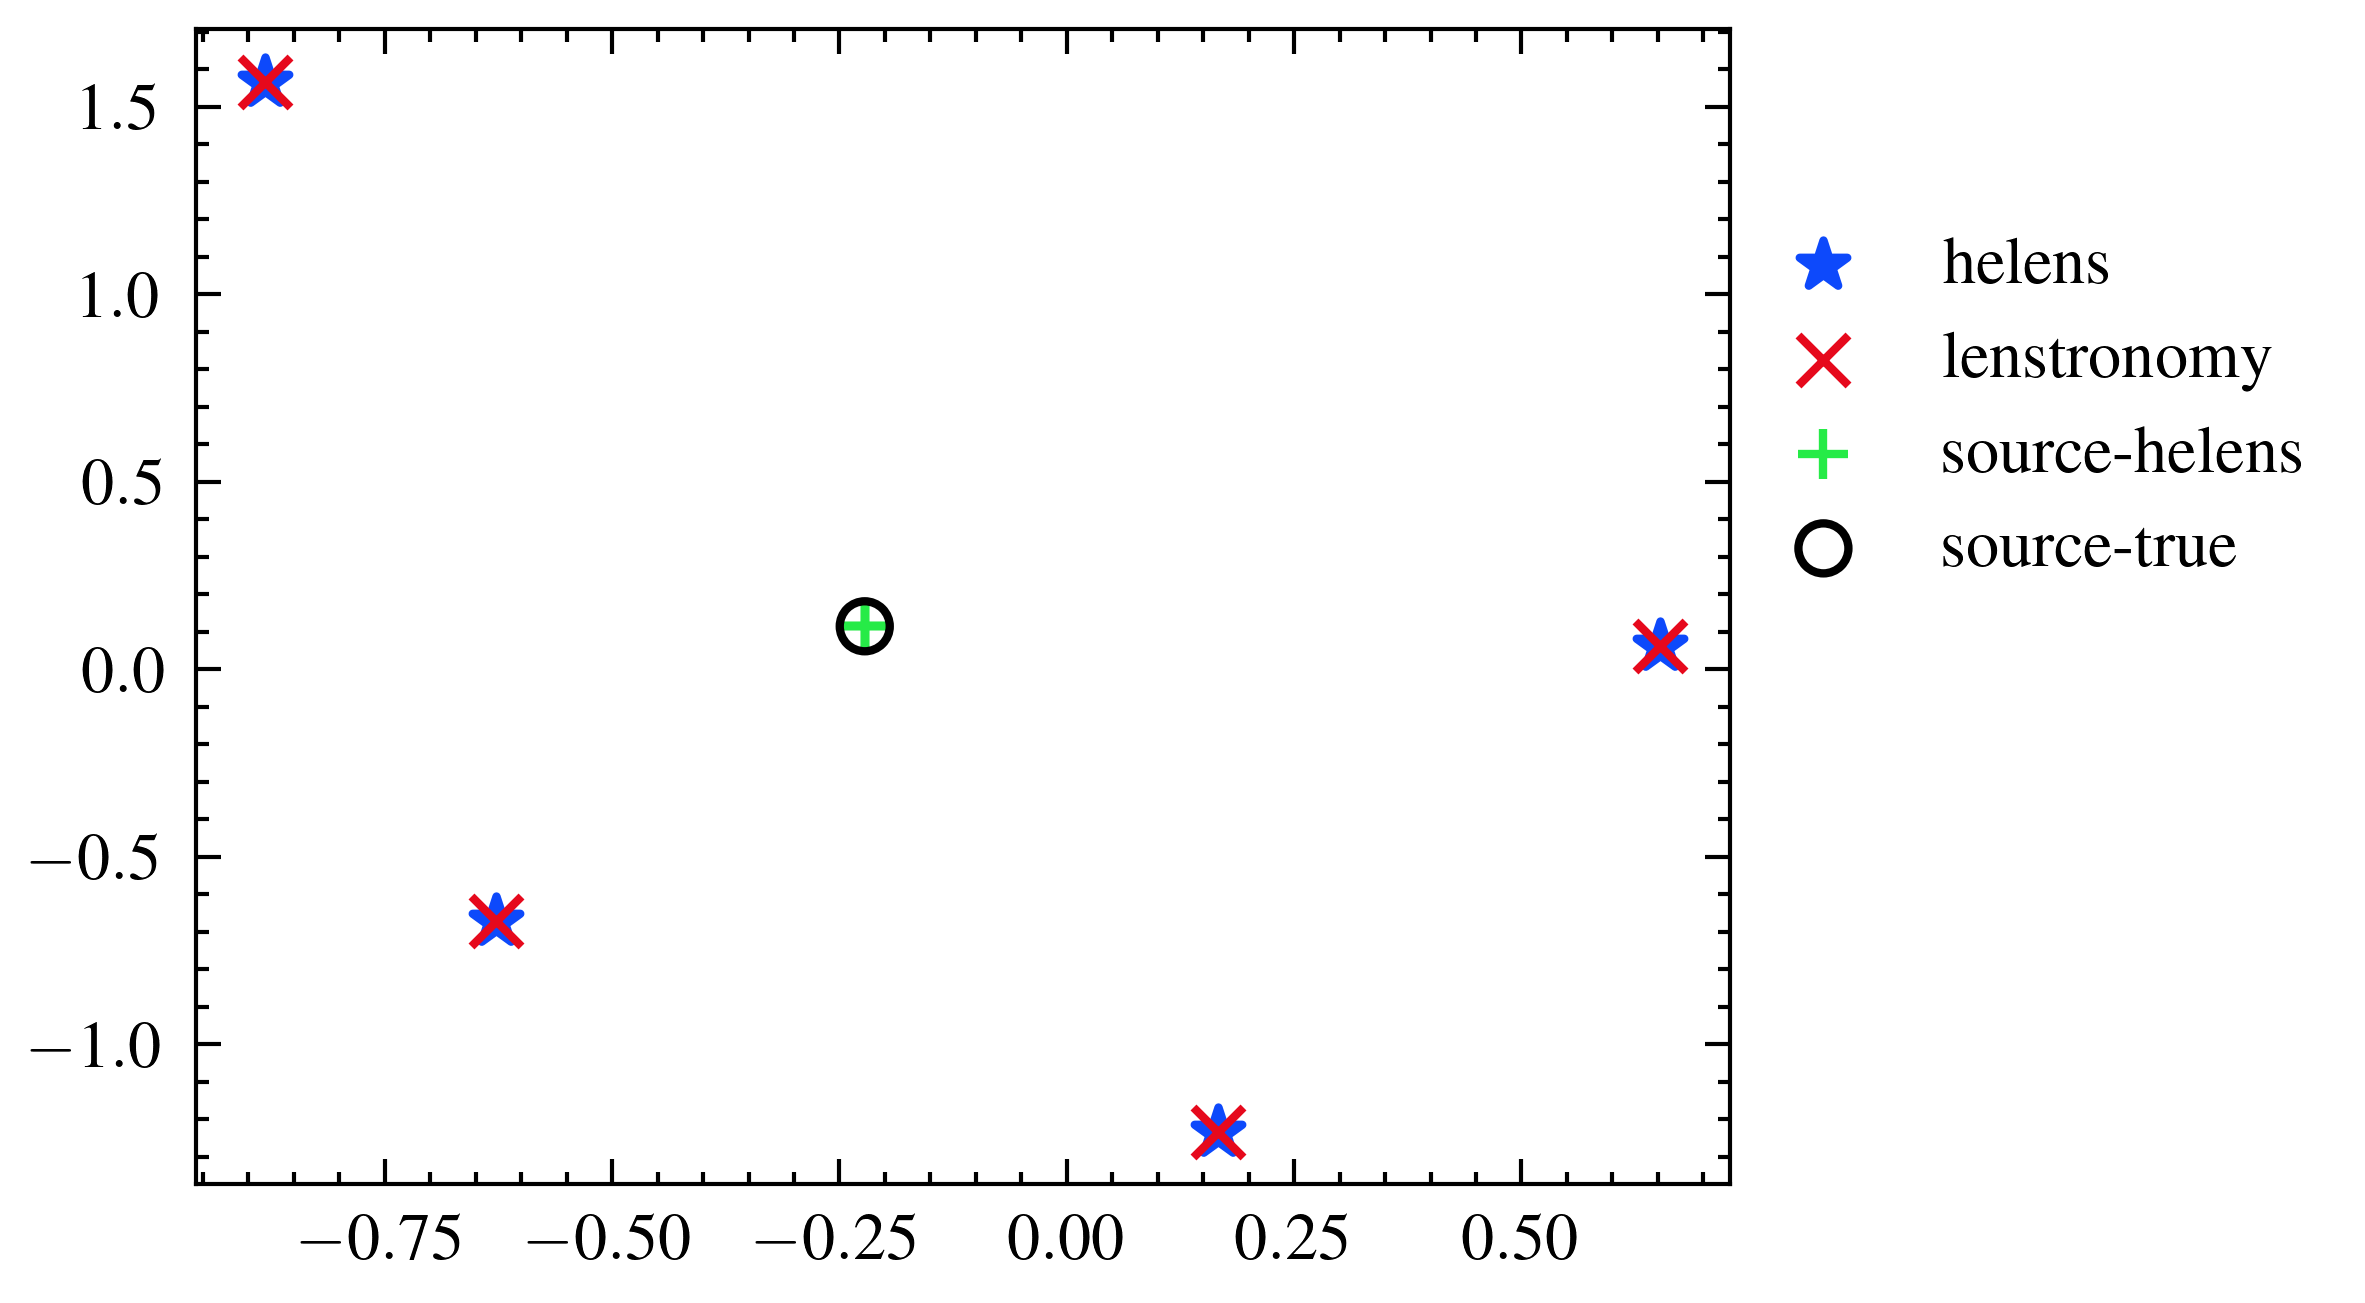

helens-source:  [-0.22219595 -0.22219568 -0.22219547 -0.22219597] [0.11451925 0.11451875 0.11451919 0.11451861]
True-source:  -0.22219572056567105 0.11451893031043103
No. of images from helens:  4
No. of images from lenstronomy:  4
----------------------------------------------------------------------------------------------------
Helens-images:  [-1.18064469 -1.18064567 -1.18064567 -1.18064567] [1.93661302 1.93661107 1.93661107 1.93661107]
Lenstronomy-images:  [-1.18064478  0.43333161] [ 1.9366132  -0.15428547]


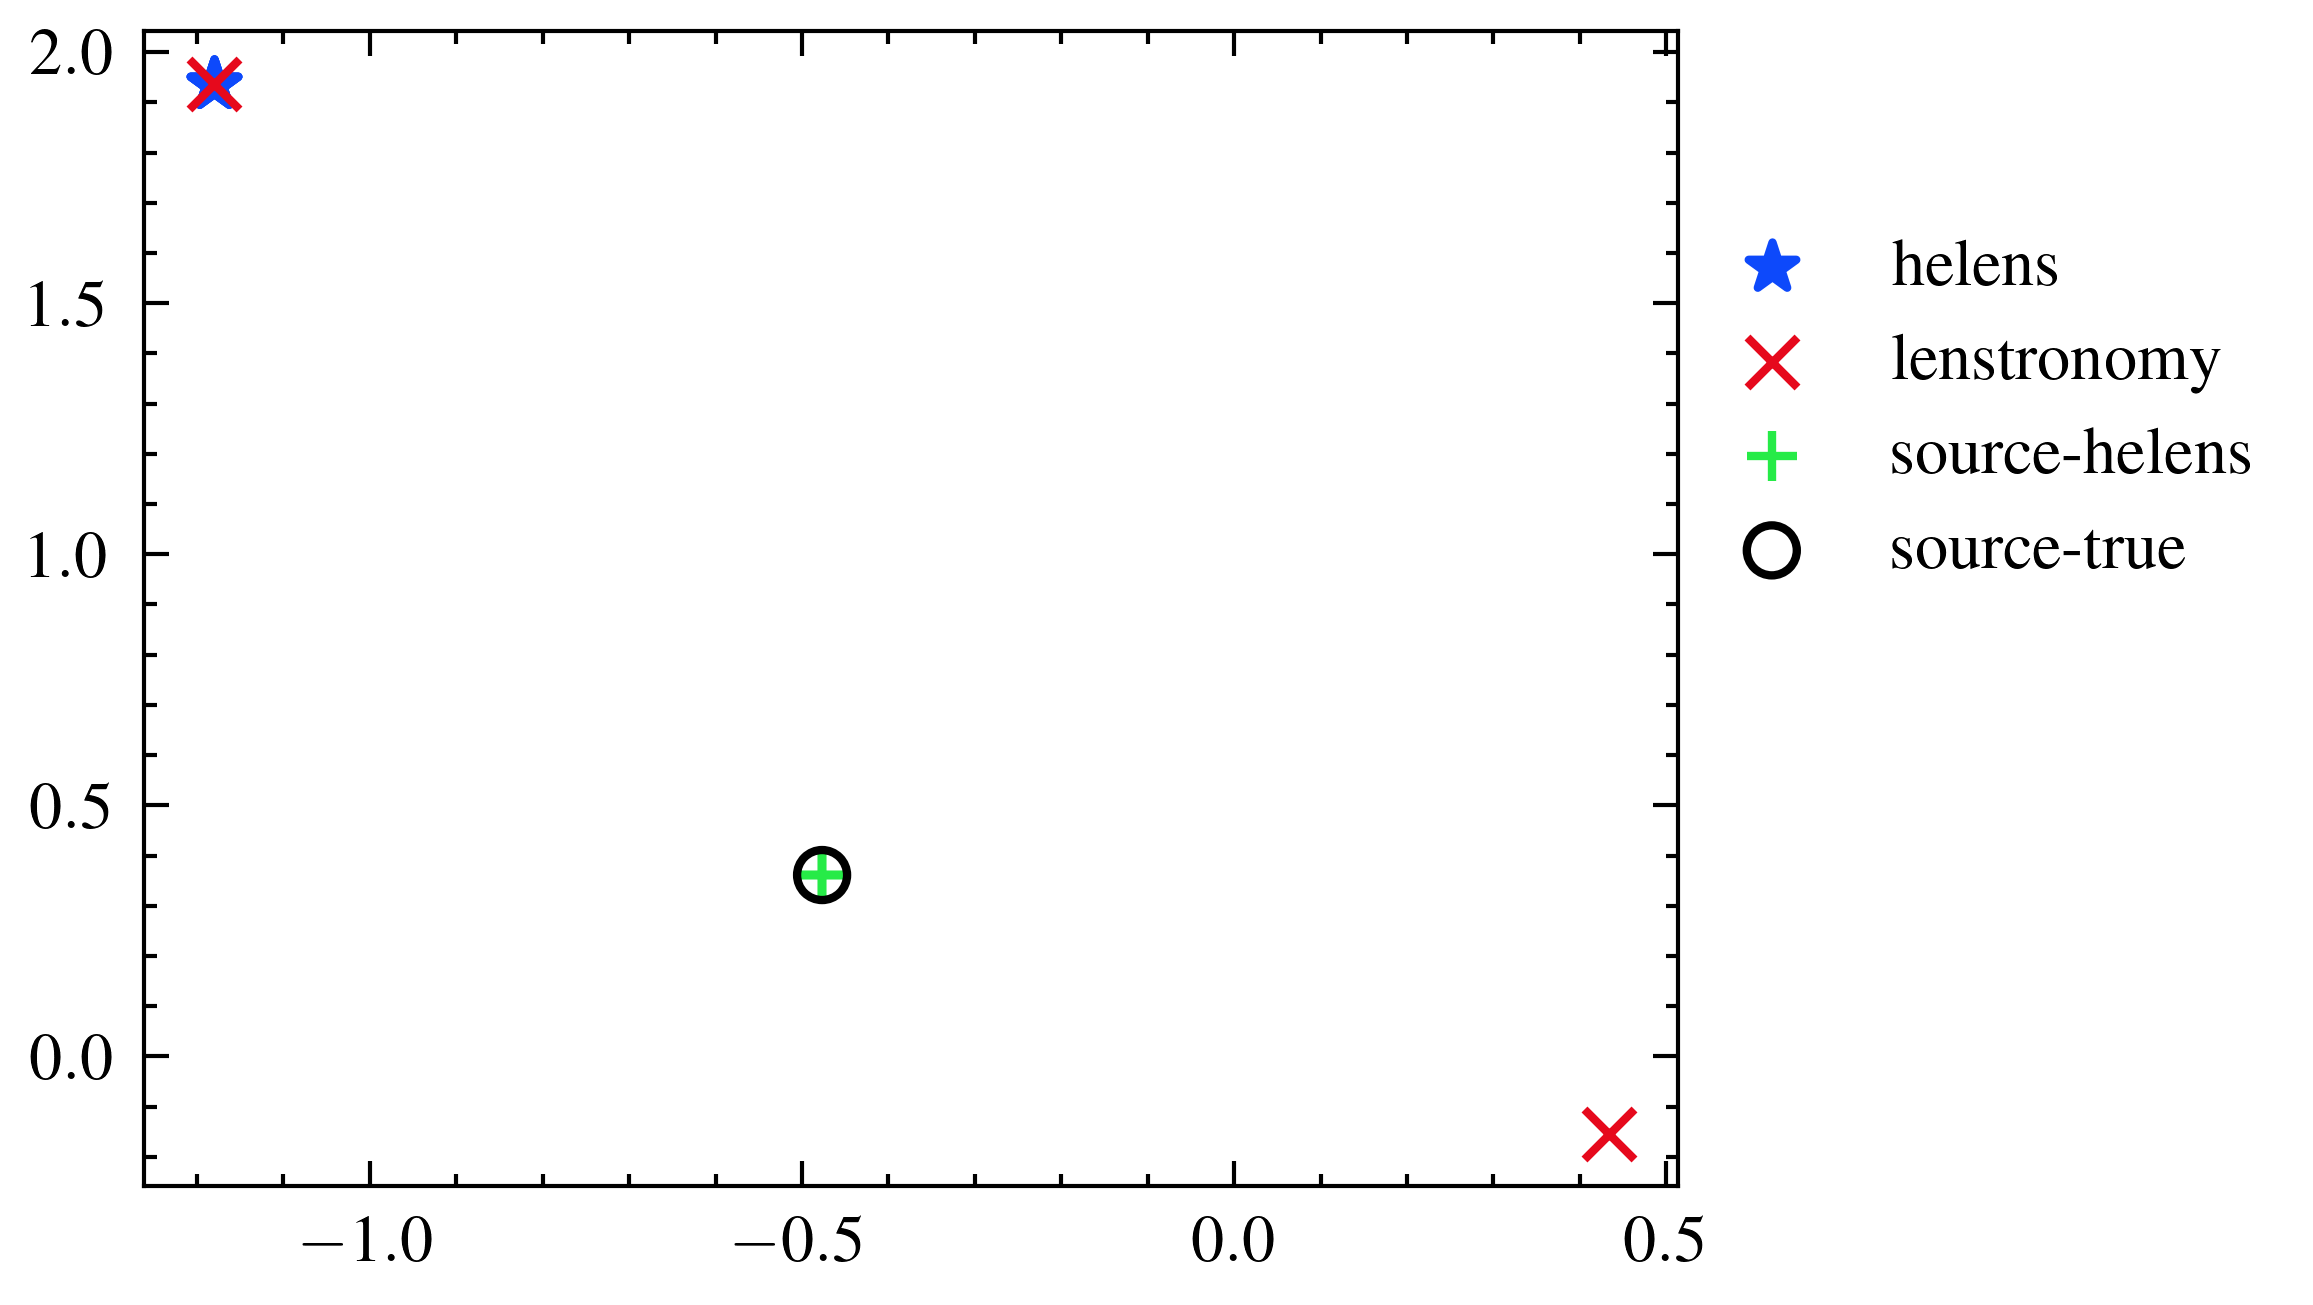

helens-source:  [-0.47679799 -0.4767989  -0.4767989  -0.4767989 ] [0.36123202 0.36123069 0.36123069 0.36123069]
True-source:  -0.47679806412572145 0.3612321391547928
No. of images from helens:  4
No. of images from lenstronomy:  2
----------------------------------------------------------------------------------------------------
Helens-images:  [-0.05351325  1.02687659  0.93725942  0.93725291] [ 1.49111528 -1.18134805  0.46110187  0.46110806]
Lenstronomy-images:  [ 1.02687662 -0.05351301  0.93725917 -0.49903338] [-1.18134829  1.49111483  0.4611023  -0.18752575]


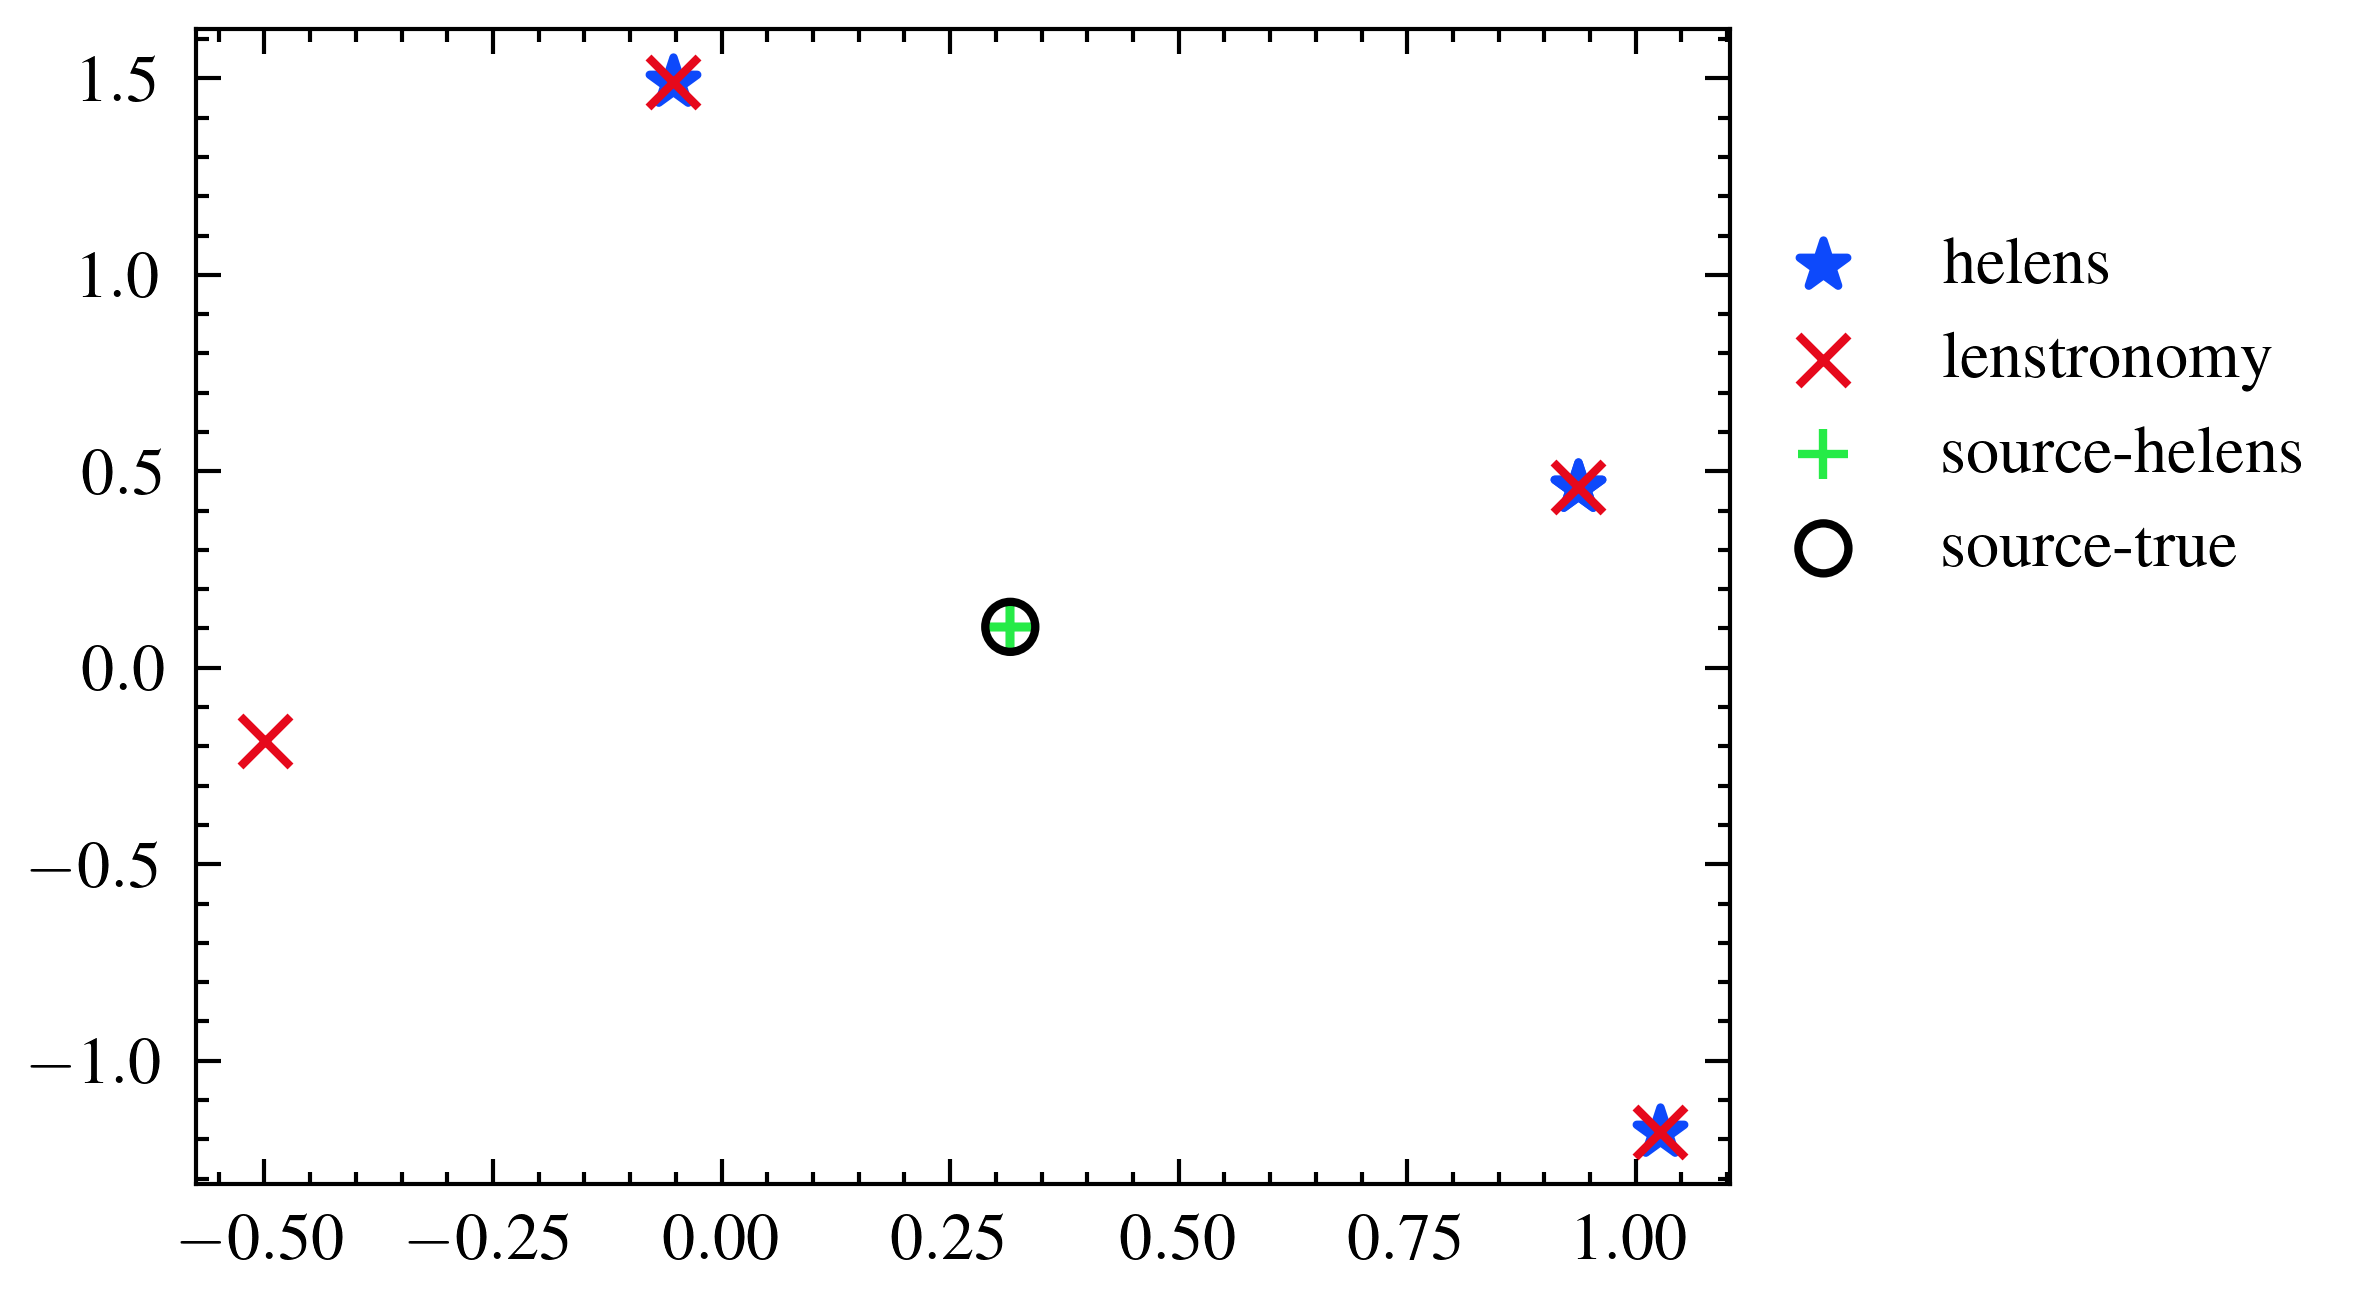

helens-source:  [0.3158301  0.3158301  0.31583013 0.31582752] [0.10415056 0.10415038 0.10415045 0.10414589]
True-source:  0.315830147545886 0.10415025470788342
No. of images from helens:  4
No. of images from lenstronomy:  4
----------------------------------------------------------------------------------------------------


In [22]:
# Chcek the lens equation solver againt lenstronomy for few source positions
y0_list = jnp.linspace(-0.5, 0.5, 3)
y1_list = jnp.linspace(-0.5, 0.5, 3)

# randomly construct pairs of y0 and y1
key = jax.random.PRNGKey(2)
# Randomly sample the lens paramas and generate new lens kwargs
lens_theta_E = jax.random.uniform(key, shape=(1,), minval=0.01, maxval=7.0)
lens_e1 = jax.random.uniform(key, shape=(1,), minval=0.0, maxval=0.3)
lens_e2 = jax.random.uniform(key, shape=(1,), minval=0.0, maxval=0.3)
lens_center_x = jnp.asarray(0.0)
lens_center_y = jnp.asarray(0.0)
gamma1 = jax.random.uniform(key, shape=(1,), minval=-0.3, maxval=0.3)
gamma2 = jax.random.uniform(key, shape=(1,), minval=-0.3, maxval=0.3)

kwargs_lens_ = [
    {'theta_E': lens_theta_E,
    'e1': lens_e1,
    'e2': lens_e2,
    'center_x': lens_center_x, 
    'center_y': lens_center_y},
    {'gamma1': gamma1,
    'gamma2': gamma2, 
    'ra_0': jnp.asarray(0.0), 'dec_0': jnp.asarray(0.0)}
]

kwargs_lens_fixed_ = [
    {'theta_E': float(lens_theta_E[0]),
    'e1': float(lens_e1[0]),
    'e2': float(lens_e2[0]),
    'center_x': 0.0, 
    'center_y': 0.0},
    {'gamma1': float(gamma1[0]),
    'gamma2': float(gamma2[0]), 
    'ra_0': 0.0, 'dec_0': 0.0}
]
print(kwargs_lens_)
print("-"*100)
print(kwargs_lens_fixed_)

y0_list = jax.random.uniform(key, shape=(10,), minval=-0.5, maxval=0.5)
y1_list = jax.random.uniform(jax.random.split(key, 2)[1], shape=(10,), minval=-0.5, maxval=0.5)

x_image_true_lenstronomy_list = []
y_image_true_lenstronomy_list = []
relative_error_x = []
relative_error_y = []
for y0, y1 in zip(y0_list, y1_list):
    x_image_true_lenstronomy, y_image_true_lenstronomy = solver_lenstronomy.image_position_from_source(
        kwargs_lens=kwargs_lens_fixed_,
        sourcePos_x=y0,
        sourcePos_y=y1,
        min_distance=0.01,
        search_window=15,
        precision_limit=10**(-10),
        num_iter_max=1200,
        solver='lenstronomy'
    )
    #solve using helens
    result_thetas, result_betas = solver.solve(
        jnp.array([y0, y1]), kwargs_lens_,
        **solver_params
    )
    result_beta_x, result_beta_y = result_betas.T # corresponding source plane positions    
    result_theta_x, result_theta_y = result_thetas.T  # image plane positions

    result_theta_x_no_central, result_theta_y_no_central, result_beta_x_no_central, result_beta_y_no_central = \
        remove_central_image(
            result_thetas, 
            result_betas,
            cx0_true,
            cy0_true
        )

    print('Helens-images: ',result_theta_x_no_central, result_theta_y_no_central)
    print('Lenstronomy-images: ',x_image_true_lenstronomy, y_image_true_lenstronomy)
    
    plt.scatter(result_theta_x_no_central, result_theta_y_no_central,marker='*',label='helens')
    plt.scatter(x_image_true_lenstronomy, y_image_true_lenstronomy,marker='x',label='lenstronomy')
    plt.scatter(result_beta_x_no_central, result_beta_y_no_central,marker='+',label='source-helens')
    plt.scatter(y0,y1,marker='o',label='source-true',facecolor='none',edgecolor='black')# no it shold be circle only with no fill color
    plt.legend(loc=(1,0.5))
    # #print the lens paramsters on the plot below lens position in a single coloumn 
    # # plt.text(1.0, 0.0, f'lens_theta_E: {lens_theta_E[0]:.2f}\n lens_e1: {lens_e1[0]:.2f}\n lens_e2: {lens_e2[0]:.2f}\n gamma1: {gamma1[0]:.2f}\n gamma2: {gamma2[0]:.2f}',
    # #          fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
    # #print(y0,y1) on the plot with small fontsize
    # plt.text(0.0, 0.0, f'y0: {y0:.2f}, y1: {y1:.2f}',
    #          fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
    # #plt the predicted source position on the plot
    
    plt.show()
    print('helens-source: ',result_beta_x_no_central, result_beta_y_no_central)
    print('True-source: ',y0, y1)
    x_image_true_lenstronomy_list.append(x_image_true_lenstronomy)
    y_image_true_lenstronomy_list.append(y_image_true_lenstronomy)
    if len(x_image_true_lenstronomy) == len(result_beta_x_no_central):
        relative_error_x.append(jnp.abs(x_image_true_lenstronomy - result_beta_x_no_central) / x_image_true_lenstronomy)
        relative_error_y.append(jnp.abs(y_image_true_lenstronomy - result_beta_y_no_central) / y_image_true_lenstronomy)

    print('No. of images from helens: ', len(result_theta_x_no_central))
    print('No. of images from lenstronomy: ', len(x_image_true_lenstronomy))
    print('-'*100)
    # print(f"Image positions for source ({y0}, {y1}): x = {x_image_true}, y = {y_image_true}")



In [23]:
# Create  a mock GW observation
# arcsecond_to_radians = (1*u.arcsecond).to(u.radian).value #4.84814e-6 
time_delay_distance_true = jax_cosmo.time_delay_distance(zl_true, zs_true) #with Mpc unit
print('Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]:', time_delay_distance_true)

x_image_true = jnp.array(x_image_true)
y_image_true = jnp.array(y_image_true)

lens_gw = lensimage_gw.LensImageGW(lens_mass_model)
data_GW = lens_gw.compute(x_image_true,y_image_true,kwargs_lens_true_sie_shear,time_delay_distance_true)

print(data_GW)
print('time_delays_in_days: ', data_GW['time_delays_in_days'])

dL_true = jax_cosmo.luminosity_distance(zs_true)
magnifications_true = data_GW['mu']
dL_effectives_true = dL_true/jnp.sqrt(jnp.abs(magnifications_true))
time_delays_true = data_GW['time_delays_in_seconds']
gw_obs = {
    'time_delays': time_delays_true, 
    'dL_eff': dL_effectives_true
}

print(gw_obs)


Time delay distance (D_dt) (in Mpc) [(1+zl)Ds*Dd/Dds]: 3088.8635805953313
{'beta_x': Array([0.3, 0.3, 0.3, 0.3], dtype=float64), 'beta_y': Array([0.2, 0.2, 0.2, 0.2], dtype=float64), 'psi': Array([27.96359333, 26.22108648, 23.97204131, 20.83697923], dtype=float64), 'mu': Array([ 5.4636646 ,  8.66926348, -8.06515447, -3.26534307], dtype=float64), 'phi_in_arcsecsq': Array([-14.59051491, -13.0588558 , -12.63044923,  -9.60442232], dtype=float64), 'Tstar_in_seconds': Array(7472713.02060066, dtype=float64), 'tarrivals_in_seconds': Array([-1.09030731e+08, -9.75850817e+07, -9.43837224e+07, -7.17710917e+07],      dtype=float64), 'tarrivals_days': Array([-1261.92975406, -1129.45696468, -1092.40419483,  -830.68393162],      dtype=float64), 'time_delays_in_seconds': Array([11445649.00293513,  3201359.3144533 , 22612630.74181636], dtype=float64), 'time_delays_in_days': Array([132.47278939,  37.05276984, 261.72026322], dtype=float64)}
time_delays_in_days:  [132.47278939  37.05276984 261.72026322]
{'

In [24]:
jnp.array(gw_obs['time_delays'])

Array([11445649.00293513,  3201359.3144533 , 22612630.74181636], dtype=float64)

In [25]:
y0true

0.3

In [26]:
class ProbModel(hcl.NumpyroModel):
    def __init__(self, n_images=4, gw_observations=None, em_observations=None, image_plane = False):
    
        self.n_images = n_images
        self.gw_observations = gw_observations or {}
        self.em_observations = em_observations or {}
        self.image_plane = image_plane
        super().__init__()
        
        # Store likelihood values
        self.em_loglike = 0.0
        self.gw_loglike = 0.0
        self.prior_loglike = 0.0
        self.combined_loglike = 0.0

    def model(self):
        # Track prior contributions
        prior_loglike = 0.0
        zs = jnp.asarray(zs_true)#numpyro.sample('zs', dist.Uniform(1.0, 10.0))
        prior_loglike += dist.Uniform(1.0, 10.0).log_prob(zs)
        
        zl = jnp.asarray(zl_true)#numpyro.sample('zl', dist.Uniform(0.0, zs-0.0001))
        prior_loglike += dist.Uniform(0.0, zs-0.0001).log_prob(zl)
        
        #Lens model parameters
        lens_theta_E = numpyro.sample('lens_theta_E', dist.Uniform(4.0, 6.0))
        prior_loglike += dist.Uniform(4.0, 6.0).log_prob(lens_theta_E)
        
        lens_e1 = jnp.asarray(e1_true)#numpyro.sample('lens_e1', dist.Uniform(0.0, 0.3))
        prior_loglike += dist.Uniform(0.0, 0.3).log_prob(lens_e1)
        
        lens_e2 = jnp.asarray(e2_true)#numpyro.sample('lens_e2', dist.Uniform(0.0, 0.3))
        prior_loglike += dist.Uniform(0.0, 0.3).log_prob(lens_e2)
        
        lens_center_x = jnp.asarray(0.0) #numpyro.sample('lens_center_x', dist.Uniform(0.0, 5.0))
        # prior_loglike += dist.Uniform(0.0, 5.0).log_prob(lens_center_x)
        
        lens_center_y = jnp.asarray(0.0) #numpyro.sample('lens_center_y', dist.Uniform(0.0, 5.0))
        # prior_loglike += dist.Uniform(0.0, 5.0).log_prob(lens_center_y)
        
        # External shear parameters
        gamma1 = jnp.asarray(gamma1_true)#numpyro.sample('lens_gamma1', dist.Uniform(-0.3, 0.3))
        prior_loglike += dist.Uniform(0.0, 0.3).log_prob(gamma1)
        
        gamma2 = jnp.asarray(gamma2_true)#numpyro.sample('lens_gamma2', dist.Uniform(-0.3, 0.3))
        prior_loglike += dist.Uniform(-0.3, 0.3).log_prob(gamma2)
        
        # sigma_bkg = numpyro.sample('noise_sigma_bkg', dist.Uniform(low=1e-3, high=1e-1))
        # prior_loglike += dist.Uniform(low=1e-3, high=1e-1).log_prob(sigma_bkg)

        prior_lens = [
            {'theta_E': lens_theta_E,
            'e1': lens_e1,
            'e2': lens_e2,
            'center_x': lens_center_x, 
            'center_y': lens_center_y},
            # external shear, with fixed origin
            {'gamma1': gamma1, 
            'gamma2': gamma2, 
            'ra_0': jnp.asarray(0.0), 'dec_0': jnp.asarray(0.0)}
            ]        
        # jax.debug.print("prior_lens: {prior_lens}", prior_lens=prior_lens)

        if self.em_observations:
            self.em_loglike = 0.0
        else:
            self.em_loglike = 0.0

        if self.image_plane==True:
            # Image positions
            image_positions = []
            x_pos_array = []
            y_pos_array = []
            for i in range(self.n_images):
                # X positions
                x_pos = numpyro.sample(f'image_x{i+1}', dist.Uniform(-10, 10))
                prior_loglike += dist.Uniform(-10, 10).log_prob(x_pos)
                
                # Y positions
                y_pos = numpyro.sample(f'image_y{i+1}', dist.Uniform(-10, 10))
                prior_loglike += dist.Uniform(-10, 10).log_prob(y_pos)
                
                image_positions.append((x_pos, y_pos))
                x_pos_array.append(x_pos)
                y_pos_array.append(y_pos)
            
            x_pos_array = jnp.array(x_pos_array)
            y_pos_array = jnp.array(y_pos_array)

        else:
            # Source positions
            y0gw = jnp.asarray(y0true)#numpyro.sample('y0gw', dist.Uniform(-1, 1))
            prior_loglike += dist.Uniform(-1, 1).log_prob(y0gw)
            y1gw = jnp.asarray(y1true)#numpyro.sample('y1gw', dist.Uniform(-1, 1))
            prior_loglike += dist.Uniform(-1, 1).log_prob(y1gw)

            #solve lens equation using helens
            result_thetas, result_betas = solver.solve(
                jnp.array([y0gw, y1gw]), prior_lens,
                **solver_params
            )
            # result_beta_x, result_beta_y = result_betas.T # corresponding source plane positions    
            # result_theta_x, result_theta_y = result_thetas.T  # image plane positions   
            #remove the central image
            result_theta_x_no_central, result_theta_y_no_central, result_beta_x_no_central, result_beta_y_no_central = \
                remove_central_image(
                    result_thetas, 
                    result_betas,
                    prior_lens[0]['center_x'],
                    prior_lens[0]['center_y']
                )
            x_pos_array = result_theta_x_no_central
            y_pos_array = result_theta_y_no_central


        if self.gw_observations:
            D_dt_model = jax_cosmo.time_delay_distance(zl,zs)
            dL_model = jax_cosmo.luminosity_distance(zs)
            model_gw = lens_gw.compute(x_pos_array,y_pos_array,prior_lens,D_dt_model)
            beta_x = model_gw['beta_x']
            beta_y = model_gw['beta_y']
            betx_x_diff = jnp.diff(beta_x)
            bety_y_diff = jnp.diff(beta_y)
            zeros = jnp.zeros_like(betx_x_diff) 
            ones = jnp.ones_like(betx_x_diff)

            model_time_delays = model_gw['time_delays_in_seconds']
            model_magnifications = model_gw['mu']
            model_dL_eff = dL_model/jnp.sqrt(jnp.abs(model_magnifications))

            # jax.debug.print("model_dL_eff: {model_dL_eff}", model_dL_eff=model_dL_eff-dL_effectives_true)
            # jax.debug.print("model_time_delays: {model_time_delays}", model_time_delays=model_time_delays-time_delays_true)
            # jax.debug.print("model_magnifications: {model_magnifications}", model_magnifications=model_magnifications-magnifications_true)

            # GW likelihood
            sigma_td = 0.05 * gw_obs['time_delays']#jnp.array(time_delays_true)
            sigma_dL_eff = 0.05 * gw_obs['dL_eff']#jnp.array(dL_effectives_true)
            # epsilon = 0.005*ones

            numpyro.sample('tdelays_obs', dist.Independent(dist.Normal(model_time_delays, sigma_td), 1), obs=gw_obs['time_delays'])
            numpyro.sample('dL_eff_obs', dist.Independent(dist.Normal(model_dL_eff, sigma_dL_eff), 1), obs=gw_obs['dL_eff'])
            # numpyro.sample('betx_x_diff', dist.Independent(dist.Normal(zeros, epsilon), 1), obs=betx_x_diff)
            # numpyro.sample('bety_y_diff', dist.Independent(dist.Normal(zeros, epsilon), 1), obs=bety_y_diff)

            loglike_td = dist.Independent(dist.Normal(model_time_delays, sigma_td), 1).log_prob(time_delays_true)
            loglike_dL_eff = dist.Independent(dist.Normal(model_dL_eff, sigma_dL_eff), 1).log_prob(dL_effectives_true)
            # loglike_betx_x_diff = dist.Independent(dist.Normal(zeros, epsilon), 1).log_prob(betx_x_diff)
            # loglike_bety_y_diff = dist.Independent(dist.Normal(zeros, epsilon), 1).log_prob(bety_y_diff)

            loglike_gw = loglike_td + loglike_dL_eff #+ loglike_betx_x_diff + loglike_bety_y_diff
            # gw_logprob = self._compute_gw_logprob(zl,zs,image_positions, prior_lens)
            # This line adds the computed GW log-likelihood (gw_loglike) to the model's total log-probability.
            # It effectively incorporates the GW likelihood as an unnormalized factor in the probabilistic model.
            # numpyro.factor('gw_likelihood', gw_logprob)
            self.gw_loglike = loglike_gw
            # jax.debug.print("GW log-likelihood: {gw_loglike}", gw_loglike=loglike_gw)
        else:
            self.gw_loglike = 0.0
        
        self.prior_loglike = prior_loglike
        # jax.debug.print("Prior log-likelihood: {prior_loglike}", prior_loglike=self.prior_loglike)
        # jax.debug.print("EM log-likelihood: {em_loglike}", em_loglike=self.em_loglike)
        # jax.debug.print("GW log-likelihood: {gw_loglike}", gw_loglike=self.gw_loglike)
        
        # Combined likelihood (prior + EM + GW)
        
        combined_loglike = self.prior_loglike + self.em_loglike + self.gw_loglike
        self.combined_loglike = combined_loglike
        # jax.debug.print("Combined log-likelihood: {combined_loglike}", combined_loglike=self.combined_loglike)


    
    def params2kwargs(self, params):
        # functions that takes the flatten dictionary of numpyro parameters
        # and reshape it back to the argument of lens_image.model()
        kw = {'kwargs_lens': [{'theta_E': params['lens_theta_E'],
        'e1': params['lens_e1'],
        'e2': params['lens_e2']},
        # 'center_x': params['lens_center_x'],
        # 'center_y': params['lens_center_y']},
        {'gamma1': params['lens_gamma1'],
        'gamma2': params['lens_gamma2'],
        'ra_0': 0.0,
        'dec_0': 0.0}],
        # 'kwargs_source': [{'amp': params['source_amp'],
        # 'R_sersic': params['source_R_sersic'],
        # 'n_sersic': params['source_n'],
        # 'e1': params['source_e1'],
        # 'e2': params['source_e2'],
        # 'center_x': params['source_center_x'],
        # 'center_y': params['source_center_y']}],
        # 'kwargs_lens_light': [{'amp': params['light_amp'],
        # 'R_sersic': params['light_R_sersic'],
        # 'n_sersic': params['light_n'],
        # 'e1': params['light_e1'],
        # 'e2': params['light_e2'],
        # 'center_x': params['light_center_x'],
        # 'center_y': params['light_center_y']}],
        # 'zs': params['zs'],
        # 'zl': params['zl'],
        # 'image_positions': [
        #         (params.get(f'image_x{i+1}', 0.0),
        #         params.get(f'image_y{i+1}', 0.0))
        #         for i in range(self.n_images)
        #     ]
        'source_positions': [{'y0gw': params['y0gw'],
            'y1gw': params['y1gw']}
        ]
        }
        return kw
    
    def get_likelihoods(self):
        """Return the computed likelihood values"""
        # jax.debug.print("Getting likelihoods")
        # jax.debug.print(self.prior_loglike)
        # jax.debug.print(self.em_loglike)
        # jax.debug.print(self.gw_loglike)
        # jax.debug.print(self.combined_loglike)
        return {
            'prior_loglike': self.prior_loglike,
            'em_loglike': self.em_loglike,
            'gw_loglike': self.gw_loglike, 
            'combined_loglike': self.combined_loglike
        }

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)


Number of parameters: 1


In [27]:
kwargs_lens_true_sie_shear

[{'theta_E': 5.0,
  'e1': Array(0.1373231, dtype=float64, weak_type=True),
  'e2': Array(0.03937677, dtype=float64, weak_type=True),
  'center_x': 0.0,
  'center_y': 0.0},
 {'gamma1': Array(-3.09016994e-05, dtype=float64, weak_type=True),
  'gamma2': Array(9.51056516e-05, dtype=float64, weak_type=True),
  'ra_0': 0.0,
  'dec_0': 0.0}]

In [28]:
# create the input vector for reference
input_params = {
    'zs': zs_true,
    'zl': zl_true,
    'lens_theta_E': kwargs_lens_true_sie_shear[0]['theta_E'],
    'lens_e1': kwargs_lens_true_sie_shear[0]['e1'],
    'lens_e2': kwargs_lens_true_sie_shear[0]['e2'],
    'lens_gamma1': kwargs_lens_true_sie_shear[1]['gamma1'],
    'lens_gamma2': kwargs_lens_true_sie_shear[1]['gamma2'],
    'y0gw': y0true,
    'y1gw': y1true
}

# input_params

input_params_flat = jnp.array(list(input_params.values()))

len(input_params_flat)

9

In [29]:
gw_model = ProbModel(n_images=4, gw_observations=gw_obs, image_plane=False)
print(gw_model.num_parameters)
print("GW Model created with", gw_model.num_parameters, "parameters")

1
GW Model created with 1 parameters


In [30]:
# PRNG key
SEED = 12345
prng_key = jax.random.PRNGKey(SEED)
model_ = gw_model
#Check all the methods in the ProbModel class for gw_model
print("Checking methods in ProbModel class for gw_model...")
# 1. model()
print("Running model() method...")
model_.model
print("model() method executed successfully.")

# Compute log posterior = log prior + log likelihood
print("Computing log posterior...")
log_post = model_.log_prob(input_params,constrained=True)
print("Log posterior computed: {}".format(log_post))

# Calculate likelihoods from get_likelihoods method
log_likes = model_.get_likelihoods()
print("Likelihoods retrieved: {}".format(log_likes))
print("logPrior = {}".format(log_likes['prior_loglike']))
print("logGW = {}".format(log_likes['gw_loglike']))
print("logEM = {}".format(log_likes['em_loglike']))
print("logPost = {}".format(log_likes['combined_loglike']))

# Compute loglikelihood using Numyro utility inbuilt function
print("Computing log likelihood using numpyro utility...")
loglike_util = numpyro.infer.util.log_likelihood(model_.model, input_params)
loglike_util_sum = sum(loglike_util.values())
for key, value in loglike_util.items():
    print(f"{key}: {value}")
print("Total Log likelihood (utility) computed: {}".format(loglike_util_sum))

input_params_unconst = model_.unconstrain(input_params)
print("Input parameters (unconstrained):", input_params_unconst)

# Potential energy (negative log posterior)
print("Computing potential energy...")
potential_energy = numpyro.infer.util.potential_energy(model_.model,(),{}, input_params_unconst)
print("Potential energy computed: {}".format(potential_energy))

# Check log_density function of numpyro
print("Computing log density...")
# Call the log_density function, this is computed in constarined space 
log_density, model_trace = numpyro.infer.util.log_density(model_.model,(),{},input_params)

print("Log density computed: {}".format(log_density))

#get a seeded model
seeded_model = seed(model_.model, prng_key)
trace = numpyro.handlers.trace(seeded_model).get_trace()
print('Trace obtained with {} nodes:'.format(len(trace)))

# same thing obtain using defined function
trace_ = model_.get_trace(prng_key)
assert trace.keys() == trace_.keys()
assert all(jnp.all(trace[key]['value'] == trace_[key]['value']) for key in trace.keys())
print('Trace_ obtained with {} nodes:'.format(len(trace_)))
for name, site in trace.items():
    print(f"{name}: {site['value']}")
    # Check log probability at each node in the trace
    log_prob = site['fn'].log_prob(site['value'])
    print(f"Log probability at {name}: {log_prob}")

# get the site names 
site_names = list(trace.keys())
print("Site names in the trace:", site_names)

Checking methods in ProbModel class for gw_model...
Running model() method...
model() method executed successfully.
Computing log posterior...
Log posterior computed: -69.46543679402622
Likelihoods retrieved: {'prior_loglike': Array(-0.84701926, dtype=float64, weak_type=True), 'em_loglike': 0.0, 'gw_loglike': Array(-68.77228961, dtype=float64), 'combined_loglike': Array(-69.61930888, dtype=float64)}
logPrior = -0.8470192615821599
logGW = -68.77228961346627
logEM = 0.0
logPost = -69.61930887504843
Computing log likelihood using numpyro utility...
dL_eff_obs: -26.836445354261706
tdelays_obs: -41.935844259204565
Total Log likelihood (utility) computed: -68.77228961346627
Input parameters (unconstrained): {'zs': 2.0, 'zl': 0.5, 'lens_theta_E': Array(0., dtype=float64, weak_type=True), 'lens_e1': Array(0.1373231, dtype=float64, weak_type=True), 'lens_e2': Array(0.03937677, dtype=float64, weak_type=True), 'lens_gamma1': Array(-3.09016994e-05, dtype=float64, weak_type=True), 'lens_gamma2': Ar

In [31]:
SEED = 12
prng_key = jax.random.PRNGKey(SEED)
key, key_init = jax.random.split(prng_key)
init_params = gw_model.get_sample(key_init)  # constrained space
init_params_unconst = gw_model.unconstrain(init_params)  # UNconstrained space
input_params_unconst = gw_model.unconstrain(input_params)
# kwargs_init = gw_model.params2kwargs(init_params)  # constrained space

In [32]:
init_params

{'lens_theta_E': Array(4.66317789, dtype=float64)}

In [33]:
gw_loss = hcl.Loss(gw_model)


In [34]:
init_params

{'lens_theta_E': Array(4.66317789, dtype=float64)}

In [35]:
# logdensity_fn(init_params)

In [36]:
gw_loss(init_params_unconst)

2025-10-10 17:37:27.672457: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %slice.234 = f64[1,500000,3]{2,1,0} slice(f64[2,500000,3]{0,2,1} %constant.538), slice={[0:1], [0:500000], [0:3]}, metadata={op_name="jit(__call__)/jit(main)/slice" source_file="/var/folders/_n/04pjt7pn32d2tvw60qhfvhzh0000gn/T/ipykernel_54382/1144355614.py" source_line=98}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-10-10 17:37:28.069476: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.400794s
Constant folding an instruction is taking > 1s:

  %slice.234 = f64[1,500000,3

Array(94.34867927, dtype=float64)

In [67]:
# @jax.jit
# def logdensity_fn(args):
#     return -gw_loss(args)

# print(logdensity_fn(init_params_unconst))


@jax.jit
def logdensity_fn(dict):
    theta_E = dict['lens_theta_E']
    args = input_params.copy()
    args['lens_theta_E'] = theta_E
    log_density, model_trace = numpyro.infer.util.log_density(gw_model.model, (), {}, args)
    return log_density

# print(logdensity_fn(init_params))
print(logdensity_fn({'lens_theta_E': input_params['lens_theta_E']}))


-69.46543668892632


In [63]:
# theta_E_true
# logdensity_fn(input_params)

In [64]:
# theta_E_true
# logdensity_fn(input_params)

In [40]:
thetaE_list = jnp.linspace(4,7,100)
input_params_copy = input_params.copy()
log_density_list = []
grad_logdensity_list = []
grad_logdensity_fn = jax.grad(logdensity_fn)
for thetaE in thetaE_list:
    input_params_copy['lens_theta_E'] = thetaE
    log_density_list.append(logdensity_fn(input_params_copy))
    grad = float(grad_logdensity_fn(input_params_copy)['lens_theta_E'])
    grad_logdensity_list.append(grad)



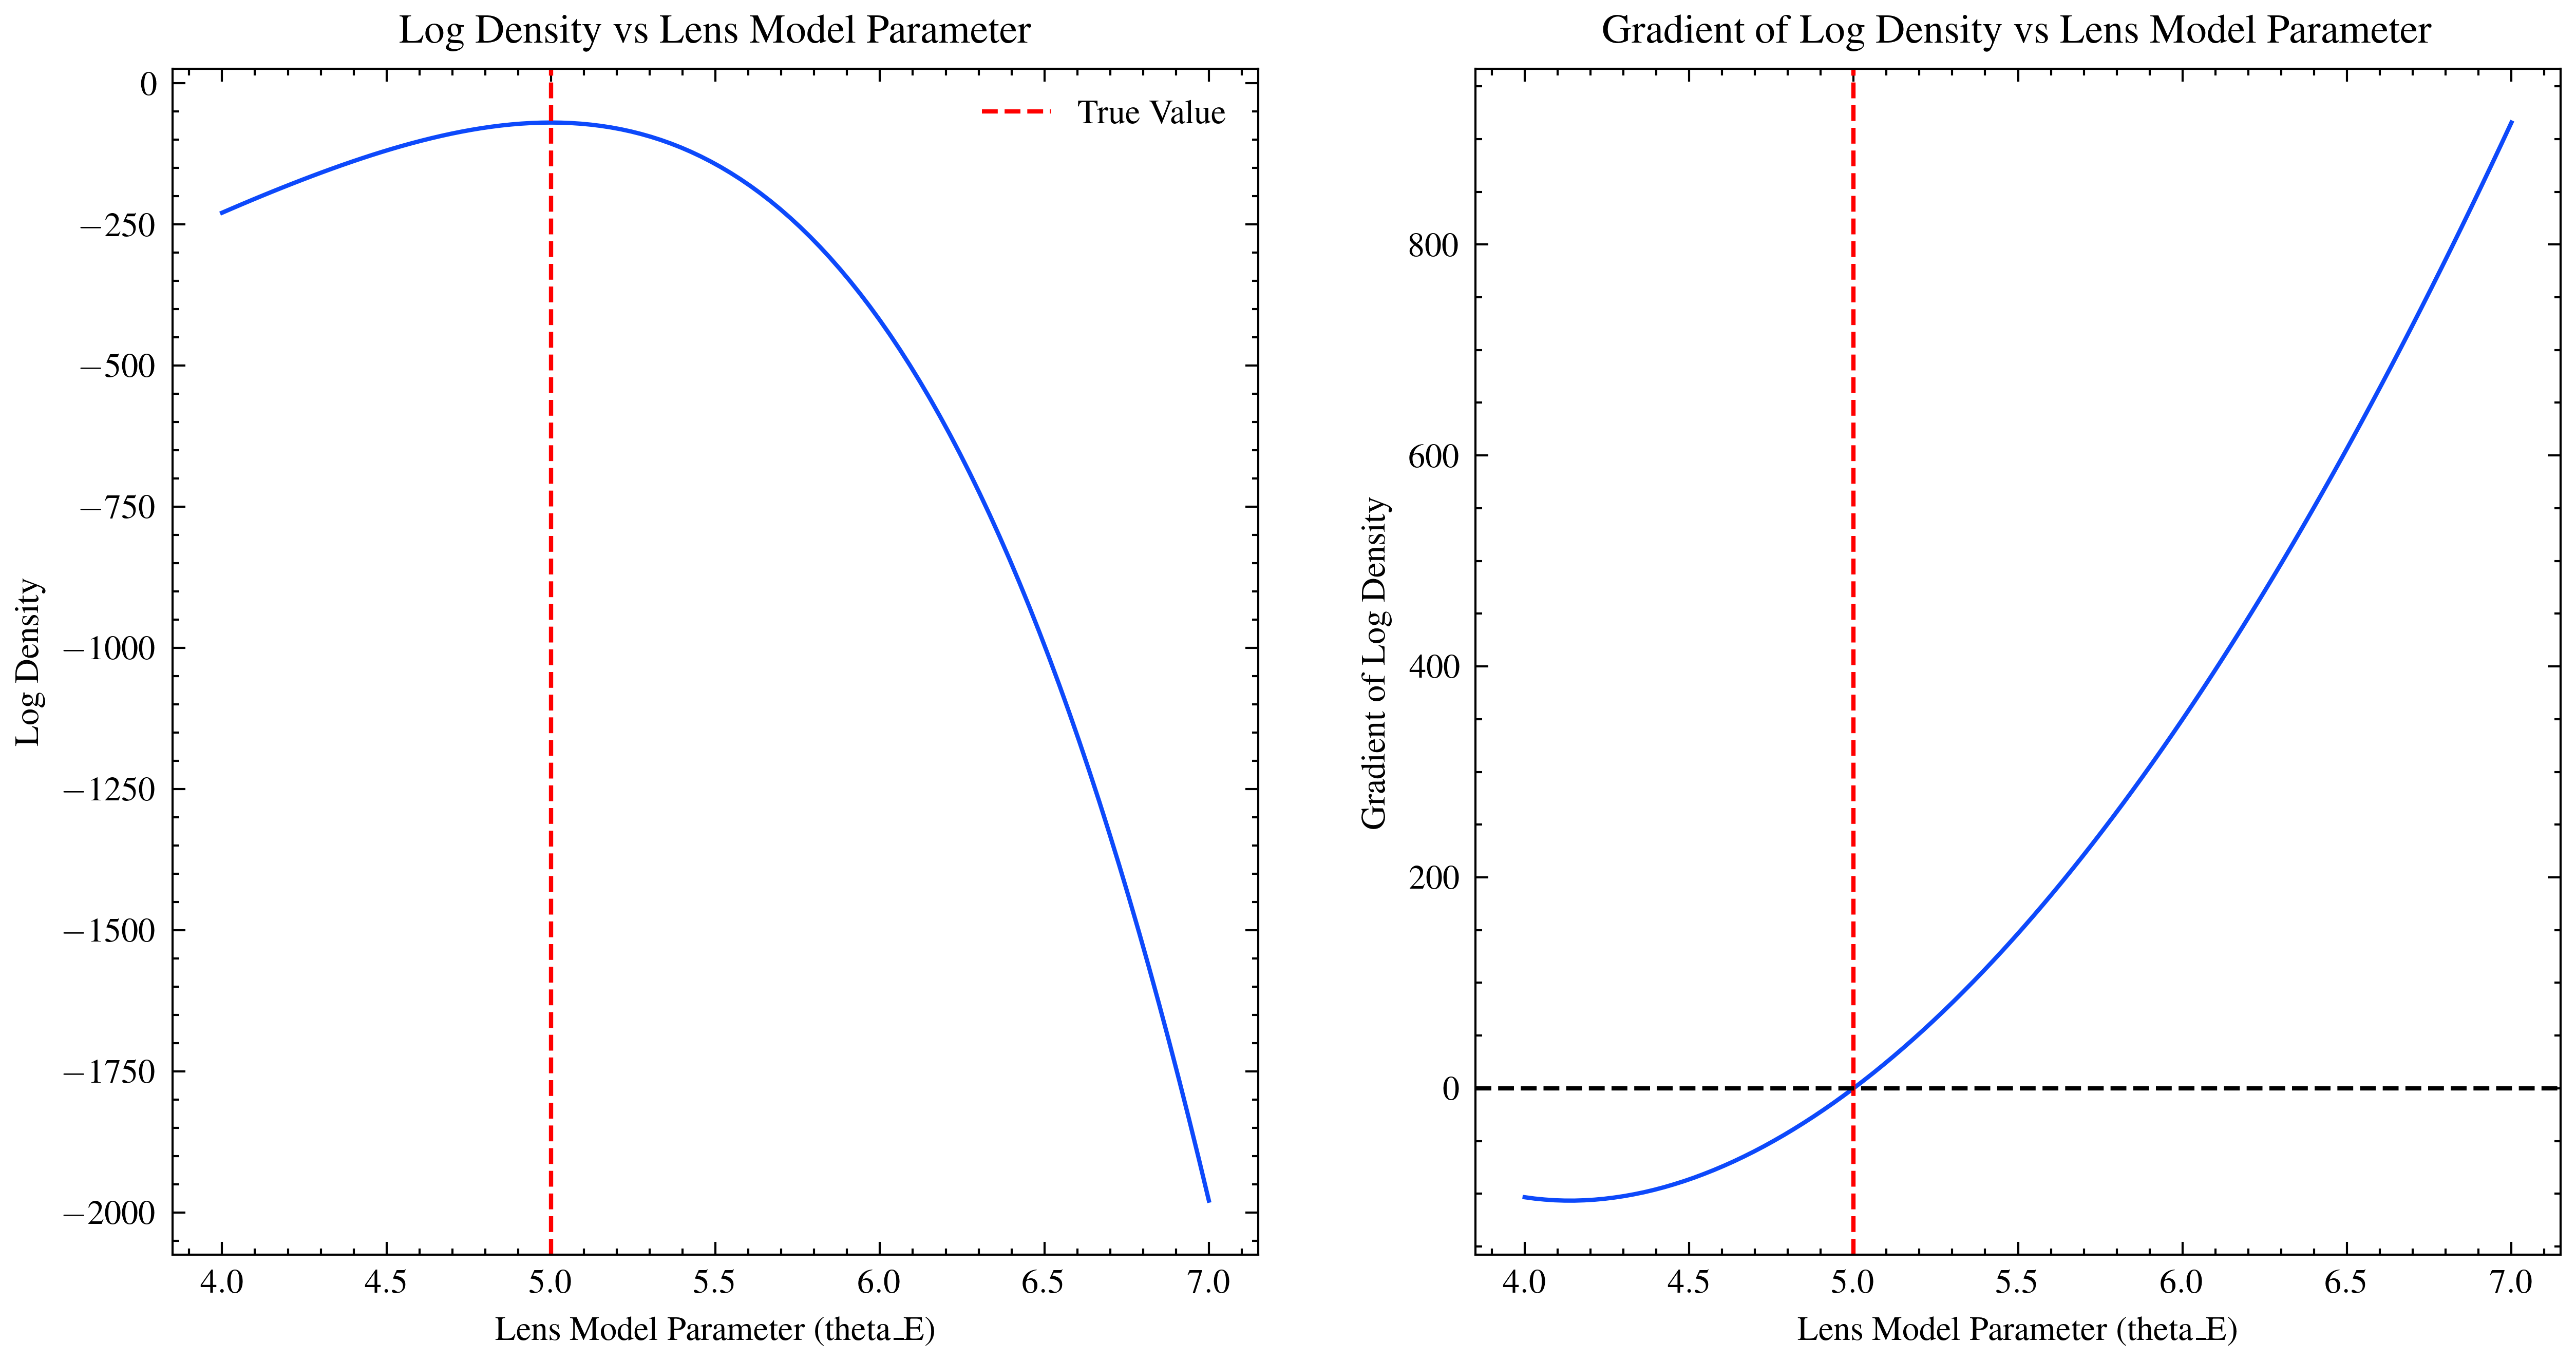

In [41]:
# Plot log density and gradient of log density
plt.figure(figsize=(10, 5))

# Log density plot
plt.subplot(1, 2, 1)
plt.plot(thetaE_list, log_density_list)
plt.axvline(theta_E_true, color='red', linestyle='--', label='True Value')
plt.xlabel('Lens Model Parameter (theta_E)')
plt.ylabel('Log Density')
plt.title('Log Density vs Lens Model Parameter')
plt.legend()

# Gradient of log density plot
plt.subplot(1, 2, 2)
plt.plot(thetaE_list,  jnp.array(grad_logdensity_list))
plt.axvline(theta_E_true, color='red', linestyle='--', label='True Value')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Lens Model Parameter (theta_E)')
plt.ylabel('Gradient of Log Density')
plt.title('Gradient of Log Density vs Lens Model Parameter')
plt.show()

In [42]:
# I want to compute gradient of logdensity_fn with respect to args
grad_logdensity_fn = jax.grad(logdensity_fn)
print(grad_logdensity_fn(input_params)['lens_theta_E'])


0.011202402261676965


In [68]:
print(logdensity_fn(init_params))

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, 
    target_acceptance_rate=0.6, 
    is_mass_matrix_diagonal=True,
    max_num_doublings=8,
    progress_bar=True,
    initial_step_size=5.0,
    # progress_bar=True,  # Commented out to fix the error
)

num_steps_adaptation = 10

key, key_hmc_adapt, key_hmc_run = jax.random.split(prng_key, 3)

start = time.time()
(last_state, adapted_settings), info = adapt.run(key_hmc_adapt, {'lens_theta_E': input_params['lens_theta_E']}, 
                                                 num_steps=num_steps_adaptation)
print("Time taken by HMC (blackjax) warmup phase:", time.time()-start)

print("Warmup state (lens only, unconstrained)", {k: v for k, v in last_state.position.items() if 'lens' in k})

-93.53511531121828
Running window adaptation


Time taken by HMC (blackjax) warmup phase: 39.507148027420044
Warmup state (lens only, unconstrained) {'lens_theta_E': Array(5.01298848, dtype=float64, weak_type=True)}


In [69]:
# Unpack the info tuple
hmc_states, nuts_infos, adaptation_states = info

print("\n" + "="*60)
print("ADAPTATION INFO STRUCTURE")
print("="*60)
print(f"HMC States: {type(hmc_states)}")
print(f"NUTS Infos: {type(nuts_infos)}")
print(f"Adaptation States: {type(adaptation_states)}")

# Get number of trajectories from array shapes
num_trajectories = len(hmc_states.position[list(hmc_states.position.keys())[0]])
print(f"\nTotal trajectories: {num_trajectories}")


ADAPTATION INFO STRUCTURE
HMC States: <class 'blackjax.mcmc.hmc.HMCState'>
NUTS Infos: <class 'blackjax.mcmc.nuts.NUTSInfo'>
Adaptation States: <class 'blackjax.adaptation.window_adaptation.WindowAdaptationState'>

Total trajectories: 10


In [71]:
# # Do subplot of positions explotred and their gradient
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(hmc_states.position['lens_e1'],label='position')
# plt.xlabel('Trajectory')
# plt.ylabel('Position')
# plt.title('Position Evolution')
# plt.legend()

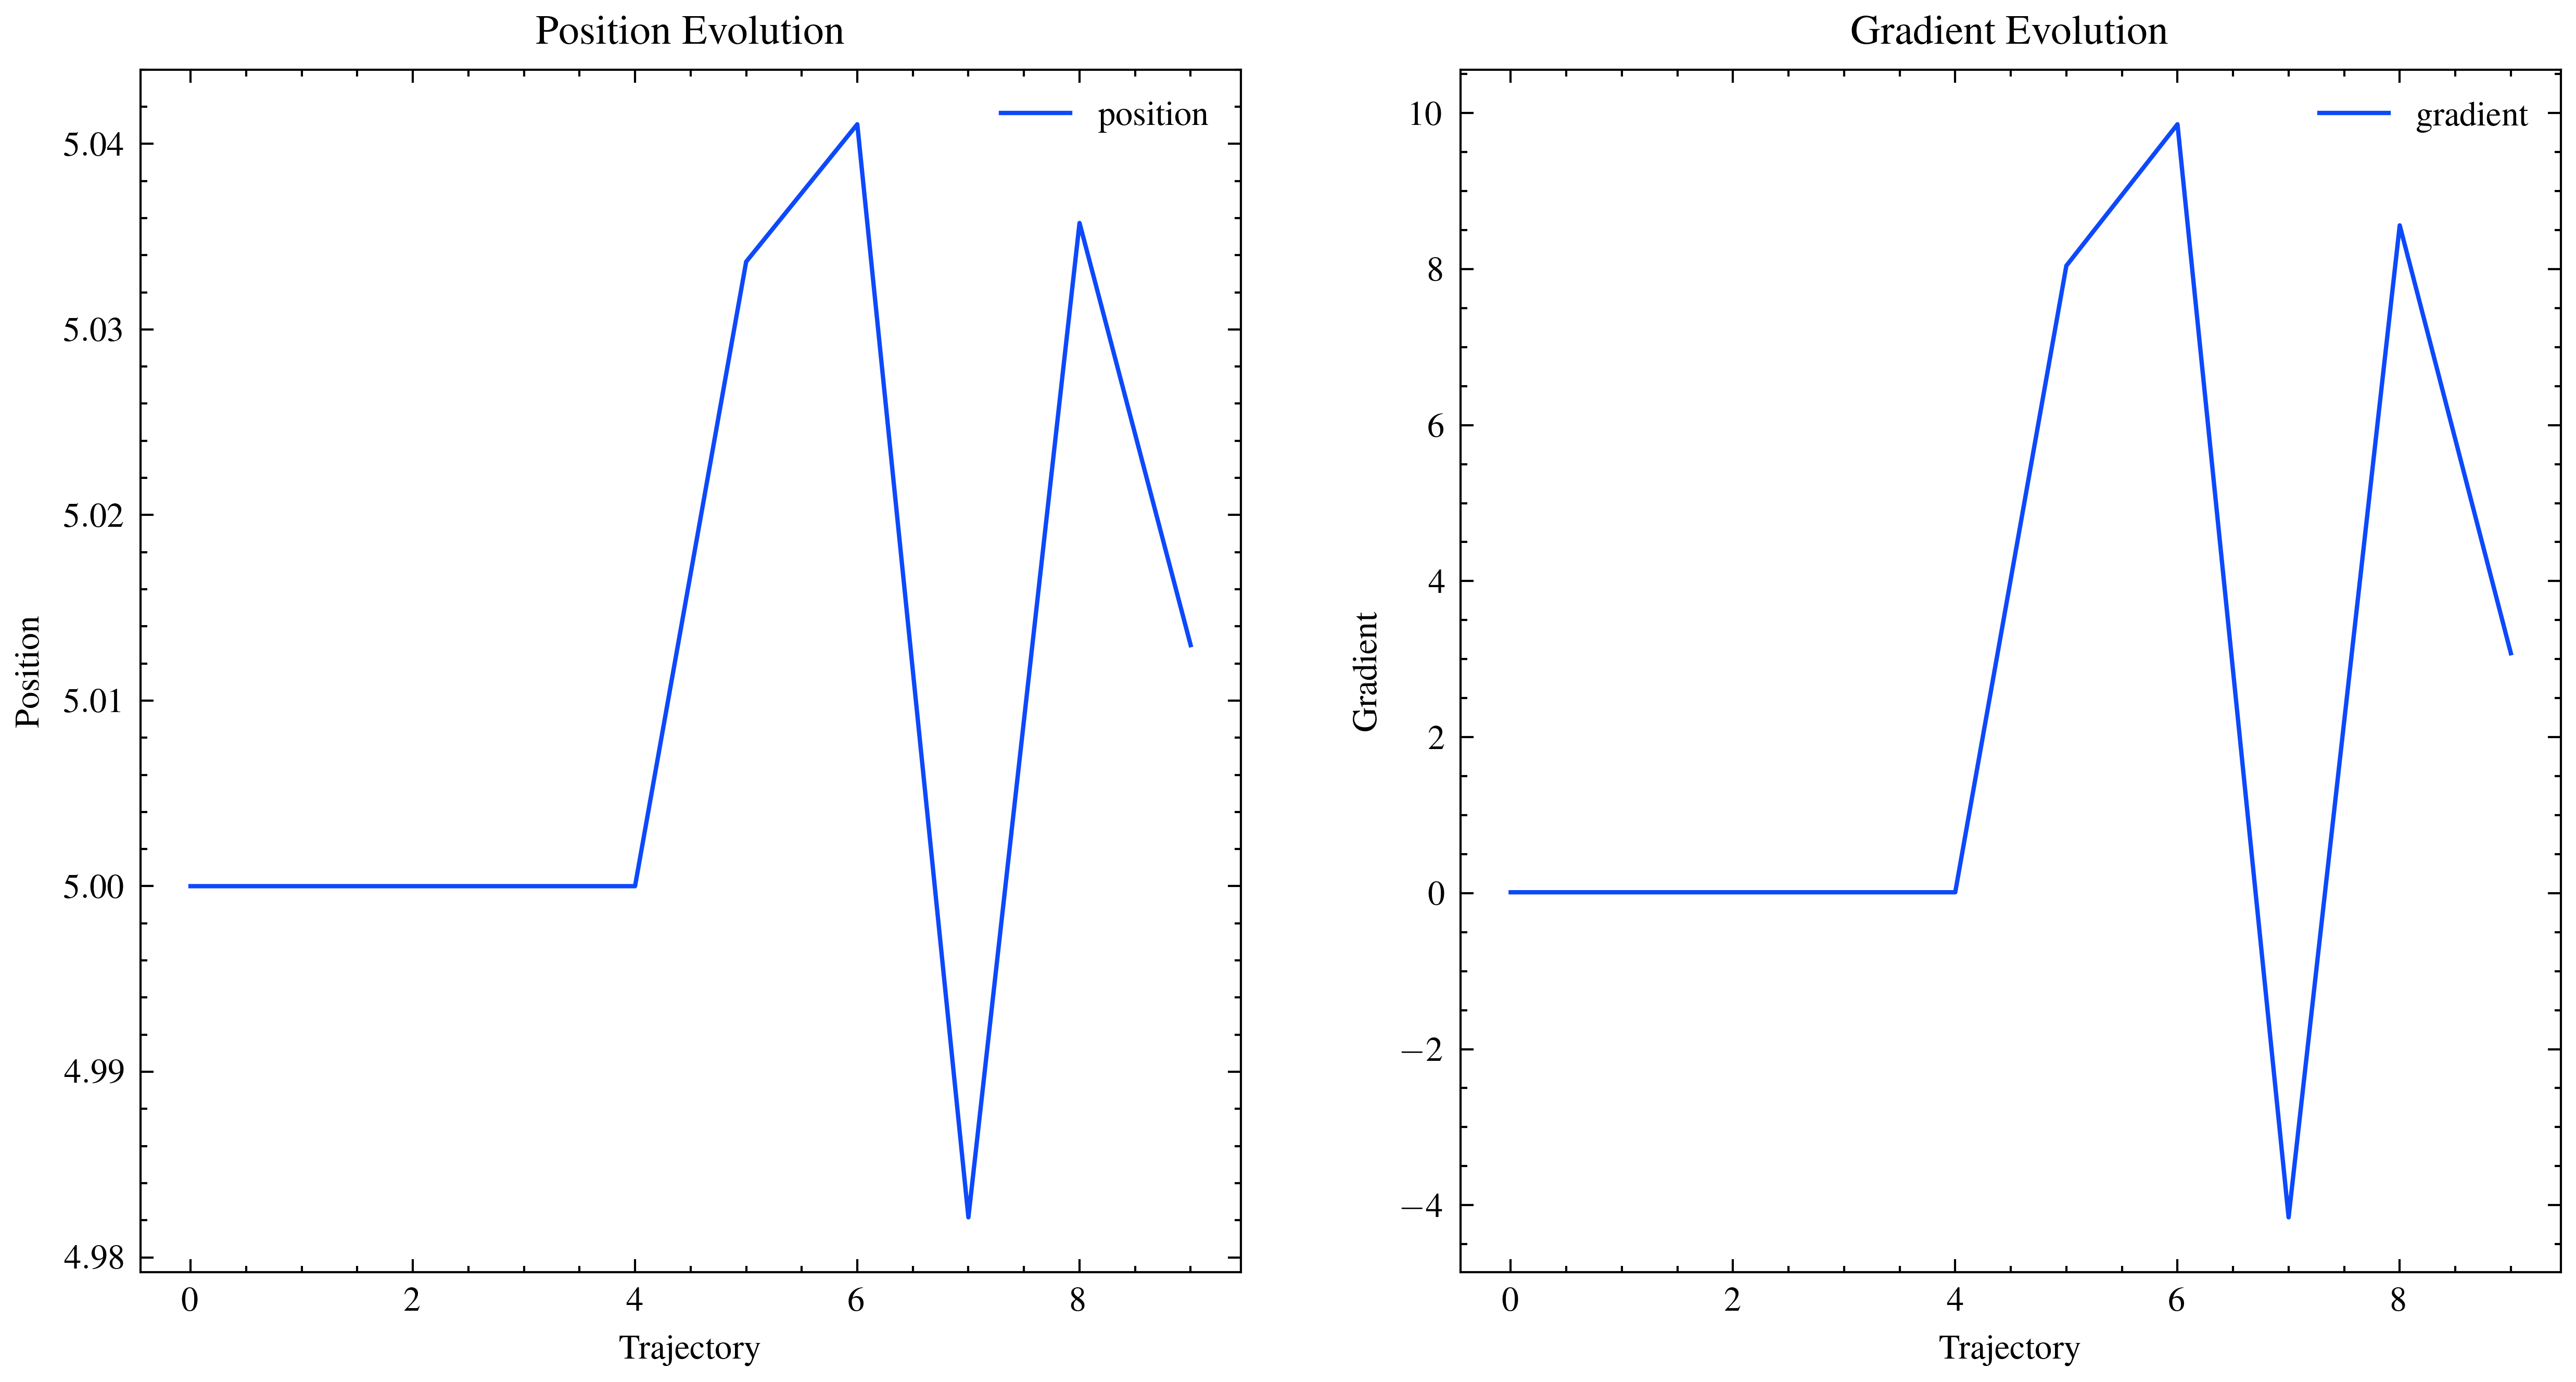

In [72]:
# Do subplot of positions explotred and their gradient
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hmc_states.position['lens_theta_E'],label='position')
plt.xlabel('Trajectory')
plt.ylabel('Position')
plt.title('Position Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hmc_states.logdensity_grad['lens_theta_E'],label='gradient')
plt.xlabel('Trajectory')
plt.ylabel('Gradient')
plt.title('Gradient Evolution')
plt.legend()
plt.show()


In [73]:
# HMC States contains the position, logdensity, logdensity gradient, and energy
print(hmc_states.position)
print(hmc_states.logdensity)
print(hmc_states.logdensity_grad)

#NUTS Infos contains the num_integration_steps, is_divergent, acceptance_rate, and energy
print(nuts_infos.num_integration_steps)
print(nuts_infos.is_divergent)
print(nuts_infos.acceptance_rate)
print(nuts_infos.energy)

# Adaptation States contains the step_size, inverse_mass_matrix
print(adaptation_states.step_size)
print(adaptation_states.inverse_mass_matrix)



{'lens_theta_E': Array([5.        , 5.        , 5.        , 5.        , 5.        ,
       5.03364692, 5.0410558 , 4.98215529, 5.03573531, 5.01298848],      dtype=float64, weak_type=True)}
[-69.46543669 -69.46543669 -69.46543669 -69.46543669 -69.46543669
 -69.74472226 -69.88227106 -69.54238632 -69.78068974 -69.50672655]
{'lens_theta_E': Array([ 0.0112024 ,  0.0112024 ,  0.0112024 ,  0.0112024 ,  0.0112024 ,
        8.04303251,  9.85733107, -4.15633412,  8.56084714,  3.07593202],      dtype=float64, weak_type=True)}
[  1   1   1   2   7  72 255 255 255 255]
[ True  True  True  True False  True False False False False]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.37200147e-14
 3.06449219e-03 1.65286795e-01 3.88823204e-01 4.41548768e-01
 9.17381743e-01 3.40447180e-01]
[69.52846553 69.56149657 70.24225624 69.51684987 71.38430318 70.36119994
 69.94997964 71.21044134 70.26485865 70.74020298]
[1.67955491e+01 2.95528733e+00 4.12951393e-01 5.25957557e-02
 6.58400304e-03 1.36689655e-03 5.9508

In [74]:
print("\n" + "="*60)
print("INTEGRATION STEPS PER TRAJECTORY")
print("="*60)

num_integration_steps = [int(nuts_infos.num_integration_steps[i]) for i in range(num_trajectories)]
print(f"Integration steps: {num_integration_steps}")
print(f"Mean integration steps: {jnp.mean(jnp.array(num_integration_steps)):.2f}")



INTEGRATION STEPS PER TRAJECTORY
Integration steps: [1, 1, 1, 2, 7, 72, 255, 255, 255, 255]
Mean integration steps: 110.40


In [75]:
print("\n" + "="*60)
print("STEP SIZES")
print("="*60)

step_sizes = [float(adaptation_states.step_size[i]) for i in range(num_trajectories)]
print(f"Step sizes: {step_sizes}")
print(f"Final step size: {step_sizes[-1]:.6f}")


STEP SIZES
Step sizes: [16.79554906195812, 2.955287328097812, 0.4129513932802974, 0.052595755746995425, 0.006584003038622497, 0.0013668965521129316, 0.0005950811826323348, 0.00032417169285138125, 0.0008336051795478541, 0.0003613012710446643]
Final step size: 0.000361


In [76]:
print("\n" + "="*60)
print("TRAJECTORY LENGTHS")
print("="*60)

trajectory_lengths = [num_integration_steps[i] * step_sizes[i] for i in range(num_trajectories)]
print(f"Trajectory lengths: {[f'{x:.4f}' for x in trajectory_lengths]}")
print(f"Mean trajectory length: {jnp.mean(jnp.array(trajectory_lengths)):.4f}")


TRAJECTORY LENGTHS
Trajectory lengths: ['16.7955', '2.9553', '0.4130', '0.1052', '0.0461', '0.0984', '0.1517', '0.0827', '0.2126', '0.0921']
Mean trajectory length: 2.0953


In [77]:
# =============================================================================
# 6. EXTRACT LOG PROBABILITIES
# =============================================================================

print("\n" + "="*60)
print("LOG PROBABILITIES")
print("="*60)

log_probs = [float(hmc_states.logdensity[i]) for i in range(num_trajectories)]
print(f"Log probabilities: {[f'{x:.4f}' for x in log_probs]}")

# # =============================================================================
# # 7. EXTRACT ACCEPTANCE INFORMATION
# # =============================================================================

# print("\n" + "="*60)
# print("ACCEPTANCE INFORMATION")
# print("="*60)

# is_accepted = [bool(nuts_infos.is_accepted[i]) for i in range(num_trajectories)]
# print(f"Accepted: {is_accepted}")
# print(f"Acceptance rate: {sum(is_accepted)/len(is_accepted):.2%}")

# Energy information
energy = [float(nuts_infos.energy[i]) for i in range(num_trajectories)]
print(f"Energy: {[f'{x:.4f}' for x in energy]}")



LOG PROBABILITIES
Log probabilities: ['-69.4654', '-69.4654', '-69.4654', '-69.4654', '-69.4654', '-69.7447', '-69.8823', '-69.5424', '-69.7807', '-69.5067']
Energy: ['69.5285', '69.5615', '70.2423', '69.5168', '71.3843', '70.3612', '69.9500', '71.2104', '70.2649', '70.7402']


In [78]:
print("\n" + "="*60)
print("MASS MATRICES (INVERSE)")
print("="*60)

imass_matrices = []
for i in range(num_trajectories):
    imass_matrix = jax.tree_map(lambda x: x[i], adaptation_states.inverse_mass_matrix)
    imass_matrices.append(imass_matrix)

imass_matrices = jnp.array(imass_matrices)
# print(imass_matrices)


MASS MATRICES (INVERSE)


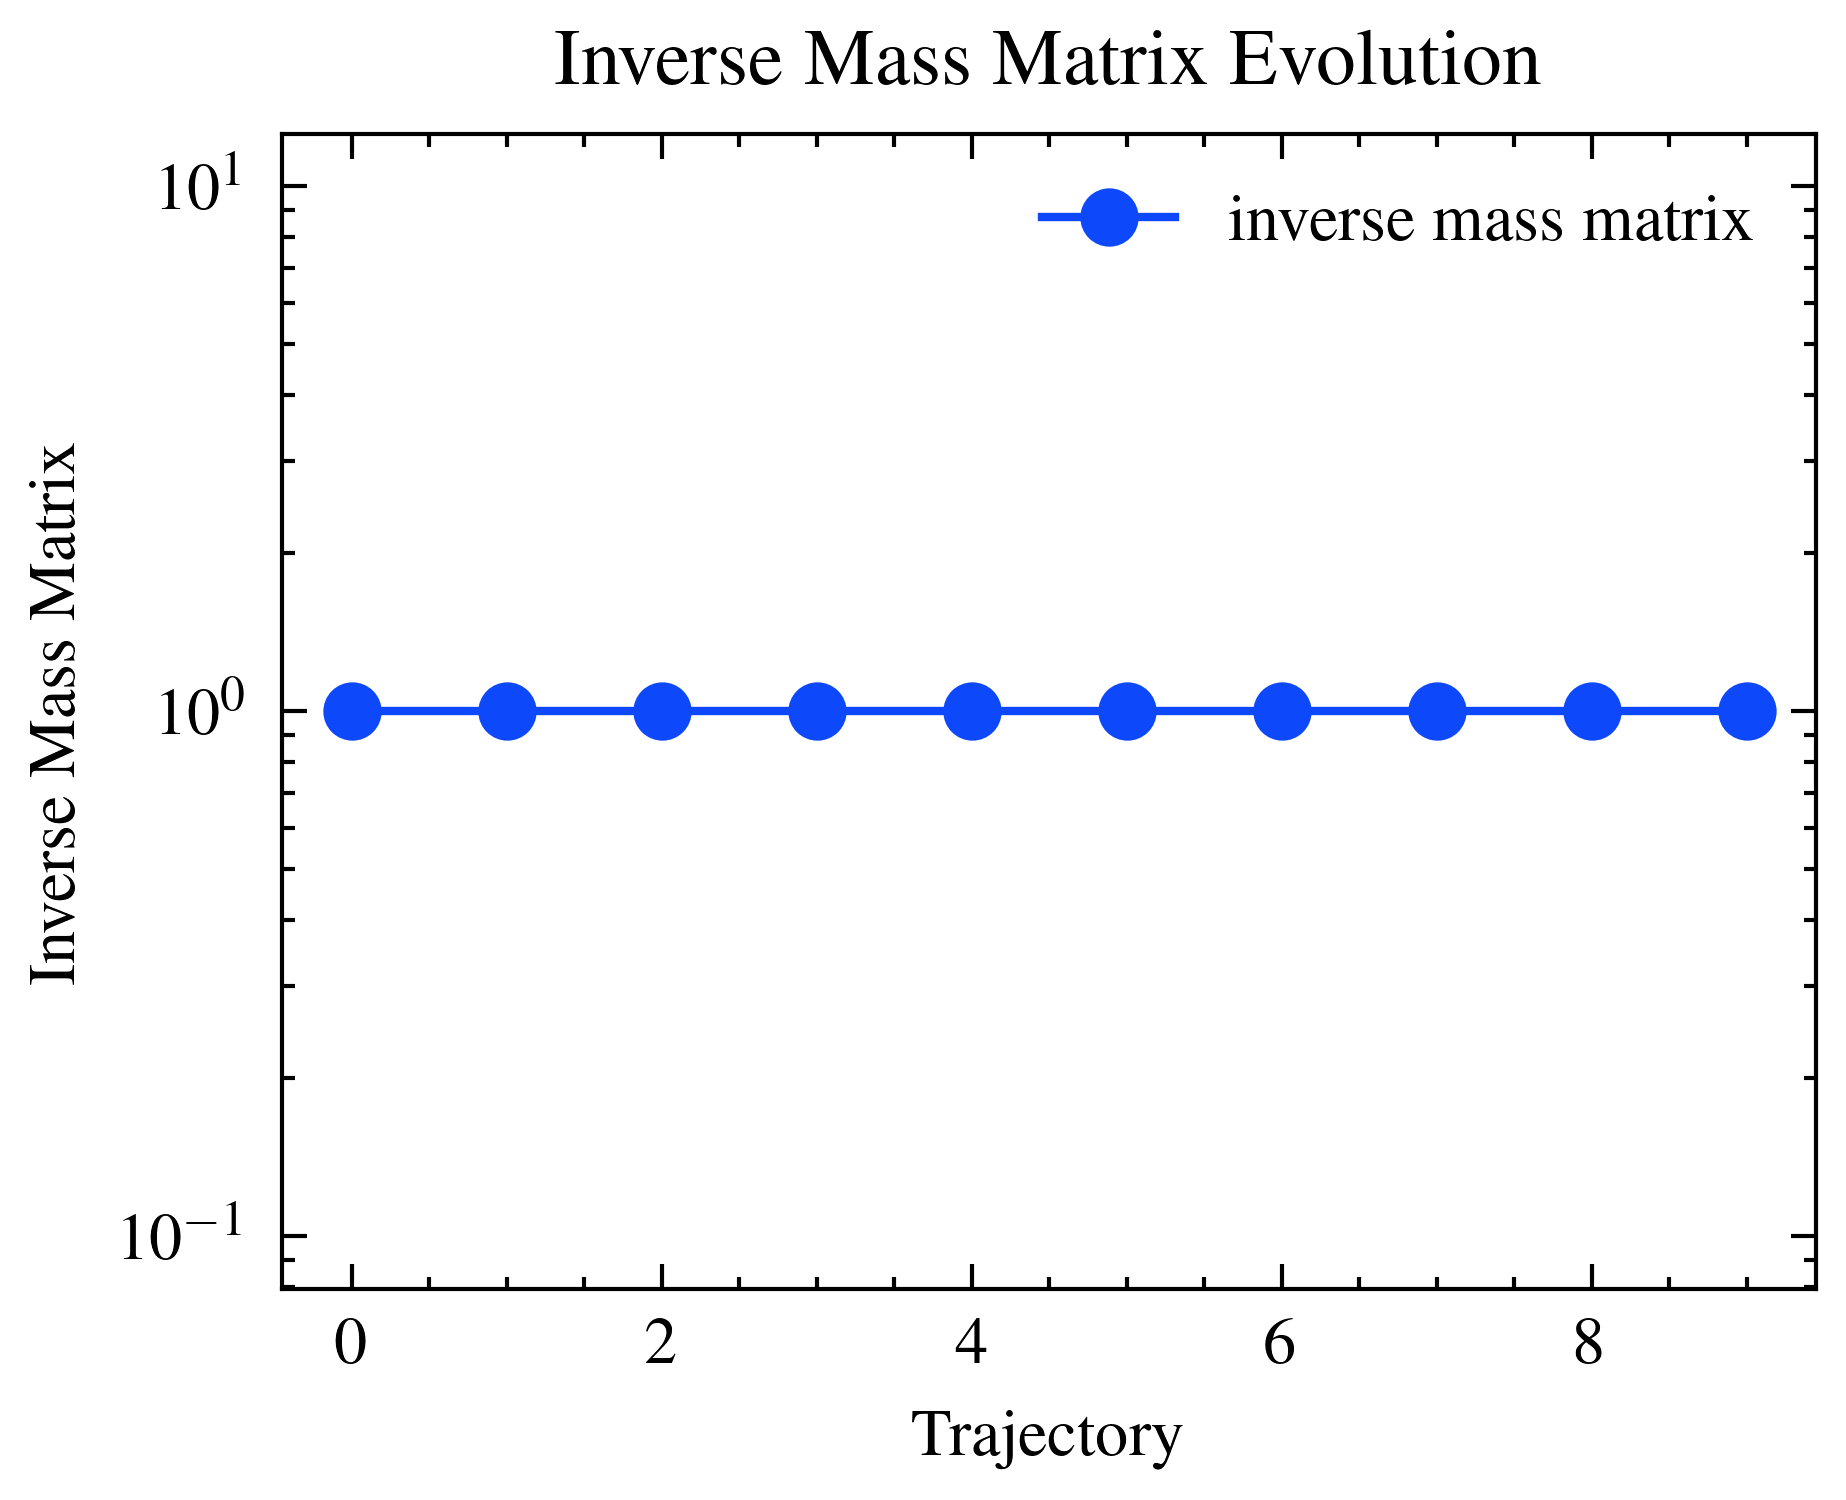

In [79]:
plt.plot(imass_matrices.flatten(),'o-',label='inverse mass matrix')
plt.yscale('log')
plt.xlabel('Trajectory')
plt.ylabel('Inverse Mass Matrix')
plt.title('Inverse Mass Matrix Evolution')
plt.legend()
plt.show()

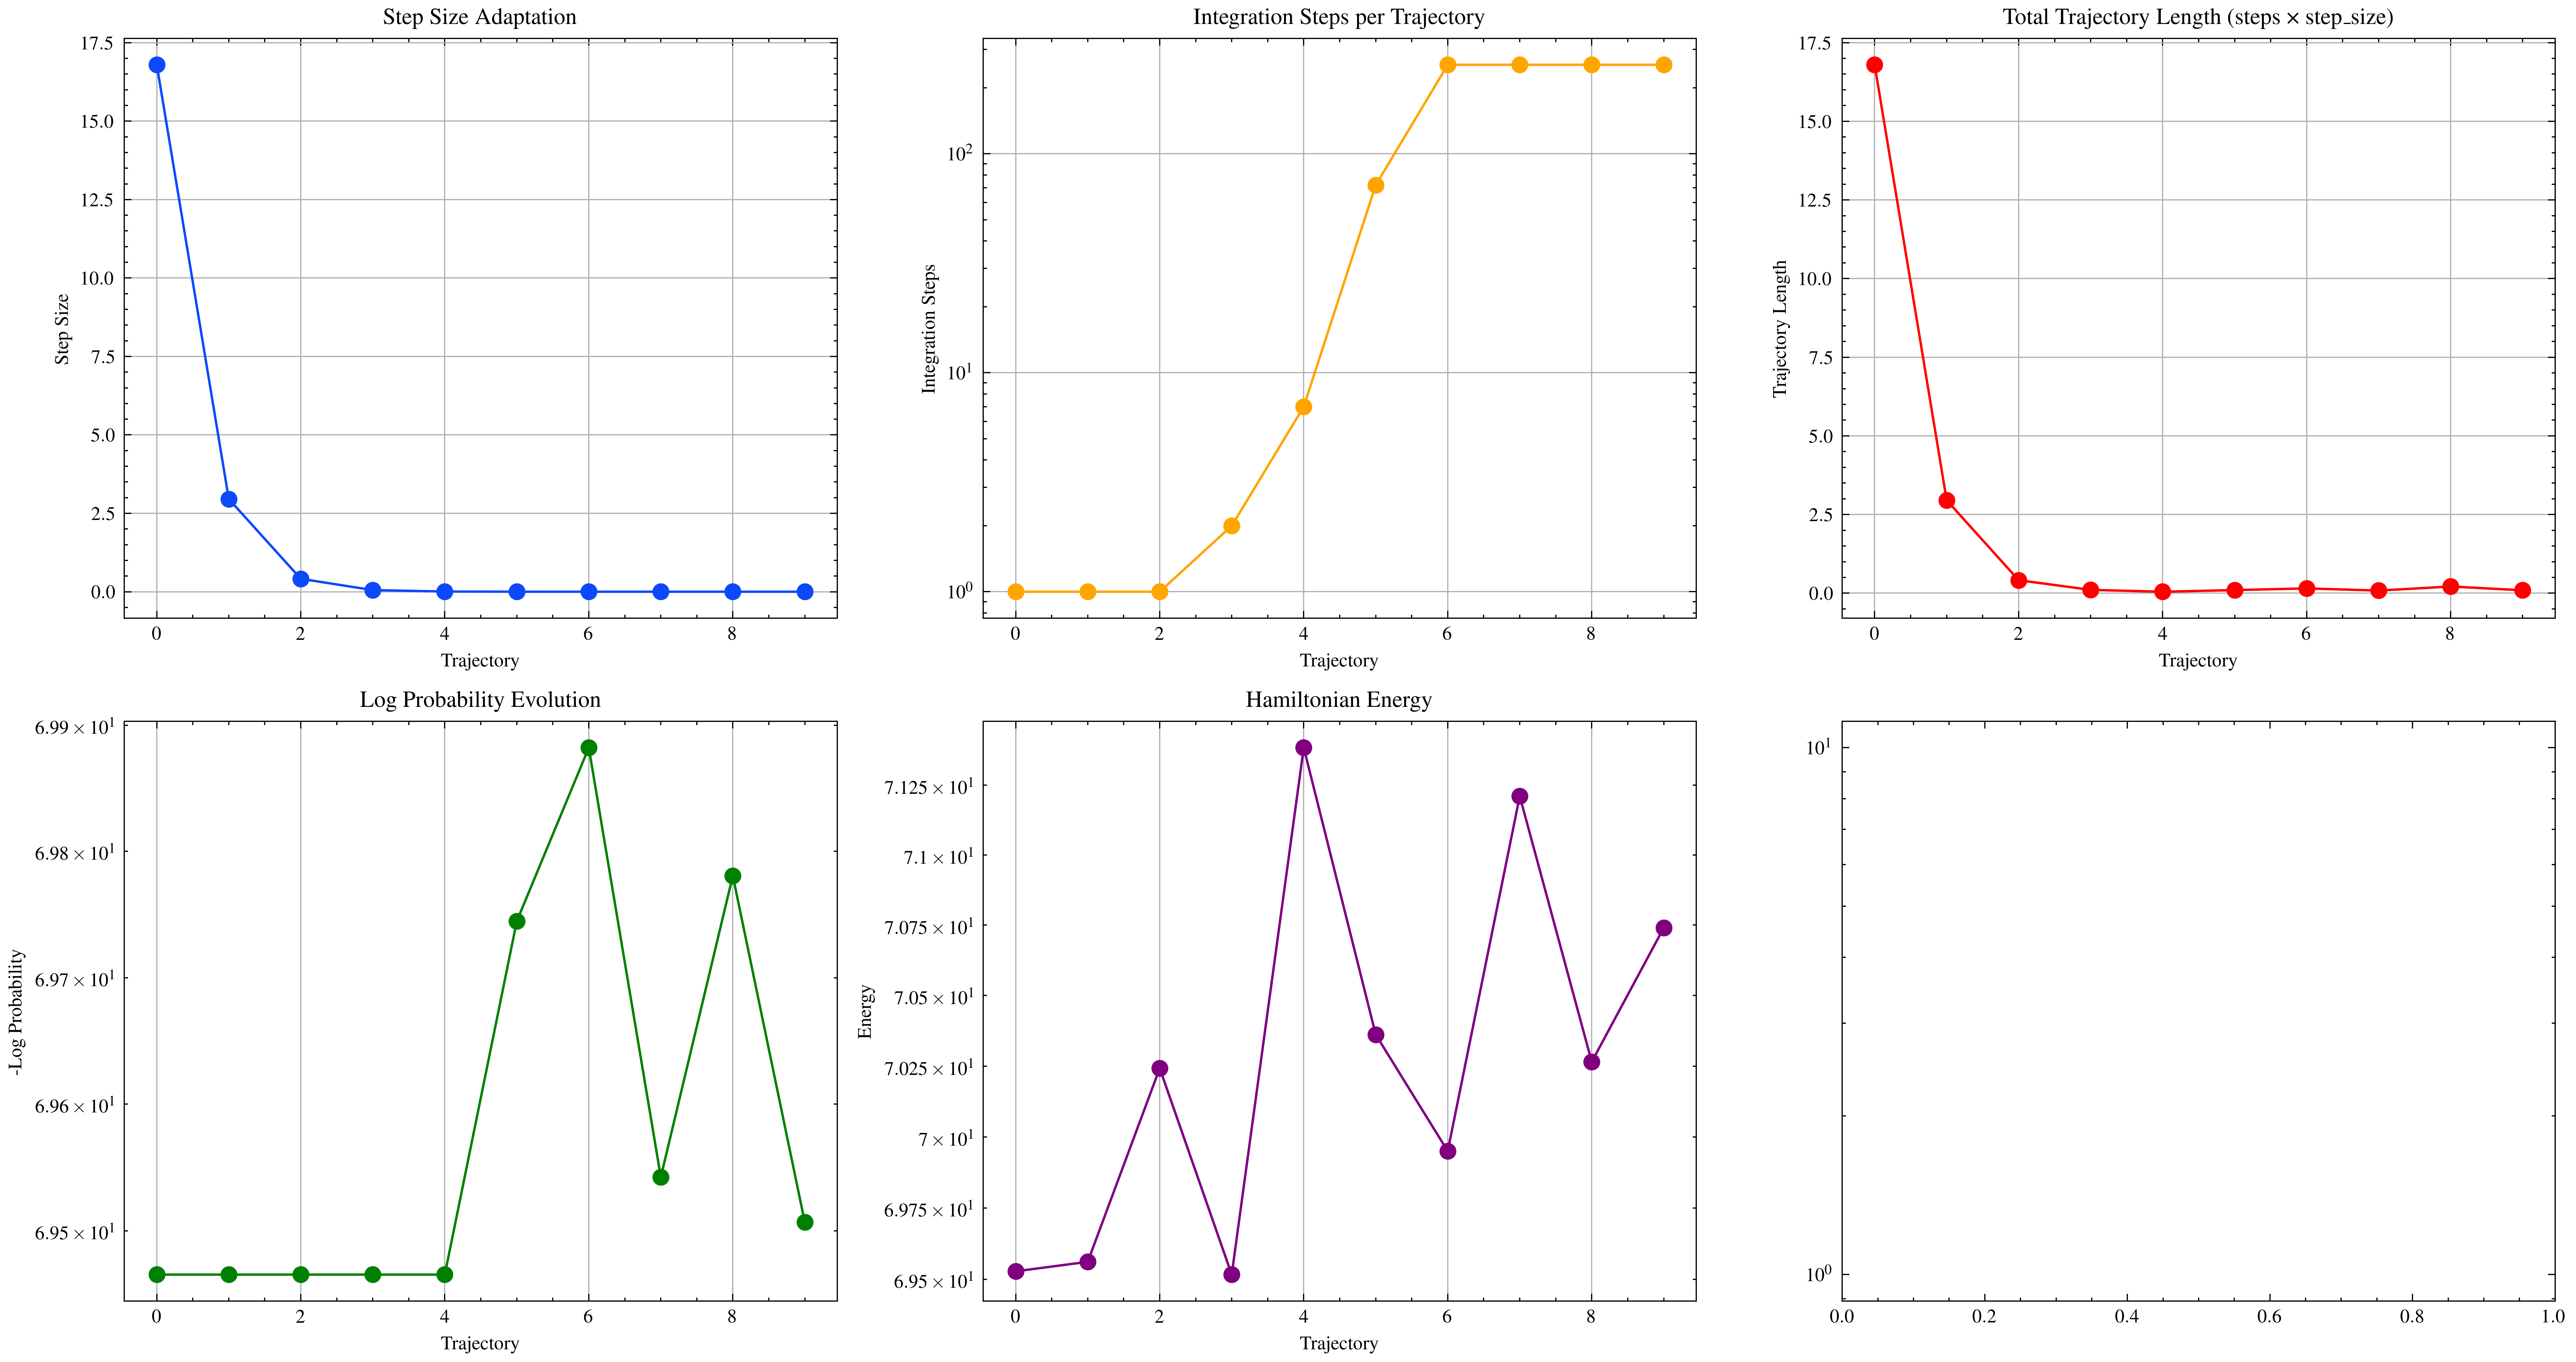

In [80]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Step size evolution
axes[0, 0].plot(range(num_trajectories), step_sizes, 'o-')
axes[0, 0].set_xlabel('Trajectory')
axes[0, 0].set_ylabel('Step Size')
axes[0, 0].set_title('Step Size Adaptation')
axes[0, 0].grid(True)
plt.yscale('log')

# Number of integration steps
axes[0, 1].plot(range(num_trajectories), num_integration_steps, 'o-', color='orange')
axes[0, 1].set_xlabel('Trajectory')
axes[0, 1].set_ylabel('Integration Steps')
axes[0, 1].set_title('Integration Steps per Trajectory')
axes[0, 1].grid(True)
axes[0, 1].set_yscale('log')

# Trajectory length
axes[0, 2].plot(range(num_trajectories), trajectory_lengths, 'o-', color='red')
axes[0, 2].set_xlabel('Trajectory')
axes[0, 2].set_ylabel('Trajectory Length')
axes[0, 2].set_title('Total Trajectory Length (steps × step_size)')
axes[0, 2].grid(True)
plt.yscale('log')

# Log probability
axes[1, 0].plot(range(num_trajectories), -1*jnp.array(log_probs), 'o-', color='green')
axes[1, 0].set_xlabel('Trajectory')
axes[1, 0].set_ylabel('-Log Probability')
axes[1, 0].set_title('Log Probability Evolution')
axes[1, 0].grid(True)
axes[1, 0].set_yscale('log')

# Energy
axes[1, 1].plot(range(num_trajectories), energy, 'o-', color='purple')
axes[1, 1].set_xlabel('Trajectory')
axes[1, 1].set_ylabel('Energy')
axes[1, 1].set_title('Hamiltonian Energy')
axes[1, 1].grid(True)
axes[1, 1].set_yscale('log')

# # Acceptance
# axes[1, 2].bar(range(num_trajectories), is_accepted, color=['green' if x else 'red' for x in is_accepted])
# axes[1, 2].set_xlabel('Trajectory')
# axes[1, 2].set_ylabel('Accepted')
# axes[1, 2].set_title('Acceptance per Trajectory')
# axes[1, 2].set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

In [81]:
# setup the NUTS kernel with adapted settings
kernel = blackjax.nuts(logdensity_fn, **adapted_settings).step

# define the inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):

    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

num_steps_nuts = 7 # number of samples

start = time.time()
states, infos = inference_loop(key_hmc_run, kernel, last_state, num_steps_nuts)
_ = states.position['lens_theta_E'].block_until_ready()
print("Time taken by HMC (blackjax) main phase:", time.time()-start)  

Time taken by HMC (blackjax) main phase: 46.630780935287476


In [82]:
states.position.items()

dict_items([('lens_theta_E', Array([5.0032932 , 5.0090466 , 4.99791351, 5.02124879, 5.06681509,
       5.04995356, 5.03803013], dtype=float64, weak_type=True))])

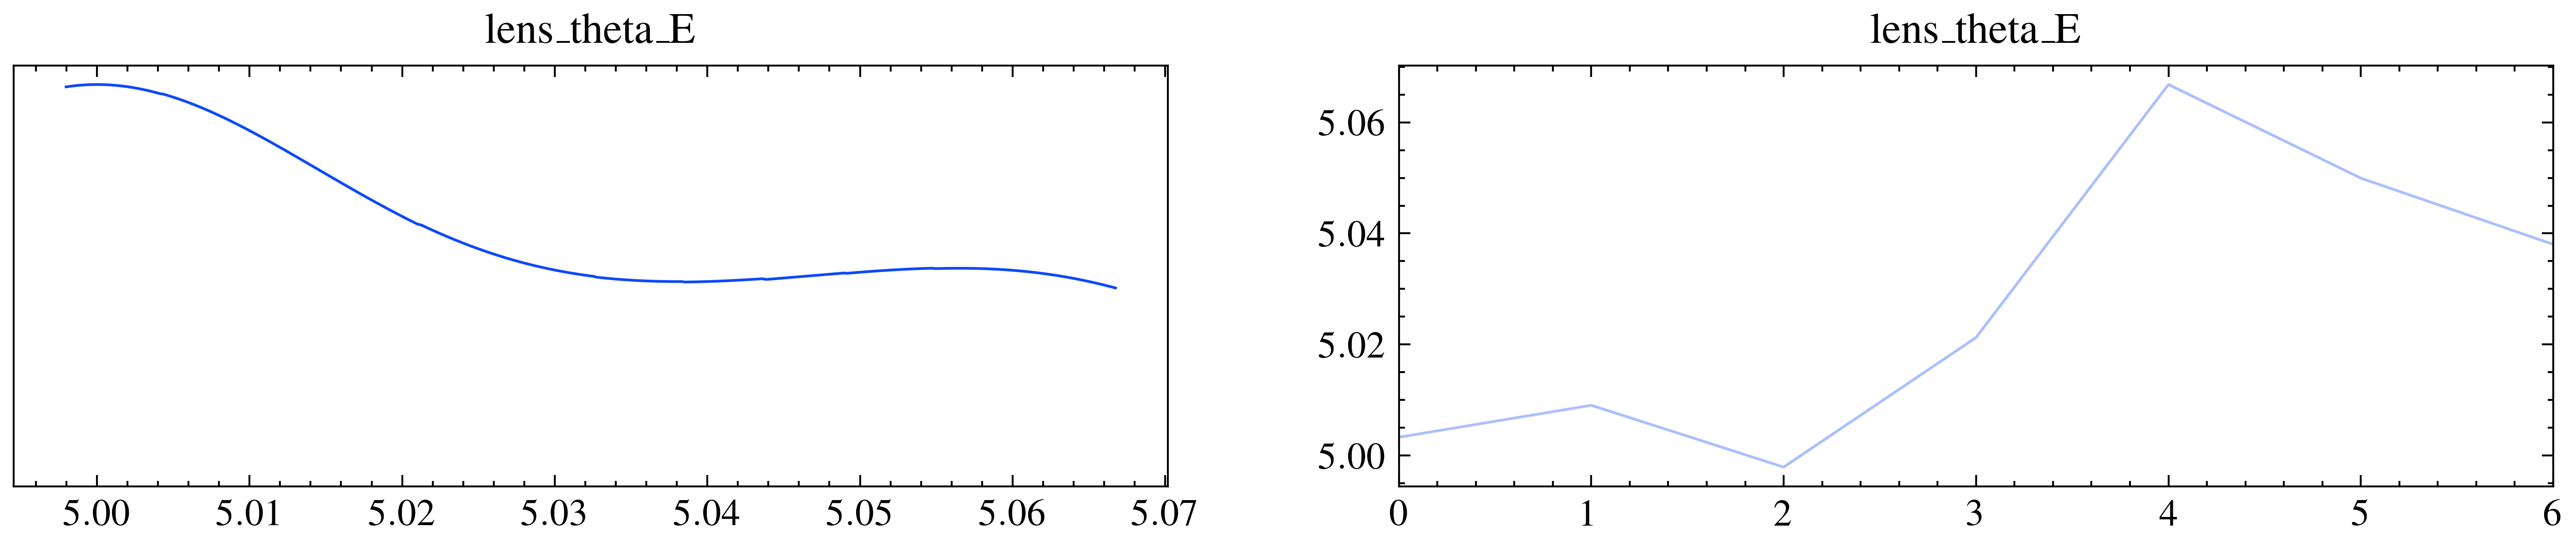

In [83]:
import arviz as az
idata = az.from_dict(posterior={k: v[None, ...] for k, v in states.position.items()})
az.plot_trace(idata);

In [84]:
acceptance_rate = jnp.mean(infos.acceptance_rate)
num_divergent = jnp.mean(infos.is_divergent)

print(f"Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

Average acceptance rate: 0.43
There were 57.14% divergent transitions


In [85]:
hmc_samples = states.position
labels = list(hmc_samples.keys())
print(labels)

['lens_theta_E']


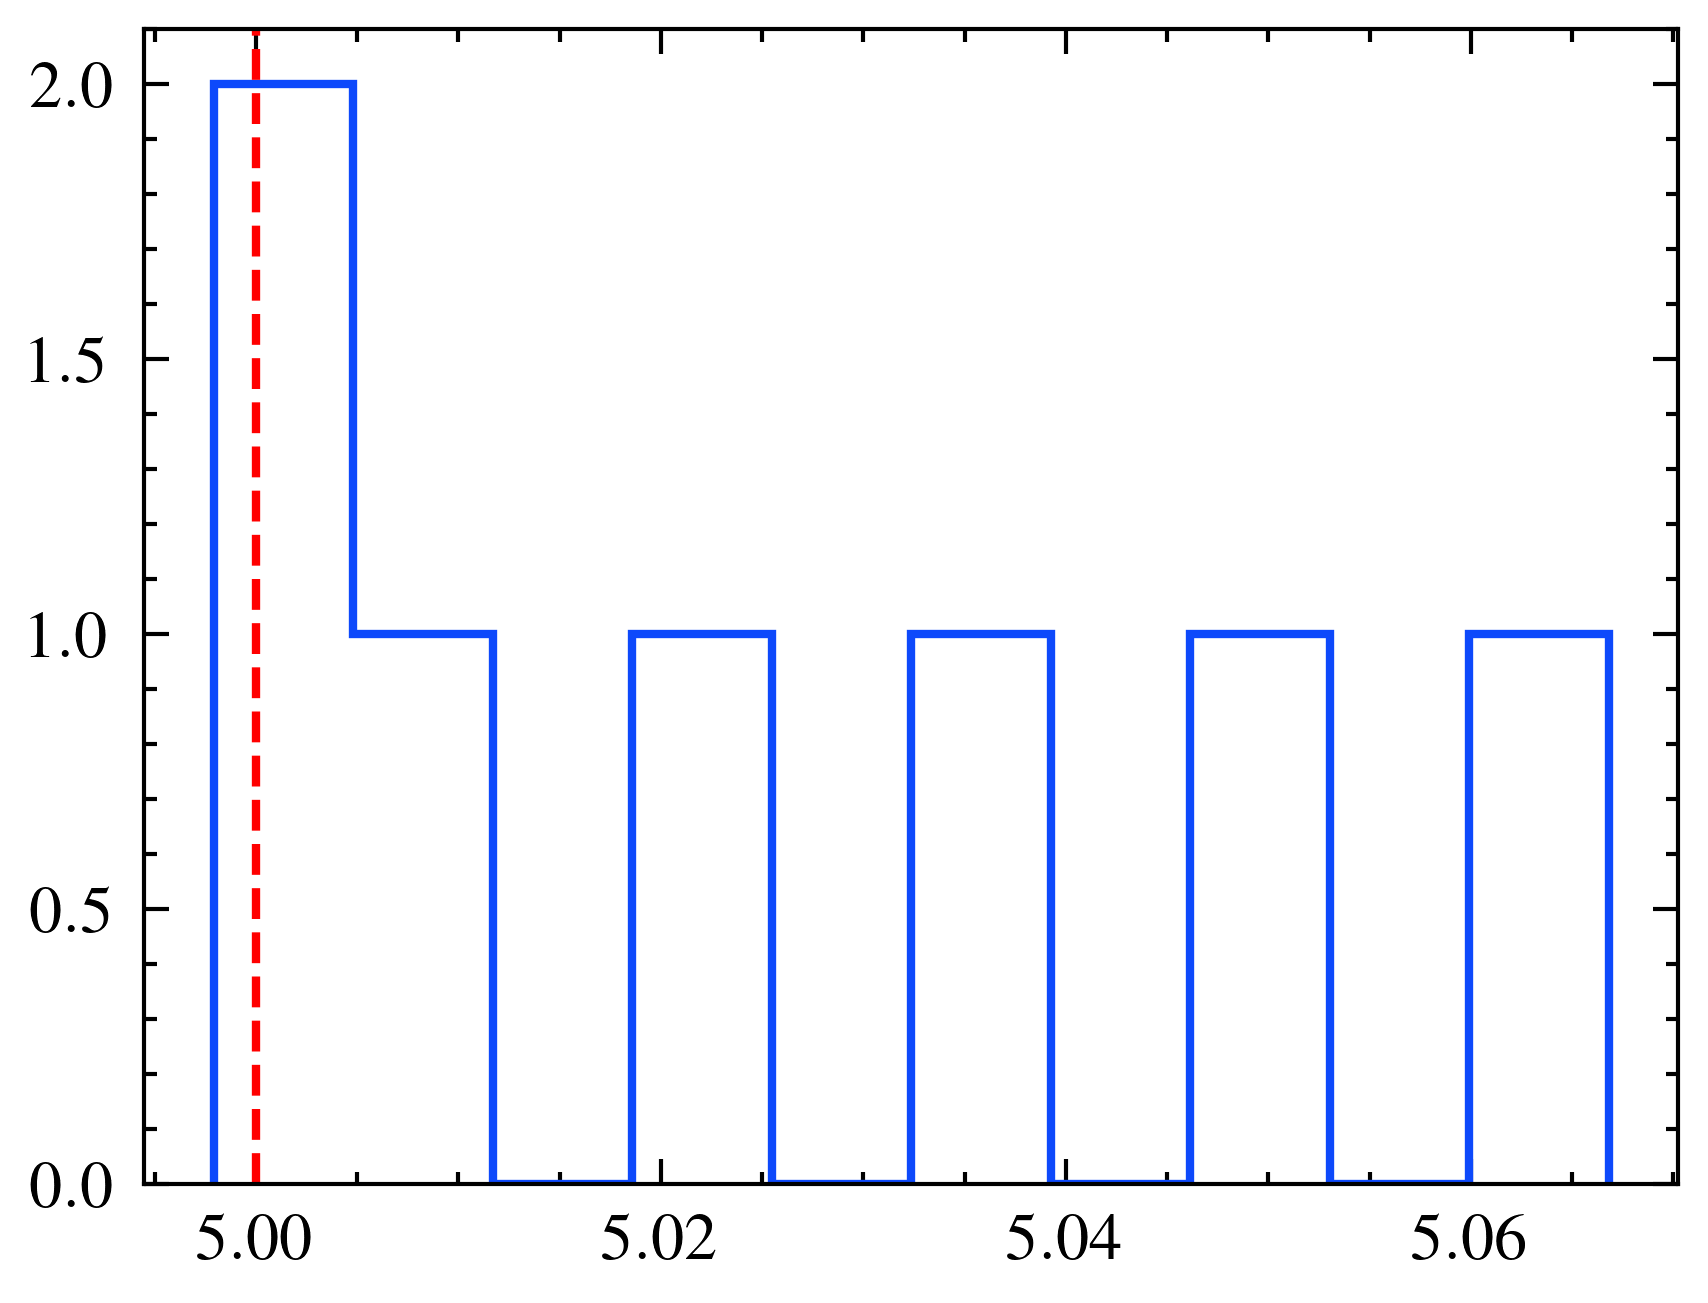

In [86]:
plt.hist(states.position['lens_theta_E'],histtype='step',label='HMC')
plt.axvline(theta_E_true, color='red', linestyle='--', label='True Value')
plt.show()

[[5.0032932 ]
 [5.0090466 ]
 [4.99791351]
 [5.02124879]
 [5.06681509]
 [5.04995356]
 [5.03803013]]


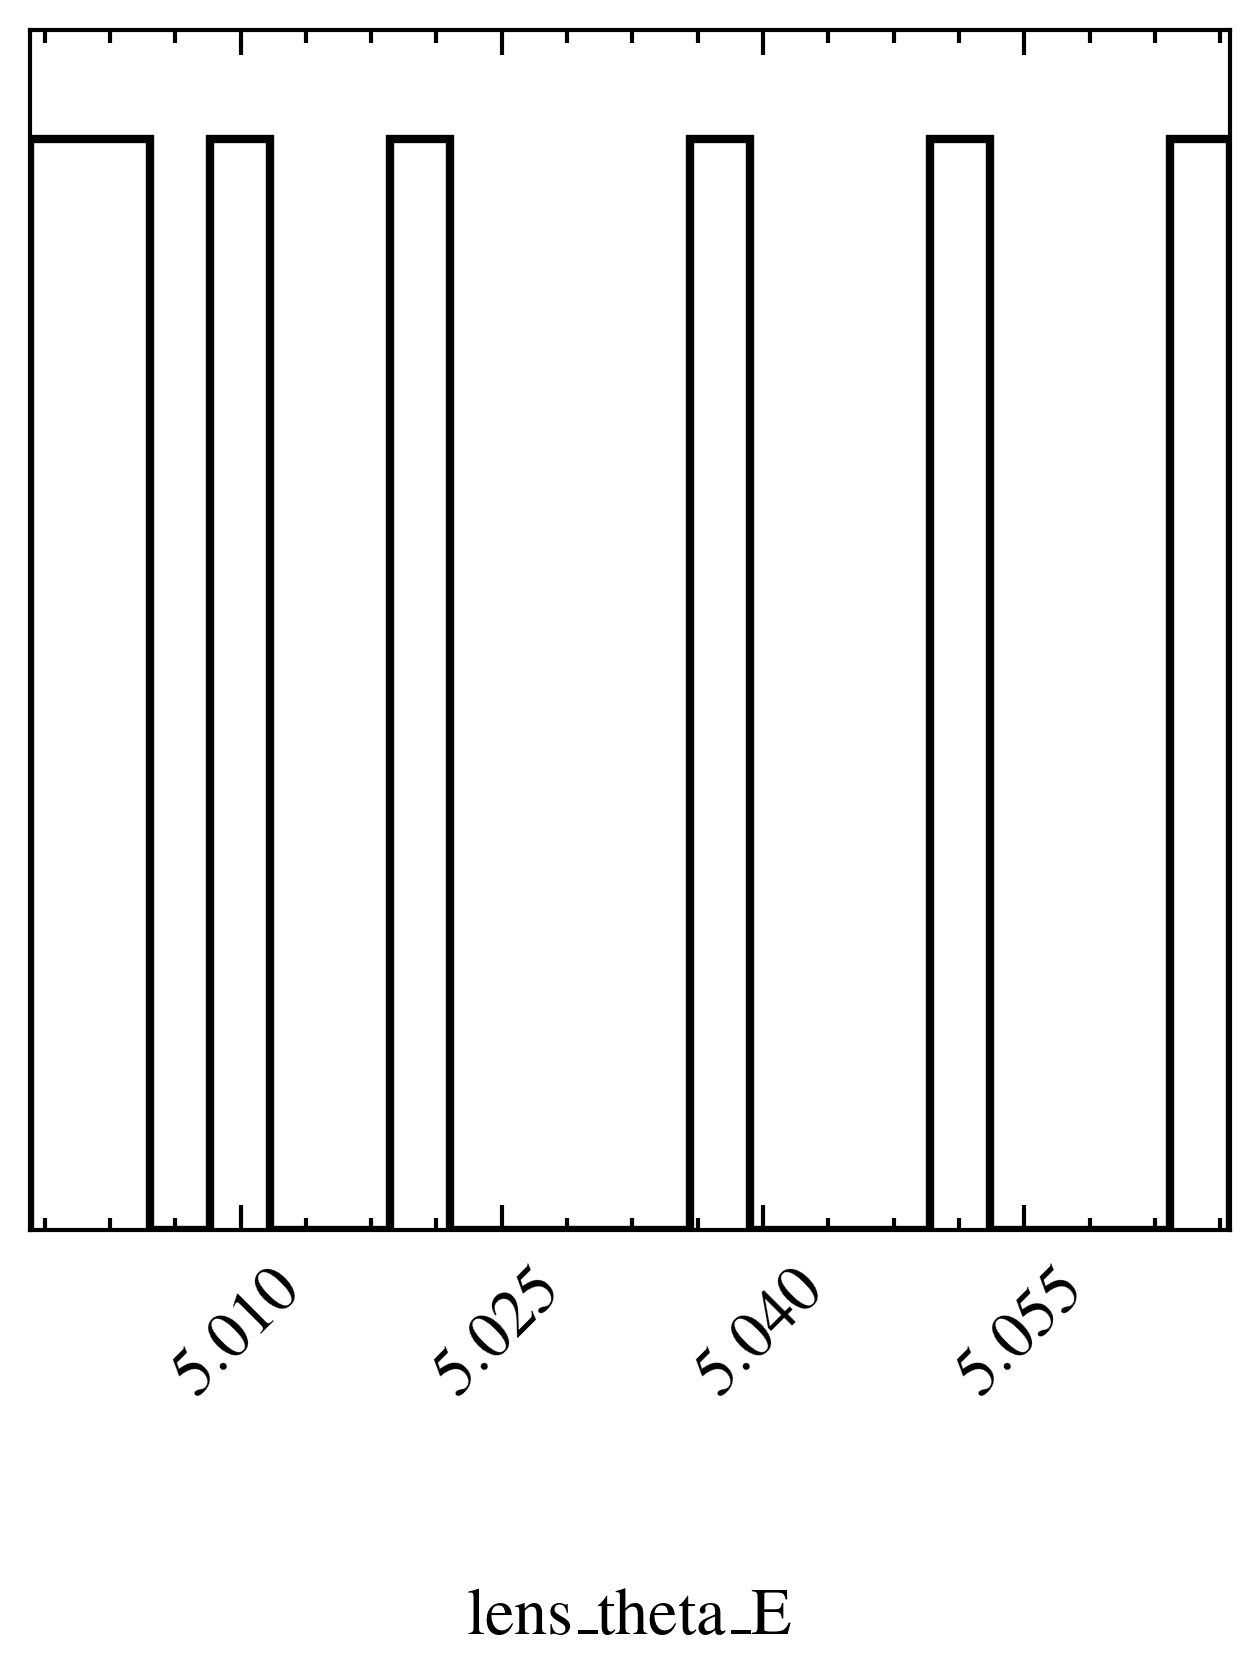

In [92]:
hmc_samples = states.position
params = hmc_samples.keys()
samples = jnp.vstack([hmc_samples[param] for param in params]).T
print(samples)

corner.corner(hmc_samples);


In [ ]:
# corner.corner(states.position['lens_theta_E'])

ValueError: Can only convert xarray dataarray, xarray dataset, dict, pytree (if 'dm-tree' is installed), netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not ArrayImpl

TypeError: 'Axes' object is not subscriptable

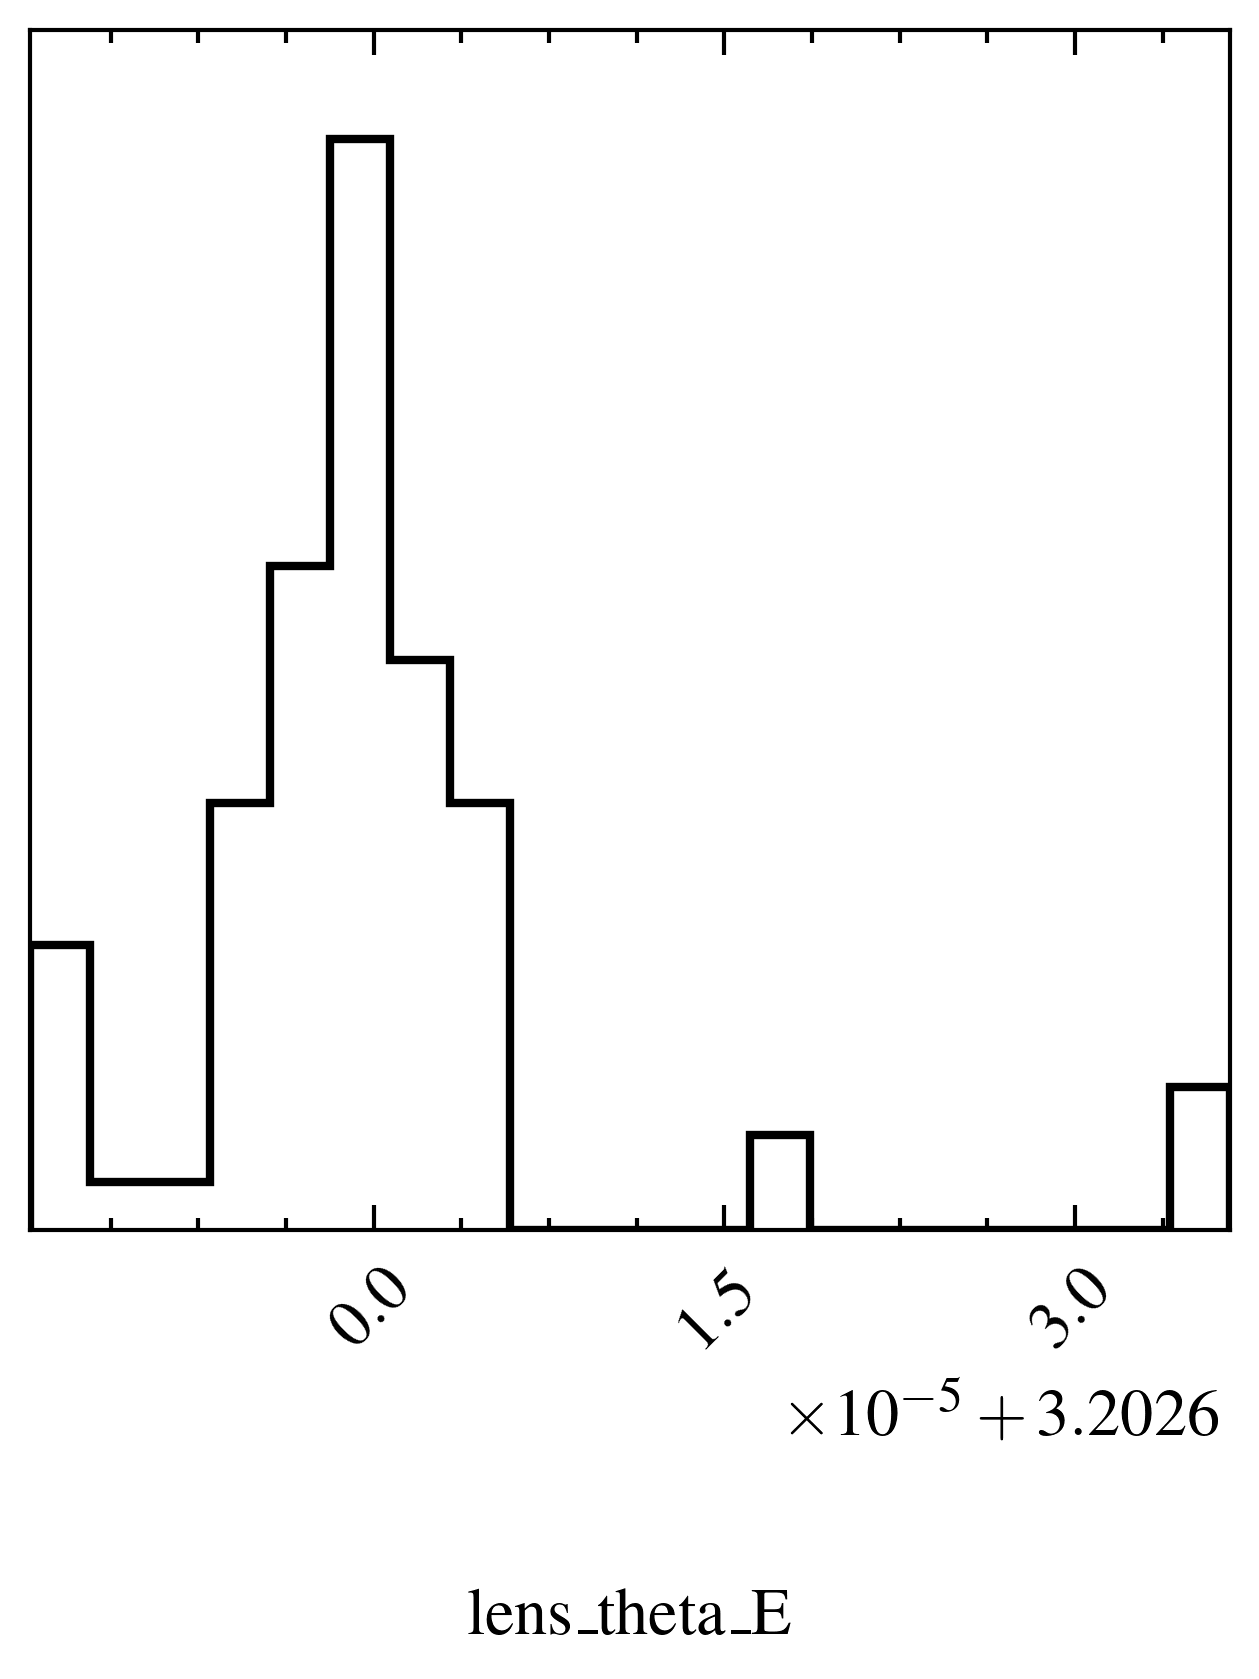

In [ ]:
# import numpy as np
# params_to_plot = [label for label in labels if 'lens' in label]
# samples_to_plot = np.vstack([hmc_samples[param] for param in params_to_plot]).T  
# figure = corner.corner(samples_to_plot, labels=params_to_plot, truths=[input_params[param] for param in params_to_plot])
# plt.show()
# corner.corner(states.position)

In [ ]:
# MCMC 
nuts_kernel = NUTS(gw_model.model, target_accept_prob=0.8)      
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=90, num_chains=1, progress_bar=True)
mcmc.run(prng_key)
mcmc.print_summary()